In [1]:
from rllab.algos.trpo import TRPO
from rllab.baselines.linear_feature_baseline import LinearFeatureBaseline
from rllab.envs.gym_env import GymEnv
from rllab.envs.normalized_env import normalize
from rllab.policies.gaussian_mlp_policy import GaussianMLPPolicy
from rllab.policies.constant_control_policy import ConstantControlPolicy
import rllab.misc.logger as logger
from rllab.sampler import parallel_sampler
from test import test_const_adv, test_rand_adv, test_learnt_adv, test_rand_step_adv, test_step_adv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import gym
import random
import pickle
import scipy
import argparse

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


### Default Parameters

In [2]:
env_name = None                     #Name of adversarial environment
path_length = 1000                  #Maximum episode length
layer_size = tuple([100,100,100])   #Layer definition
ifRender = False                    #Should we render?
afterRender = 100                   #After how many to animate
n_exps = 1                          #Number of training instances to run
n_itr = 25                          #Number of iterations of the alternating optimization
n_pro_itr = 1                       #Number of iterations for the protaginist
n_adv_itr = 1                       #Number of interations for the adversary
batch_size = 4000                   #Number of training samples for each iteration
save_every = 100                    #Save checkpoint every save_every iterations
n_process = 1                       #Number of parallel threads for sampling environment
adv_fraction = 0.25                 #Fraction of maximum adversarial force to be applied
step_size = 0.01                    #kl step size for TRPO
gae_lambda = 0.97                   #gae_lambda for learner
save_dir = './results'              #folder to save result in

### Variables for Experiment

In [3]:
env_name = 'SwimmerAdv-v1'

layer_size = tuple([64,64])
step_size = 0.01
gae_lambda = 0.97
batch_size = 25000

n_itr = 500
save_every = 20
n_process = 4

adv_fraction = 5.0

In [4]:
adv_strengths = [x * 0.5 for x in range(0, 10)]
adv_strengths.append(5.0)
print(adv_strengths)

[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


In [6]:
args = [env_name, path_length, layer_size, ifRender, afterRender, n_exps, n_itr, n_pro_itr, n_adv_itr, 
        batch_size, save_every, n_process, adv_fraction, step_size, gae_lambda, save_dir]

### Adv Policy

In [7]:
filepath = 'results/Swimmer/env-SwimmerAdv-v1_Exp1_Itr500_BS25000_Adv0.25_stp0.01_lam0.97_435321.p'

res_D = pickle.load(open(filepath,'rb'))
pretrained_adv_policy = res_D['adv_policy']

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
[2018-01-25 11:15:35,293] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


### Train Loop

In [8]:
## Initializing summaries for the tests ##
const_test_rew_summary = []
rand_test_rew_summary = []
step_test_rew_summary = []
rand_step_test_rew_summary = []
adv_test_rew_summary = []

## Preparing file to save results in ##
save_prefix = 'adv_env-{}_Exp{}_Itr{}_BS{}_Adv{}_stp{}_lam{}_{}'.format(env_name, n_exps, n_itr, batch_size, adv_fraction, step_size, gae_lambda, random.randint(0,1000000))
save_name = save_dir+'/'+save_prefix

## Looping over experiments to carry out ##
for ne in range(n_exps):
    ## Environment definition ##
    ## The second argument in GymEnv defines the relative magnitude of adversary. For testing we set this to 1.0.
    env = normalize(GymEnv(env_name, adv_fraction))
    env_orig = normalize(GymEnv(env_name, 1.0))

    ## Protagonist policy definition ##
    pro_policy = GaussianMLPPolicy(
        env_spec=env.spec,
        hidden_sizes=layer_size,
        is_protagonist=True
    )
    pro_baseline = LinearFeatureBaseline(env_spec=env.spec)

    ## Zero Adversary for the protagonist training ##
    zero_adv_policy = ConstantControlPolicy(
        env_spec=env.spec,
        is_protagonist=False,
        constant_val = 0.0
    )

    ## Adversary policy definition ##
    adv_policy = pretrained_adv_policy
    adv_baseline = LinearFeatureBaseline(env_spec=env.spec)

    ## Initializing the parallel sampler ##
    parallel_sampler.initialize(n_process)    

    ## Setting up summaries for testing for a specific training instance ##
    pro_rews = []
    adv_rews = []
    all_rews = []
    const_testing_rews = []
    const_testing_rews.append(test_const_adv(env_orig, pro_policy, path_length=path_length))
    rand_testing_rews = []
    rand_testing_rews.append(test_rand_adv(env_orig, pro_policy, path_length=path_length))
    step_testing_rews = []
    step_testing_rews.append(test_step_adv(env_orig, pro_policy, path_length=path_length))
    rand_step_testing_rews = []
    rand_step_testing_rews.append(test_rand_step_adv(env_orig, pro_policy, path_length=path_length))
    adv_testing_rews = []
    adv_testing_rews.append(test_learnt_adv(env, pro_policy, adv_policy, path_length=path_length))

    ## Loops through adversary strength levels
    n_loopsize = int(n_itr/len(adv_strengths))
    for adv_index, adv_strength in enumerate(adv_strengths):
        
        env = normalize(GymEnv(env_name, adv_strength))
        
        ## Optimizer for the Protagonist ##
        pro_algo = TRPO(
            env=env,
            pro_policy=pro_policy,
            adv_policy=adv_policy,
            pro_baseline=pro_baseline,
            adv_baseline=adv_baseline,
            batch_size=batch_size,
            max_path_length=path_length,
            n_itr=n_pro_itr,
            discount=0.995,
            gae_lambda=gae_lambda,
            step_size=step_size,
            is_protagonist=True
        )
        
        logger.log('\n\nAdversarial Level: {} Adversarial Strength: {}\n'.format(adv_index, adv_strength))
        
        ## Beginning alternating optimization ##
        for ni in range(n_loopsize):
            logger.log('\n\nExperiment: {} Iteration: {}\n'.format(ne,ni+n_loopsize*adv_index,))

            ## Train Protagonist
            pro_algo.train()
            pro_rews += pro_algo.rews; all_rews += pro_algo.rews;
            logger.log('Protag Reward: {}'.format(np.array(pro_algo.rews).mean()))

            ## Test the learnt policies
            const_testing_rews.append(test_const_adv(env, pro_policy, path_length=path_length))
            rand_testing_rews.append(test_rand_adv(env, pro_policy, path_length=path_length))
            step_testing_rews.append(test_step_adv(env, pro_policy, path_length=path_length))
            rand_step_testing_rews.append(test_rand_step_adv(env, pro_policy, path_length=path_length))
            adv_testing_rews.append(test_learnt_adv(env, pro_policy, adv_policy, path_length=path_length))

            if ni%afterRender==0 and ifRender==True:
                test_const_adv(env, pro_policy, path_length=path_length, n_traj=1, render=True);

            if ni!=0 and ni%save_every==0:
                ## SAVING CHECKPOINT INFO ##
                pickle.dump({'args': args,
                             'pro_policy': pro_policy,
                             'adv_policy': adv_policy,
                             'zero_test': [const_testing_rews],
                             'rand_test': [rand_testing_rews],
                             'step_test': [step_testing_rews],
                             'rand_step_test': [rand_step_testing_rews],
                             'iter_save': ni,
                             'exp_save': ne,
                             'adv_test': [adv_testing_rews]}, open(save_name+'_'+str(ni+n_loopsize*adv_index)+'.p','wb'))

    ## Shutting down the optimizer ##
    pro_algo.shutdown_worker()

    ## Updating the test summaries over all training instances
    const_test_rew_summary.append(const_testing_rews)
    rand_test_rew_summary.append(rand_testing_rews)
    step_test_rew_summary.append(step_testing_rews)
    rand_step_test_rew_summary.append(rand_step_testing_rews)
    adv_test_rew_summary.append(adv_testing_rews)

2018-01-25 11:15:56.408859 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 11:15:56,415] Making new env: SwimmerAdv-v1


2018-01-25 11:15:57.035336 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 11:15:57,041] Making new env: SwimmerAdv-v1


2018-01-25 11:16:20.694839 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 11:16:20,697] Making new env: SwimmerAdv-v1


2018-01-25 11:16:20.709026 EST | Populating workers...
2018-01-25 11:16:20.714175 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 11:16:20.714173 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 11:16:20,718] Making new env: SwimmerAdv-v1


2018-01-25 11:16:20.715427 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 11:16:20.719162 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 11:16:20,722] Making new env: SwimmerAdv-v1
[2018-01-25 11:16:20,724] Making new env: SwimmerAdv-v1
[2018-01-25 11:16:20,718] Making new env: SwimmerAdv-v1


2018-01-25 11:16:21.472080 EST | Populated
2018-01-25 11:16:21.711418 EST | 

Adversarial Level: 0 Adversarial Strength: 0.0

2018-01-25 11:16:21.713158 EST | 

Experiment: 0 Iteration: 0

2018-01-25 11:16:21.714938 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:16:30.081080 EST | fitting baseline...
2018-01-25 11:16:30.104427 EST | fitted
=: Compiling function f_loss
done in 0.536 seconds
=: Compiling function constraint
done in 0.366 seconds
2018-01-25 11:16:31.678025 EST | computing loss before
2018-01-25 11:16:32.010955 EST | performing update
2018-01-25 11:16:32.012517 EST | computing descent direction
=: Compiling function f_grad
done in 1.372 seconds
=: Compiling function f_Hx_plain
done in 4.406 seconds
2018-01-25 11:16:50.501540 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 0.836 seconds
2018-01-25 11:16:52.135019 EST | backtrack iters: 1
2018-01-25 11:16:52.143258 EST | computing loss after
2018-01-25 11:16:52.144649 EST | optimization finished
2018-01-25 11:16:52.835872 EST | Protag Reward: 28.85037727274489
2018-01-25 11:17:10.683127 EST | 

Experiment: 0 Iteration: 1

2018-01-25 11:17:10.685297 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:17:19.302346 EST | fitting baseline...
2018-01-25 11:17:19.324247 EST | fitted
2018-01-25 11:17:20.107799 EST | computing loss before
2018-01-25 11:17:20.523717 EST | performing update
2018-01-25 11:17:20.527294 EST | computing descent direction
2018-01-25 11:17:32.273816 EST | descent direction computed
2018-01-25 11:17:32.712126 EST | backtrack iters: 0
2018-01-25 11:17:32.718764 EST | computing loss after
2018-01-25 11:17:32.724113 EST | optimization finished
2018-01-25 11:17:33.377376 EST | Protag Reward: 34.269859904564235
2018-01-25 11:17:49.597011 EST | 

Experiment: 0 Iteration: 2

2018-01-25 11:17:49.598314 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:17:58.261858 EST | fitting baseline...
2018-01-25 11:17:58.285991 EST | fitted
2018-01-25 11:17:59.107977 EST | computing loss before
2018-01-25 11:17:59.574708 EST | performing update
2018-01-25 11:17:59.576594 EST | computing descent direction
2018-01-25 11:18:07.776676 EST | descent direction computed
2018-01-25 11:18:08.329278 EST | backtrack iters: 1
2018-01-25 11:18:08.330838 EST | computing loss after
2018-01-25 11:18:08.332239 EST | optimization finished
2018-01-25 11:18:09.026520 EST | Protag Reward: 56.471084925994084
2018-01-25 11:18:27.296434 EST | 

Experiment: 0 Iteration: 3

2018-01-25 11:18:27.297868 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:18:35.866583 EST | fitting baseline...
2018-01-25 11:18:35.893085 EST | fitted
2018-01-25 11:18:36.621248 EST | computing loss before
2018-01-25 11:18:37.014444 EST | performing update
2018-01-25 11:18:37.016071 EST | computing descent direction
2018-01-25 11:18:47.125202 EST | descent direction computed
2018-01-25 11:18:47.510735 EST | backtrack iters: 0
2018-01-25 11:18:47.512350 EST | computing loss after
2018-01-25 11:18:47.513680 EST | optimization finished
2018-01-25 11:18:48.249105 EST | Protag Reward: 79.11853831101128
2018-01-25 11:19:05.383332 EST | 

Experiment: 0 Iteration: 4

2018-01-25 11:19:05.385432 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:19:12.830926 EST | fitting baseline...
2018-01-25 11:19:12.870948 EST | fitted
2018-01-25 11:19:13.553061 EST | computing loss before
2018-01-25 11:19:13.879514 EST | performing update
2018-01-25 11:19:13.881309 EST | computing descent direction
2018-01-25 11:19:26.456013 EST | descent direction computed
2018-01-25 11:19:27.158854 EST | backtrack iters: 1
2018-01-25 11:19:27.161934 EST | computing loss after
2018-01-25 11:19:27.165468 EST | optimization finished
2018-01-25 11:19:27.920755 EST | Protag Reward: 74.14533884291642
2018-01-25 11:19:46.794090 EST | 

Experiment: 0 Iteration: 5

2018-01-25 11:19:46.795682 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:19:53.584343 EST | fitting baseline...
2018-01-25 11:19:53.654841 EST | fitted
2018-01-25 11:19:54.628698 EST | computing loss before
2018-01-25 11:19:55.027356 EST | performing update
2018-01-25 11:19:55.034260 EST | computing descent direction
2018-01-25 11:20:07.409841 EST | descent direction computed
2018-01-25 11:20:08.157397 EST | backtrack iters: 1
2018-01-25 11:20:08.159468 EST | computing loss after
2018-01-25 11:20:08.161491 EST | optimization finished
2018-01-25 11:20:08.925709 EST | Protag Reward: 75.57316971273463
2018-01-25 11:20:25.711924 EST | 

Experiment: 0 Iteration: 6

2018-01-25 11:20:25.713480 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:20:33.658253 EST | fitting baseline...
2018-01-25 11:20:33.722131 EST | fitted
2018-01-25 11:20:34.584177 EST | computing loss before
2018-01-25 11:20:34.998119 EST | performing update
2018-01-25 11:20:35.000306 EST | computing descent direction
2018-01-25 11:20:42.876432 EST | descent direction computed
2018-01-25 11:20:43.550931 EST | backtrack iters: 1
2018-01-25 11:20:43.552703 EST | computing loss after
2018-01-25 11:20:43.554147 EST | optimization finished
2018-01-25 11:20:44.141861 EST | Protag Reward: 77.44271693382372
2018-01-25 11:21:00.460460 EST | 

Experiment: 0 Iteration: 7

2018-01-25 11:21:00.461725 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:21:08.663108 EST | fitting baseline...
2018-01-25 11:21:08.684350 EST | fitted
2018-01-25 11:21:09.461219 EST | computing loss before
2018-01-25 11:21:09.776436 EST | performing update
2018-01-25 11:21:09.778111 EST | computing descent direction
2018-01-25 11:21:21.586243 EST | descent direction computed
2018-01-25 11:21:22.227439 EST | backtrack iters: 1
2018-01-25 11:21:22.228568 EST | computing loss after
2018-01-25 11:21:22.229347 EST | optimization finished
2018-01-25 11:21:23.020600 EST | Protag Reward: 81.36919996804905
2018-01-25 11:21:38.898052 EST | 

Experiment: 0 Iteration: 8

2018-01-25 11:21:38.899786 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:21:46.425292 EST | fitting baseline...
2018-01-25 11:21:46.446093 EST | fitted
2018-01-25 11:21:46.987417 EST | computing loss before
2018-01-25 11:21:47.215049 EST | performing update
2018-01-25 11:21:47.216376 EST | computing descent direction
2018-01-25 11:21:57.867544 EST | descent direction computed
2018-01-25 11:21:58.626898 EST | backtrack iters: 1
2018-01-25 11:21:58.631235 EST | computing loss after
2018-01-25 11:21:58.635676 EST | optimization finished
2018-01-25 11:21:59.348377 EST | Protag Reward: 83.83072906920462
2018-01-25 11:22:15.550393 EST | 

Experiment: 0 Iteration: 9

2018-01-25 11:22:15.551727 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:22:24.239163 EST | fitting baseline...
2018-01-25 11:22:24.259751 EST | fitted
2018-01-25 11:22:24.946901 EST | computing loss before
2018-01-25 11:22:25.217081 EST | performing update
2018-01-25 11:22:25.224896 EST | computing descent direction
2018-01-25 11:22:35.058546 EST | descent direction computed
2018-01-25 11:22:35.770838 EST | backtrack iters: 1
2018-01-25 11:22:35.774661 EST | computing loss after
2018-01-25 11:22:35.778680 EST | optimization finished
2018-01-25 11:22:36.262029 EST | Protag Reward: 76.37405829431866
2018-01-25 11:22:52.776405 EST | 

Experiment: 0 Iteration: 10

2018-01-25 11:22:52.778057 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:23:00.382716 EST | fitting baseline...
2018-01-25 11:23:00.397650 EST | fitted
2018-01-25 11:23:00.939980 EST | computing loss before
2018-01-25 11:23:01.184806 EST | performing update
2018-01-25 11:23:01.185941 EST | computing descent direction
2018-01-25 11:23:10.112180 EST | descent direction computed
2018-01-25 11:23:10.999036 EST | backtrack iters: 1
2018-01-25 11:23:11.001015 EST | computing loss after
2018-01-25 11:23:11.005703 EST | optimization finished
2018-01-25 11:23:11.919538 EST | Protag Reward: 76.86667979125293
2018-01-25 11:23:29.253277 EST | 

Experiment: 0 Iteration: 11

2018-01-25 11:23:29.254919 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:23:36.212453 EST | fitting baseline...
2018-01-25 11:23:36.246942 EST | fitted
2018-01-25 11:23:36.811178 EST | computing loss before
2018-01-25 11:23:37.080778 EST | performing update
2018-01-25 11:23:37.081960 EST | computing descent direction
2018-01-25 11:23:43.944876 EST | descent direction computed
2018-01-25 11:23:44.667096 EST | backtrack iters: 1
2018-01-25 11:23:44.668522 EST | computing loss after
2018-01-25 11:23:44.669759 EST | optimization finished
2018-01-25 11:23:45.289224 EST | Protag Reward: 76.70026800763794
2018-01-25 11:24:03.968937 EST | 

Experiment: 0 Iteration: 12

2018-01-25 11:24:03.970157 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:24:10.442654 EST | fitting baseline...
2018-01-25 11:24:10.482286 EST | fitted
2018-01-25 11:24:11.042354 EST | computing loss before
2018-01-25 11:24:11.265420 EST | performing update
2018-01-25 11:24:11.266700 EST | computing descent direction
2018-01-25 11:24:18.941329 EST | descent direction computed
2018-01-25 11:24:19.531841 EST | backtrack iters: 1
2018-01-25 11:24:19.533803 EST | computing loss after
2018-01-25 11:24:19.535676 EST | optimization finished
2018-01-25 11:24:20.168751 EST | Protag Reward: 78.49835732393892
2018-01-25 11:24:43.676363 EST | 

Experiment: 0 Iteration: 13

2018-01-25 11:24:43.677419 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:24:51.600143 EST | fitting baseline...
2018-01-25 11:24:51.614092 EST | fitted
2018-01-25 11:24:52.042818 EST | computing loss before
2018-01-25 11:24:52.227902 EST | performing update
2018-01-25 11:24:52.229539 EST | computing descent direction
2018-01-25 11:25:00.485905 EST | descent direction computed
2018-01-25 11:25:00.784441 EST | backtrack iters: 0
2018-01-25 11:25:00.785764 EST | computing loss after
2018-01-25 11:25:00.787080 EST | optimization finished
2018-01-25 11:25:01.865938 EST | Protag Reward: 80.51425349263118
2018-01-25 11:25:21.726605 EST | 

Experiment: 0 Iteration: 14

2018-01-25 11:25:21.728150 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:25:28.610261 EST | fitting baseline...
2018-01-25 11:25:28.629879 EST | fitted
2018-01-25 11:25:29.099749 EST | computing loss before
2018-01-25 11:25:29.372437 EST | performing update
2018-01-25 11:25:29.373826 EST | computing descent direction
2018-01-25 11:25:35.008249 EST | descent direction computed
2018-01-25 11:25:35.270318 EST | backtrack iters: 0
2018-01-25 11:25:35.271472 EST | computing loss after
2018-01-25 11:25:35.272524 EST | optimization finished
2018-01-25 11:25:35.741928 EST | Protag Reward: 94.18092562177068
2018-01-25 11:25:53.658880 EST | 

Experiment: 0 Iteration: 15

2018-01-25 11:25:53.660308 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:26:01.641797 EST | fitting baseline...
2018-01-25 11:26:01.679665 EST | fitted
2018-01-25 11:26:02.336415 EST | computing loss before
2018-01-25 11:26:02.524908 EST | performing update
2018-01-25 11:26:02.529656 EST | computing descent direction
2018-01-25 11:26:07.483410 EST | descent direction computed
2018-01-25 11:26:08.019345 EST | backtrack iters: 1
2018-01-25 11:26:08.020587 EST | computing loss after
2018-01-25 11:26:08.021730 EST | optimization finished
2018-01-25 11:26:08.505051 EST | Protag Reward: 93.74461130089512
2018-01-25 11:26:23.096199 EST | 

Experiment: 0 Iteration: 16

2018-01-25 11:26:23.102943 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:26:32.366126 EST | fitting baseline...
2018-01-25 11:26:32.386825 EST | fitted
2018-01-25 11:26:33.149813 EST | computing loss before
2018-01-25 11:26:33.497720 EST | performing update
2018-01-25 11:26:33.499625 EST | computing descent direction
2018-01-25 11:26:40.523134 EST | descent direction computed
2018-01-25 11:26:40.889559 EST | backtrack iters: 0
2018-01-25 11:26:40.890642 EST | computing loss after
2018-01-25 11:26:40.893085 EST | optimization finished
2018-01-25 11:26:41.428111 EST | Protag Reward: 99.25913732909571
2018-01-25 11:26:54.401682 EST | 

Experiment: 0 Iteration: 17

2018-01-25 11:26:54.406729 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:27:02.581414 EST | fitting baseline...
2018-01-25 11:27:02.657336 EST | fitted
2018-01-25 11:27:03.477147 EST | computing loss before
2018-01-25 11:27:03.837473 EST | performing update
2018-01-25 11:27:03.839451 EST | computing descent direction
2018-01-25 11:27:11.950832 EST | descent direction computed
2018-01-25 11:27:12.474280 EST | backtrack iters: 1
2018-01-25 11:27:12.475597 EST | computing loss after
2018-01-25 11:27:12.476703 EST | optimization finished
2018-01-25 11:27:12.897271 EST | Protag Reward: 97.69739242939684
2018-01-25 11:27:27.238220 EST | 

Experiment: 0 Iteration: 18

2018-01-25 11:27:27.239655 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:27:34.551809 EST | fitting baseline...
2018-01-25 11:27:34.582800 EST | fitted
2018-01-25 11:27:35.225718 EST | computing loss before
2018-01-25 11:27:35.567309 EST | performing update
2018-01-25 11:27:35.568911 EST | computing descent direction
2018-01-25 11:27:44.835428 EST | descent direction computed
2018-01-25 11:27:45.483633 EST | backtrack iters: 1
2018-01-25 11:27:45.484761 EST | computing loss after
2018-01-25 11:27:45.489833 EST | optimization finished
2018-01-25 11:27:46.100122 EST | Protag Reward: 99.72544107993964
2018-01-25 11:28:00.532948 EST | 

Experiment: 0 Iteration: 19

2018-01-25 11:28:00.534684 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:28:09.137202 EST | fitting baseline...
2018-01-25 11:28:09.215295 EST | fitted
2018-01-25 11:28:09.905292 EST | computing loss before
2018-01-25 11:28:10.225087 EST | performing update
2018-01-25 11:28:10.229004 EST | computing descent direction
2018-01-25 11:28:17.729874 EST | descent direction computed
2018-01-25 11:28:18.482824 EST | backtrack iters: 1
2018-01-25 11:28:18.490647 EST | computing loss after
2018-01-25 11:28:18.498561 EST | optimization finished
2018-01-25 11:28:19.169188 EST | Protag Reward: 110.89776524983176
2018-01-25 11:28:34.296308 EST | 

Experiment: 0 Iteration: 20

2018-01-25 11:28:34.297508 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:28:42.146417 EST | fitting baseline...
2018-01-25 11:28:42.164352 EST | fitted
2018-01-25 11:28:42.774612 EST | computing loss before
2018-01-25 11:28:43.039463 EST | performing update
2018-01-25 11:28:43.043600 EST | computing descent direction
2018-01-25 11:28:49.590247 EST | descent direction computed
2018-01-25 11:28:50.278957 EST | backtrack iters: 1
2018-01-25 11:28:50.280915 EST | computing loss after
2018-01-25 11:28:50.282800 EST | optimization finished
2018-01-25 11:28:51.105129 EST | Protag Reward: 114.81326647569263
2018-01-25 11:29:06.476379 EST | 

Experiment: 0 Iteration: 21

2018-01-25 11:29:06.477818 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:29:13.807899 EST | fitting baseline...
2018-01-25 11:29:13.830968 EST | fitted
2018-01-25 11:29:14.386067 EST | computing loss before
2018-01-25 11:29:14.775355 EST | performing update
2018-01-25 11:29:14.777098 EST | computing descent direction
2018-01-25 11:29:22.234436 EST | descent direction computed
2018-01-25 11:29:22.878987 EST | backtrack iters: 1
2018-01-25 11:29:22.883354 EST | computing loss after
2018-01-25 11:29:22.887605 EST | optimization finished
2018-01-25 11:29:23.487753 EST | Protag Reward: 116.04990987463488
2018-01-25 11:29:38.976564 EST | 

Experiment: 0 Iteration: 22

2018-01-25 11:29:38.977759 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:29:46.982369 EST | fitting baseline...
2018-01-25 11:29:47.023020 EST | fitted
2018-01-25 11:29:47.829125 EST | computing loss before
2018-01-25 11:29:48.260414 EST | performing update
2018-01-25 11:29:48.261906 EST | computing descent direction
2018-01-25 11:29:56.064254 EST | descent direction computed
2018-01-25 11:29:56.755990 EST | backtrack iters: 1
2018-01-25 11:29:56.758222 EST | computing loss after
2018-01-25 11:29:56.759884 EST | optimization finished
2018-01-25 11:29:57.321361 EST | Protag Reward: 123.84381378420699
2018-01-25 11:30:11.023591 EST | 

Experiment: 0 Iteration: 23

2018-01-25 11:30:11.024865 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:30:19.413714 EST | fitting baseline...
2018-01-25 11:30:19.431799 EST | fitted
2018-01-25 11:30:20.080491 EST | computing loss before
2018-01-25 11:30:20.415567 EST | performing update
2018-01-25 11:30:20.417353 EST | computing descent direction
2018-01-25 11:30:29.853981 EST | descent direction computed
2018-01-25 11:30:30.202942 EST | backtrack iters: 0
2018-01-25 11:30:30.204567 EST | computing loss after
2018-01-25 11:30:30.205892 EST | optimization finished
2018-01-25 11:30:30.916266 EST | Protag Reward: 129.33796926645823
2018-01-25 11:30:45.137240 EST | 

Experiment: 0 Iteration: 24

2018-01-25 11:30:45.138740 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:30:52.401816 EST | fitting baseline...
2018-01-25 11:30:52.423870 EST | fitted
2018-01-25 11:30:53.176856 EST | computing loss before
2018-01-25 11:30:53.512931 EST | performing update
2018-01-25 11:30:53.514573 EST | computing descent direction
2018-01-25 11:31:04.912480 EST | descent direction computed
2018-01-25 11:31:05.524194 EST | backtrack iters: 1
2018-01-25 11:31:05.528876 EST | computing loss after
2018-01-25 11:31:05.533116 EST | optimization finished
2018-01-25 11:31:06.258260 EST | Protag Reward: 134.3774405600882
2018-01-25 11:31:20.793315 EST | 

Experiment: 0 Iteration: 25

2018-01-25 11:31:20.794508 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 11:31:26.768041 EST | fitting baseline...
2018-01-25 11:31:26.785077 EST | fitted
2018-01-25 11:31:27.448390 EST | computing loss before
2018-01-25 11:31:27.725386 EST | performing update
2018-01-25 11:31:27.729303 EST | computing descent direction
2018-01-25 11:31:40.354092 EST | descent direction computed
2018-01-25 11:31:40.912760 EST | backtrack iters: 1
2018-01-25 11:31:40.917907 EST | computing loss after
2018-01-25 11:31:40.931036 EST | optimization finished
2018-01-25 11:31:41.713662 EST | Protag Reward: 140.61680593533575
2018-01-25 11:31:56.376338 EST | 

Experiment: 0 Iteration: 26

2018-01-25 11:31:56.377740 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 11:32:02.683693 EST | fitting baseline...
2018-01-25 11:32:02.707082 EST | fitted
2018-01-25 11:32:03.406112 EST | computing loss before
2018-01-25 11:32:03.711091 EST | performing update
2018-01-25 11:32:03.713075 EST | computing descent direction
2018-01-25 11:32:14.458331 EST | descent direction computed
2018-01-25 11:32:15.243987 EST | backtrack iters: 1
2018-01-25 11:32:15.249986 EST | computing loss after
2018-01-25 11:32:15.255792 EST | optimization finished
2018-01-25 11:32:16.021132 EST | Protag Reward: 145.14489479955213
2018-01-25 11:32:31.717090 EST | 

Experiment: 0 Iteration: 27

2018-01-25 11:32:31.718760 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:32:38.830118 EST | fitting baseline...
2018-01-25 11:32:38.850820 EST | fitted
2018-01-25 11:32:39.553895 EST | computing loss before
2018-01-25 11:32:39.875592 EST | performing update
2018-01-25 11:32:39.877668 EST | computing descent direction
2018-01-25 11:32:48.741707 EST | descent direction computed
2018-01-25 11:32:49.646856 EST | backtrack iters: 1
2018-01-25 11:32:49.648612 EST | computing loss after
2018-01-25 11:32:49.650307 EST | optimization finished
2018-01-25 11:32:50.390359 EST | Protag Reward: 148.32312354559852
2018-01-25 11:33:07.066353 EST | 

Experiment: 0 Iteration: 28

2018-01-25 11:33:07.067478 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 11:33:13.241852 EST | fitting baseline...
2018-01-25 11:33:13.257950 EST | fitted
2018-01-25 11:33:13.848028 EST | computing loss before
2018-01-25 11:33:14.153738 EST | performing update
2018-01-25 11:33:14.155024 EST | computing descent direction
2018-01-25 11:33:22.176734 EST | descent direction computed
2018-01-25 11:33:22.680364 EST | backtrack iters: 1
2018-01-25 11:33:22.685136 EST | computing loss after
2018-01-25 11:33:22.686535 EST | optimization finished
2018-01-25 11:33:23.214133 EST | Protag Reward: 150.27693541893805
2018-01-25 11:33:40.752513 EST | 

Experiment: 0 Iteration: 29

2018-01-25 11:33:40.753666 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:33:47.333360 EST | fitting baseline...
2018-01-25 11:33:47.348488 EST | fitted
2018-01-25 11:33:47.900555 EST | computing loss before
2018-01-25 11:33:48.105716 EST | performing update
2018-01-25 11:33:48.109620 EST | computing descent direction
2018-01-25 11:33:55.968526 EST | descent direction computed
2018-01-25 11:33:56.651713 EST | backtrack iters: 1
2018-01-25 11:33:56.653135 EST | computing loss after
2018-01-25 11:33:56.654490 EST | optimization finished
2018-01-25 11:33:57.241592 EST | Protag Reward: 152.65992971807052
2018-01-25 11:34:16.028001 EST | 

Experiment: 0 Iteration: 30

2018-01-25 11:34:16.029374 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 11:34:22.217933 EST | fitting baseline...
2018-01-25 11:34:22.246259 EST | fitted
2018-01-25 11:34:22.795203 EST | computing loss before
2018-01-25 11:34:23.044410 EST | performing update
2018-01-25 11:34:23.046075 EST | computing descent direction
2018-01-25 11:34:28.319695 EST | descent direction computed
2018-01-25 11:34:28.868790 EST | backtrack iters: 1
2018-01-25 11:34:28.870650 EST | computing loss after
2018-01-25 11:34:28.872495 EST | optimization finished
2018-01-25 11:34:29.545798 EST | Protag Reward: 159.22708674329914
2018-01-25 11:34:46.703577 EST | 

Experiment: 0 Iteration: 31

2018-01-25 11:34:46.709258 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:34:54.487711 EST | fitting baseline...
2018-01-25 11:34:54.531406 EST | fitted
2018-01-25 11:34:55.112636 EST | computing loss before
2018-01-25 11:34:55.368386 EST | performing update
2018-01-25 11:34:55.369457 EST | computing descent direction
2018-01-25 11:35:00.701955 EST | descent direction computed
2018-01-25 11:35:01.143833 EST | backtrack iters: 1
2018-01-25 11:35:01.145351 EST | computing loss after
2018-01-25 11:35:01.146930 EST | optimization finished
2018-01-25 11:35:01.623760 EST | Protag Reward: 157.4045543873872
2018-01-25 11:35:16.965317 EST | 

Experiment: 0 Iteration: 32

2018-01-25 11:35:16.967699 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:35:26.134946 EST | fitting baseline...
2018-01-25 11:35:26.155951 EST | fitted
2018-01-25 11:35:26.753215 EST | computing loss before
2018-01-25 11:35:27.091076 EST | performing update
2018-01-25 11:35:27.092106 EST | computing descent direction
2018-01-25 11:35:34.083127 EST | descent direction computed
2018-01-25 11:35:34.321511 EST | backtrack iters: 0
2018-01-25 11:35:34.322911 EST | computing loss after
2018-01-25 11:35:34.324154 EST | optimization finished
2018-01-25 11:35:34.781041 EST | Protag Reward: 163.34510812651578
2018-01-25 11:35:47.359773 EST | 

Experiment: 0 Iteration: 33

2018-01-25 11:35:47.360958 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:35:56.469025 EST | fitting baseline...
2018-01-25 11:35:56.491204 EST | fitted
2018-01-25 11:35:57.179241 EST | computing loss before
2018-01-25 11:35:57.469462 EST | performing update
2018-01-25 11:35:57.475554 EST | computing descent direction
2018-01-25 11:36:05.283834 EST | descent direction computed
2018-01-25 11:36:05.866002 EST | backtrack iters: 1
2018-01-25 11:36:05.867279 EST | computing loss after
2018-01-25 11:36:05.868429 EST | optimization finished
2018-01-25 11:36:06.512624 EST | Protag Reward: 166.26544826158965
2018-01-25 11:36:20.687707 EST | 

Experiment: 0 Iteration: 34

2018-01-25 11:36:20.689038 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:36:28.627656 EST | fitting baseline...
2018-01-25 11:36:28.668666 EST | fitted
2018-01-25 11:36:29.365626 EST | computing loss before
2018-01-25 11:36:29.690833 EST | performing update
2018-01-25 11:36:29.692846 EST | computing descent direction
2018-01-25 11:36:38.944311 EST | descent direction computed
2018-01-25 11:36:39.662452 EST | backtrack iters: 1
2018-01-25 11:36:39.664319 EST | computing loss after
2018-01-25 11:36:39.670715 EST | optimization finished
2018-01-25 11:36:40.326060 EST | Protag Reward: 166.18877754445793
2018-01-25 11:36:54.422484 EST | 

Experiment: 0 Iteration: 35

2018-01-25 11:36:54.423988 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:37:02.341681 EST | fitting baseline...
2018-01-25 11:37:02.393261 EST | fitted
2018-01-25 11:37:03.058683 EST | computing loss before
2018-01-25 11:37:03.424358 EST | performing update
2018-01-25 11:37:03.427585 EST | computing descent direction
2018-01-25 11:37:11.003092 EST | descent direction computed
2018-01-25 11:37:11.700581 EST | backtrack iters: 1
2018-01-25 11:37:11.702136 EST | computing loss after
2018-01-25 11:37:11.706033 EST | optimization finished
2018-01-25 11:37:12.392785 EST | Protag Reward: 168.4471773948799
2018-01-25 11:37:27.738875 EST | 

Experiment: 0 Iteration: 36

2018-01-25 11:37:27.740210 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:37:35.456267 EST | fitting baseline...
2018-01-25 11:37:35.475850 EST | fitted
2018-01-25 11:37:36.078203 EST | computing loss before
2018-01-25 11:37:36.410897 EST | performing update
2018-01-25 11:37:36.412702 EST | computing descent direction
2018-01-25 11:37:42.936074 EST | descent direction computed
2018-01-25 11:37:43.576162 EST | backtrack iters: 1
2018-01-25 11:37:43.577841 EST | computing loss after
2018-01-25 11:37:43.581543 EST | optimization finished
2018-01-25 11:37:44.234710 EST | Protag Reward: 171.14423850188922
2018-01-25 11:37:59.045874 EST | 

Experiment: 0 Iteration: 37

2018-01-25 11:37:59.047399 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:38:06.620341 EST | fitting baseline...
2018-01-25 11:38:06.639921 EST | fitted
2018-01-25 11:38:07.357757 EST | computing loss before
2018-01-25 11:38:07.640011 EST | performing update
2018-01-25 11:38:07.641205 EST | computing descent direction
2018-01-25 11:38:16.103284 EST | descent direction computed
2018-01-25 11:38:16.834274 EST | backtrack iters: 1
2018-01-25 11:38:16.835750 EST | computing loss after
2018-01-25 11:38:16.836950 EST | optimization finished
2018-01-25 11:38:17.489213 EST | Protag Reward: 174.0158367586492
2018-01-25 11:38:31.850590 EST | 

Experiment: 0 Iteration: 38

2018-01-25 11:38:31.852123 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:38:40.158710 EST | fitting baseline...
2018-01-25 11:38:40.176345 EST | fitted
2018-01-25 11:38:40.792813 EST | computing loss before
2018-01-25 11:38:41.168066 EST | performing update
2018-01-25 11:38:41.174791 EST | computing descent direction
2018-01-25 11:38:50.133267 EST | descent direction computed
2018-01-25 11:38:50.642522 EST | backtrack iters: 1
2018-01-25 11:38:50.647105 EST | computing loss after
2018-01-25 11:38:50.648789 EST | optimization finished
2018-01-25 11:38:51.219242 EST | Protag Reward: 178.1821904685948
2018-01-25 11:39:05.159153 EST | 

Experiment: 0 Iteration: 39

2018-01-25 11:39:05.160251 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:39:13.135104 EST | fitting baseline...
2018-01-25 11:39:13.154767 EST | fitted
2018-01-25 11:39:13.841559 EST | computing loss before
2018-01-25 11:39:14.143704 EST | performing update
2018-01-25 11:39:14.149025 EST | computing descent direction
2018-01-25 11:39:23.809448 EST | descent direction computed
2018-01-25 11:39:24.386635 EST | backtrack iters: 1
2018-01-25 11:39:24.387881 EST | computing loss after
2018-01-25 11:39:24.388964 EST | optimization finished
2018-01-25 11:39:24.951978 EST | Protag Reward: 172.5521753247497
2018-01-25 11:39:39.781177 EST | 

Experiment: 0 Iteration: 40

2018-01-25 11:39:39.782362 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 11:39:46.240291 EST | fitting baseline...
2018-01-25 11:39:46.258646 EST | fitted
2018-01-25 11:39:46.719063 EST | computing loss before
2018-01-25 11:39:46.926128 EST | performing update
2018-01-25 11:39:46.929856 EST | computing descent direction
2018-01-25 11:39:58.498177 EST | descent direction computed
2018-01-25 11:39:59.237449 EST | backtrack iters: 1
2018-01-25 11:39:59.238752 EST | computing loss after
2018-01-25 11:39:59.239852 EST | optimization finished
2018-01-25 11:40:00.045933 EST | Protag Reward: 172.97183034537147
2018-01-25 11:40:16.082062 EST | 

Experiment: 0 Iteration: 41

2018-01-25 11:40:16.083298 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:40:23.185532 EST | fitting baseline...
2018-01-25 11:40:23.201743 EST | fitted
2018-01-25 11:40:23.733008 EST | computing loss before
2018-01-25 11:40:23.984240 EST | performing update
2018-01-25 11:40:23.985704 EST | computing descent direction
2018-01-25 11:40:33.658813 EST | descent direction computed
2018-01-25 11:40:34.383459 EST | backtrack iters: 1
2018-01-25 11:40:34.384786 EST | computing loss after
2018-01-25 11:40:34.386051 EST | optimization finished
2018-01-25 11:40:35.184779 EST | Protag Reward: 174.12350835967945
2018-01-25 11:40:52.369064 EST | 

Experiment: 0 Iteration: 42

2018-01-25 11:40:52.370417 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 11:40:58.807284 EST | fitting baseline...
2018-01-25 11:40:58.826699 EST | fitted
2018-01-25 11:40:59.269637 EST | computing loss before
2018-01-25 11:40:59.472438 EST | performing update
2018-01-25 11:40:59.474171 EST | computing descent direction
2018-01-25 11:41:07.791630 EST | descent direction computed
2018-01-25 11:41:08.319407 EST | backtrack iters: 1
2018-01-25 11:41:08.320633 EST | computing loss after
2018-01-25 11:41:08.321687 EST | optimization finished
2018-01-25 11:41:08.796648 EST | Protag Reward: 170.94076446109634
2018-01-25 11:41:27.066110 EST | 

Experiment: 0 Iteration: 43

2018-01-25 11:41:27.067189 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 11:41:33.366295 EST | fitting baseline...
2018-01-25 11:41:33.383738 EST | fitted
2018-01-25 11:41:33.863009 EST | computing loss before
2018-01-25 11:41:34.087301 EST | performing update
2018-01-25 11:41:34.088441 EST | computing descent direction
2018-01-25 11:41:41.080450 EST | descent direction computed
2018-01-25 11:41:41.756554 EST | backtrack iters: 1
2018-01-25 11:41:41.758345 EST | computing loss after
2018-01-25 11:41:41.763131 EST | optimization finished
2018-01-25 11:41:42.475987 EST | Protag Reward: 175.60857655353053
2018-01-25 11:42:01.237613 EST | 

Experiment: 0 Iteration: 44

2018-01-25 11:42:01.239583 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 11:42:07.493322 EST | fitting baseline...
2018-01-25 11:42:07.511909 EST | fitted
2018-01-25 11:42:08.053500 EST | computing loss before
2018-01-25 11:42:08.302782 EST | performing update
2018-01-25 11:42:08.305024 EST | computing descent direction
2018-01-25 11:42:13.332301 EST | descent direction computed
2018-01-25 11:42:14.005536 EST | backtrack iters: 1
2018-01-25 11:42:14.007465 EST | computing loss after
2018-01-25 11:42:14.009253 EST | optimization finished
2018-01-25 11:42:14.673950 EST | Protag Reward: 177.08433053684982
2018-01-25 11:42:31.582963 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 11:42:31,584] Making new env: SwimmerAdv-v1


2018-01-25 11:42:31.593234 EST | Populating workers...
2018-01-25 11:42:31.607147 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 11:42:31.607147 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 11:42:31.607203 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 11:42:31.607203 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 11:42:31,608] Making new env: SwimmerAdv-v1
[2018-01-25 11:42:31,609] Making new env: SwimmerAdv-v1
[2018-01-25 11:42:31,608] Making new env: SwimmerAdv-v1
[2018-01-25 11:42:31,623] Making new env: SwimmerAdv-v1


2018-01-25 11:42:32.058736 EST | Populated
2018-01-25 11:42:32.185353 EST | 

Adversarial Level: 1 Adversarial Strength: 0.5

2018-01-25 11:42:32.186293 EST | 

Experiment: 0 Iteration: 45

2018-01-25 11:42:32.187169 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:42:39.564675 EST | fitting baseline...
2018-01-25 11:42:39.606246 EST | fitted
=: Compiling function f_loss
done in 0.609 seconds
=: Compiling function constraint
done in 0.507 seconds
2018-01-25 11:42:41.296120 EST | computing loss before
2018-01-25 11:42:41.605252 EST | performing update
2018-01-25 11:42:41.606830 EST | computing descent direction
=: Compiling function f_grad
done in 0.817 seconds
=: Compiling function f_Hx_plain
done in 1.239 seconds
2018-01-25 11:42:50.026064 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 0.658 seconds
2018-01-25 11:42:51.292428 EST | backtrack iters: 1
2018-01-25 11:42:51.294275 EST | computing loss after
2018-01-25 11:42:51.296341 EST | optimization finished
2018-01-25 11:42:51.960613 EST | Protag Reward: 112.72121790706855
2018-01-25 11:43:07.834274 EST | 

Experiment: 0 Iteration: 46

2018-01-25 11:43:07.836410 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:43:15.846440 EST | fitting baseline...
2018-01-25 11:43:15.913618 EST | fitted
2018-01-25 11:43:16.627289 EST | computing loss before
2018-01-25 11:43:16.880213 EST | performing update
2018-01-25 11:43:16.882849 EST | computing descent direction
2018-01-25 11:43:24.684178 EST | descent direction computed
2018-01-25 11:43:25.394842 EST | backtrack iters: 1
2018-01-25 11:43:25.397499 EST | computing loss after
2018-01-25 11:43:25.403938 EST | optimization finished
2018-01-25 11:43:26.060873 EST | Protag Reward: 141.39002796721374
2018-01-25 11:43:40.355269 EST | 

Experiment: 0 Iteration: 47

2018-01-25 11:43:40.356426 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:43:48.524931 EST | fitting baseline...
2018-01-25 11:43:48.541247 EST | fitted
2018-01-25 11:43:49.293320 EST | computing loss before
2018-01-25 11:43:49.628378 EST | performing update
2018-01-25 11:43:49.630364 EST | computing descent direction
2018-01-25 11:43:58.678001 EST | descent direction computed
2018-01-25 11:43:59.388779 EST | backtrack iters: 1
2018-01-25 11:43:59.390455 EST | computing loss after
2018-01-25 11:43:59.392116 EST | optimization finished
2018-01-25 11:44:00.190074 EST | Protag Reward: 143.36517769724773
2018-01-25 11:44:15.698877 EST | 

Experiment: 0 Iteration: 48

2018-01-25 11:44:15.700173 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:44:22.868593 EST | fitting baseline...
2018-01-25 11:44:22.884085 EST | fitted
2018-01-25 11:44:23.561933 EST | computing loss before
2018-01-25 11:44:23.851861 EST | performing update
2018-01-25 11:44:23.853672 EST | computing descent direction
2018-01-25 11:44:35.775489 EST | descent direction computed
2018-01-25 11:44:36.497480 EST | backtrack iters: 1
2018-01-25 11:44:36.498436 EST | computing loss after
2018-01-25 11:44:36.499474 EST | optimization finished
2018-01-25 11:44:37.118521 EST | Protag Reward: 157.7991733196764
2018-01-25 11:44:52.851402 EST | 

Experiment: 0 Iteration: 49

2018-01-25 11:44:52.853139 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 11:45:00.042371 EST | fitting baseline...
2018-01-25 11:45:00.054426 EST | fitted



Total time elapsed: 00:00:06


2018-01-25 11:45:00.632742 EST | computing loss before
2018-01-25 11:45:00.862478 EST | performing update
2018-01-25 11:45:00.863879 EST | computing descent direction
2018-01-25 11:45:11.767401 EST | descent direction computed
2018-01-25 11:45:12.386874 EST | backtrack iters: 1
2018-01-25 11:45:12.388663 EST | computing loss after
2018-01-25 11:45:12.393002 EST | optimization finished
2018-01-25 11:45:13.156936 EST | Protag Reward: 168.86313942465523
2018-01-25 11:45:29.060134 EST | 

Experiment: 0 Iteration: 50

2018-01-25 11:45:29.061305 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 11:45:35.567169 EST | fitting baseline...
2018-01-25 11:45:35.581857 EST | fitted
2018-01-25 11:45:36.219640 EST | computing loss before
2018-01-25 11:45:36.484462 EST | performing update
2018-01-25 11:45:36.485727 EST | computing descent direction
2018-01-25 11:45:44.913049 EST | descent direction computed
2018-01-25 11:45:45.628276 EST | backtrack iters: 1
2018-01-25 11:45:45.634069 EST | computing loss after
2018-01-25 11:45:45.646951 EST | optimization finished
2018-01-25 11:45:46.420622 EST | Protag Reward: 172.07413827127283
2018-01-25 11:46:03.596571 EST | 

Experiment: 0 Iteration: 51

2018-01-25 11:46:03.598038 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:46:10.894252 EST | fitting baseline...
2018-01-25 11:46:10.909313 EST | fitted
2018-01-25 11:46:11.517751 EST | computing loss before
2018-01-25 11:46:11.740125 EST | performing update
2018-01-25 11:46:11.741344 EST | computing descent direction
2018-01-25 11:46:20.660226 EST | descent direction computed
2018-01-25 11:46:21.325867 EST | backtrack iters: 1
2018-01-25 11:46:21.328665 EST | computing loss after
2018-01-25 11:46:21.335206 EST | optimization finished
2018-01-25 11:46:22.204886 EST | Protag Reward: 174.15228555817205
2018-01-25 11:46:40.717370 EST | 

Experiment: 0 Iteration: 52

2018-01-25 11:46:40.719024 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:46:47.310862 EST | fitting baseline...
2018-01-25 11:46:47.325592 EST | fitted
2018-01-25 11:46:47.849739 EST | computing loss before
2018-01-25 11:46:48.099782 EST | performing update
2018-01-25 11:46:48.104170 EST | computing descent direction
2018-01-25 11:46:56.142946 EST | descent direction computed
2018-01-25 11:46:56.711152 EST | backtrack iters: 1
2018-01-25 11:46:56.712372 EST | computing loss after
2018-01-25 11:46:56.716743 EST | optimization finished
2018-01-25 11:46:57.275543 EST | Protag Reward: 176.075351935501
2018-01-25 11:47:15.419384 EST | 

Experiment: 0 Iteration: 53

2018-01-25 11:47:15.420888 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 11:47:21.599486 EST | fitting baseline...
2018-01-25 11:47:21.622678 EST | fitted
2018-01-25 11:47:22.150191 EST | computing loss before
2018-01-25 11:47:22.397775 EST | performing update
2018-01-25 11:47:22.401778 EST | computing descent direction
2018-01-25 11:47:30.748012 EST | descent direction computed
2018-01-25 11:47:31.143832 EST | backtrack iters: 0
2018-01-25 11:47:31.150800 EST | computing loss after
2018-01-25 11:47:31.156212 EST | optimization finished
2018-01-25 11:47:31.736991 EST | Protag Reward: 173.4132474131749
2018-01-25 11:47:50.576103 EST | 

Experiment: 0 Iteration: 54

2018-01-25 11:47:50.578353 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:47:57.478175 EST | fitting baseline...
2018-01-25 11:47:57.495595 EST | fitted
2018-01-25 11:47:58.063535 EST | computing loss before
2018-01-25 11:47:58.354942 EST | performing update
2018-01-25 11:47:58.356227 EST | computing descent direction
2018-01-25 11:48:06.489424 EST | descent direction computed
2018-01-25 11:48:07.151085 EST | backtrack iters: 1
2018-01-25 11:48:07.152492 EST | computing loss after
2018-01-25 11:48:07.154197 EST | optimization finished
2018-01-25 11:48:07.781784 EST | Protag Reward: 172.9052103833137
2018-01-25 11:48:24.880822 EST | 

Experiment: 0 Iteration: 55

2018-01-25 11:48:24.883099 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:48:32.748653 EST | fitting baseline...
2018-01-25 11:48:32.817623 EST | fitted
2018-01-25 11:48:33.354815 EST | computing loss before
2018-01-25 11:48:33.706611 EST | performing update
2018-01-25 11:48:33.707738 EST | computing descent direction
2018-01-25 11:48:41.421111 EST | descent direction computed
2018-01-25 11:48:41.767668 EST | backtrack iters: 0
2018-01-25 11:48:41.769125 EST | computing loss after
2018-01-25 11:48:41.773924 EST | optimization finished
2018-01-25 11:48:42.419539 EST | Protag Reward: 176.72393126053908
2018-01-25 11:48:57.734252 EST | 

Experiment: 0 Iteration: 56

2018-01-25 11:48:57.735710 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:49:06.052018 EST | fitting baseline...
2018-01-25 11:49:06.067220 EST | fitted
2018-01-25 11:49:06.543483 EST | computing loss before
2018-01-25 11:49:06.873876 EST | performing update
2018-01-25 11:49:06.875243 EST | computing descent direction
2018-01-25 11:49:15.565354 EST | descent direction computed
2018-01-25 11:49:16.252086 EST | backtrack iters: 1
2018-01-25 11:49:16.256862 EST | computing loss after
2018-01-25 11:49:16.261658 EST | optimization finished
2018-01-25 11:49:16.944129 EST | Protag Reward: 174.9058059498111
2018-01-25 11:49:31.536671 EST | 

Experiment: 0 Iteration: 57

2018-01-25 11:49:31.537919 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:49:39.739254 EST | fitting baseline...
2018-01-25 11:49:39.755768 EST | fitted
2018-01-25 11:49:40.439933 EST | computing loss before
2018-01-25 11:49:40.764048 EST | performing update
2018-01-25 11:49:40.765202 EST | computing descent direction
2018-01-25 11:49:50.798336 EST | descent direction computed
2018-01-25 11:49:51.508585 EST | backtrack iters: 1
2018-01-25 11:49:51.514096 EST | computing loss after
2018-01-25 11:49:51.519875 EST | optimization finished
2018-01-25 11:49:52.299348 EST | Protag Reward: 177.81144880686753
2018-01-25 11:50:07.505765 EST | 

Experiment: 0 Iteration: 58

2018-01-25 11:50:07.508075 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 11:50:14.166907 EST | fitting baseline...
2018-01-25 11:50:14.194247 EST | fitted
2018-01-25 11:50:14.958122 EST | computing loss before
2018-01-25 11:50:15.258120 EST | performing update
2018-01-25 11:50:15.260038 EST | computing descent direction
2018-01-25 11:50:25.009718 EST | descent direction computed
2018-01-25 11:50:25.685069 EST | backtrack iters: 1
2018-01-25 11:50:25.689290 EST | computing loss after
2018-01-25 11:50:25.696543 EST | optimization finished
2018-01-25 11:50:26.501511 EST | Protag Reward: 178.367757578322
2018-01-25 11:50:42.329851 EST | 

Experiment: 0 Iteration: 59

2018-01-25 11:50:42.330994 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 11:50:48.595767 EST | fitting baseline...
2018-01-25 11:50:48.610362 EST | fitted
2018-01-25 11:50:49.144702 EST | computing loss before
2018-01-25 11:50:49.393314 EST | performing update
2018-01-25 11:50:49.394874 EST | computing descent direction
2018-01-25 11:50:57.155912 EST | descent direction computed
2018-01-25 11:50:57.572298 EST | backtrack iters: 0
2018-01-25 11:50:57.577481 EST | computing loss after
2018-01-25 11:50:57.590251 EST | optimization finished
2018-01-25 11:50:58.371988 EST | Protag Reward: 177.50460748217657
2018-01-25 11:51:16.385857 EST | 

Experiment: 0 Iteration: 60

2018-01-25 11:51:16.387181 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:51:23.738424 EST | fitting baseline...
2018-01-25 11:51:23.753055 EST | fitted
2018-01-25 11:51:24.290499 EST | computing loss before
2018-01-25 11:51:24.561742 EST | performing update
2018-01-25 11:51:24.562905 EST | computing descent direction
2018-01-25 11:51:29.888715 EST | descent direction computed
2018-01-25 11:51:30.523002 EST | backtrack iters: 1
2018-01-25 11:51:30.524895 EST | computing loss after
2018-01-25 11:51:30.531475 EST | optimization finished
2018-01-25 11:51:31.274609 EST | Protag Reward: 177.09240636287072
2018-01-25 11:51:51.677748 EST | 

Experiment: 0 Iteration: 61

2018-01-25 11:51:51.679484 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 11:51:57.628959 EST | fitting baseline...
2018-01-25 11:51:57.641215 EST | fitted
2018-01-25 11:51:58.133025 EST | computing loss before
2018-01-25 11:51:58.338858 EST | performing update
2018-01-25 11:51:58.340838 EST | computing descent direction
2018-01-25 11:52:03.342752 EST | descent direction computed
2018-01-25 11:52:03.624680 EST | backtrack iters: 0
2018-01-25 11:52:03.626089 EST | computing loss after
2018-01-25 11:52:03.627351 EST | optimization finished
2018-01-25 11:52:04.174643 EST | Protag Reward: 179.06261686825695
2018-01-25 11:52:22.208193 EST | 

Experiment: 0 Iteration: 62

2018-01-25 11:52:22.209766 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:52:29.479288 EST | fitting baseline...
2018-01-25 11:52:29.518629 EST | fitted
2018-01-25 11:52:30.262647 EST | computing loss before
2018-01-25 11:52:30.587654 EST | performing update
2018-01-25 11:52:30.588916 EST | computing descent direction
2018-01-25 11:52:37.175342 EST | descent direction computed
2018-01-25 11:52:37.386345 EST | backtrack iters: 0
2018-01-25 11:52:37.387907 EST | computing loss after
2018-01-25 11:52:37.389278 EST | optimization finished
2018-01-25 11:52:37.865613 EST | Protag Reward: 179.20279578769487
2018-01-25 11:52:52.971134 EST | 

Experiment: 0 Iteration: 63

2018-01-25 11:52:52.972655 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:53:01.238297 EST | fitting baseline...
2018-01-25 11:53:01.258117 EST | fitted
2018-01-25 11:53:02.003377 EST | computing loss before
2018-01-25 11:53:02.323501 EST | performing update
2018-01-25 11:53:02.325454 EST | computing descent direction
2018-01-25 11:53:09.035291 EST | descent direction computed
2018-01-25 11:53:09.574183 EST | backtrack iters: 1
2018-01-25 11:53:09.575751 EST | computing loss after
2018-01-25 11:53:09.577073 EST | optimization finished
2018-01-25 11:53:10.175640 EST | Protag Reward: 178.96210020402094
2018-01-25 11:53:25.815174 EST | 

Experiment: 0 Iteration: 64

2018-01-25 11:53:25.816978 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:53:33.129280 EST | fitting baseline...
2018-01-25 11:53:33.140752 EST | fitted
2018-01-25 11:53:33.671564 EST | computing loss before
2018-01-25 11:53:33.941532 EST | performing update
2018-01-25 11:53:33.942726 EST | computing descent direction
2018-01-25 11:53:42.104830 EST | descent direction computed
2018-01-25 11:53:42.728660 EST | backtrack iters: 1
2018-01-25 11:53:42.729995 EST | computing loss after
2018-01-25 11:53:42.731392 EST | optimization finished
2018-01-25 11:53:43.405101 EST | Protag Reward: 179.68168499204646
2018-01-25 11:54:00.248943 EST | 

Experiment: 0 Iteration: 65

2018-01-25 11:54:00.250690 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:54:08.247021 EST | fitting baseline...
2018-01-25 11:54:08.282650 EST | fitted
2018-01-25 11:54:08.858056 EST | computing loss before
2018-01-25 11:54:09.200693 EST | performing update
2018-01-25 11:54:09.201838 EST | computing descent direction
2018-01-25 11:54:14.734076 EST | descent direction computed
2018-01-25 11:54:15.382091 EST | backtrack iters: 1
2018-01-25 11:54:15.383617 EST | computing loss after
2018-01-25 11:54:15.385241 EST | optimization finished
2018-01-25 11:54:16.062596 EST | Protag Reward: 178.98066880157836
2018-01-25 11:54:32.613062 EST | 

Experiment: 0 Iteration: 66

2018-01-25 11:54:32.614920 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:54:40.058110 EST | fitting baseline...
2018-01-25 11:54:40.102469 EST | fitted
2018-01-25 11:54:40.777607 EST | computing loss before
2018-01-25 11:54:41.073994 EST | performing update
2018-01-25 11:54:41.075747 EST | computing descent direction
2018-01-25 11:54:47.278624 EST | descent direction computed
2018-01-25 11:54:47.487243 EST | backtrack iters: 0
2018-01-25 11:54:47.492706 EST | computing loss after
2018-01-25 11:54:47.497133 EST | optimization finished
2018-01-25 11:54:47.962133 EST | Protag Reward: 181.19426239539254
2018-01-25 11:55:03.990622 EST | 

Experiment: 0 Iteration: 67

2018-01-25 11:55:03.998987 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:55:13.041949 EST | fitting baseline...
2018-01-25 11:55:13.072504 EST | fitted
2018-01-25 11:55:13.596189 EST | computing loss before
2018-01-25 11:55:13.806917 EST | performing update
2018-01-25 11:55:13.811261 EST | computing descent direction
2018-01-25 11:55:20.726372 EST | descent direction computed
2018-01-25 11:55:21.469763 EST | backtrack iters: 1
2018-01-25 11:55:21.471188 EST | computing loss after
2018-01-25 11:55:21.472365 EST | optimization finished
2018-01-25 11:55:22.093103 EST | Protag Reward: 181.26896077648888
2018-01-25 11:55:37.287911 EST | 

Experiment: 0 Iteration: 68

2018-01-25 11:55:37.289095 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 11:55:47.097982 EST | fitting baseline...
2018-01-25 11:55:47.151518 EST | fitted
2018-01-25 11:55:48.101518 EST | computing loss before
2018-01-25 11:55:48.515079 EST | performing update
2018-01-25 11:55:48.518473 EST | computing descent direction
2018-01-25 11:55:56.344876 EST | descent direction computed
2018-01-25 11:55:57.031851 EST | backtrack iters: 1
2018-01-25 11:55:57.042572 EST | computing loss after
2018-01-25 11:55:57.043793 EST | optimization finished
2018-01-25 11:55:57.675166 EST | Protag Reward: 180.21246662723348
2018-01-25 11:56:12.271041 EST | 

Experiment: 0 Iteration: 69

2018-01-25 11:56:12.273311 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 11:56:23.558600 EST | fitting baseline...
2018-01-25 11:56:23.629552 EST | fitted
2018-01-25 11:56:24.252025 EST | computing loss before
2018-01-25 11:56:24.608363 EST | performing update
2018-01-25 11:56:24.609846 EST | computing descent direction
2018-01-25 11:56:33.100266 EST | descent direction computed
2018-01-25 11:56:33.804473 EST | backtrack iters: 1
2018-01-25 11:56:33.805716 EST | computing loss after
2018-01-25 11:56:33.806870 EST | optimization finished
2018-01-25 11:56:34.436083 EST | Protag Reward: 181.74593914992832
2018-01-25 11:56:46.686222 EST | 

Experiment: 0 Iteration: 70

2018-01-25 11:56:46.687636 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 11:56:56.319718 EST | fitting baseline...
2018-01-25 11:56:56.360461 EST | fitted
2018-01-25 11:56:57.130089 EST | computing loss before
2018-01-25 11:56:57.482010 EST | performing update
2018-01-25 11:56:57.483523 EST | computing descent direction
2018-01-25 11:57:06.817012 EST | descent direction computed
2018-01-25 11:57:07.186207 EST | backtrack iters: 0
2018-01-25 11:57:07.191046 EST | computing loss after
2018-01-25 11:57:07.195793 EST | optimization finished
2018-01-25 11:57:07.916044 EST | Protag Reward: 180.37199157864424
2018-01-25 11:57:22.495281 EST | 

Experiment: 0 Iteration: 71

2018-01-25 11:57:22.496730 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:57:31.040441 EST | fitting baseline...
2018-01-25 11:57:31.062759 EST | fitted
2018-01-25 11:57:31.694965 EST | computing loss before
2018-01-25 11:57:32.023492 EST | performing update
2018-01-25 11:57:32.025351 EST | computing descent direction
2018-01-25 11:57:41.142261 EST | descent direction computed
2018-01-25 11:57:41.884894 EST | backtrack iters: 1
2018-01-25 11:57:41.887238 EST | computing loss after
2018-01-25 11:57:41.888610 EST | optimization finished
2018-01-25 11:57:42.575933 EST | Protag Reward: 180.744915840368
2018-01-25 11:57:58.394381 EST | 

Experiment: 0 Iteration: 72

2018-01-25 11:57:58.395737 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 11:58:06.027650 EST | fitting baseline...
2018-01-25 11:58:06.050793 EST | fitted
2018-01-25 11:58:06.709800 EST | computing loss before
2018-01-25 11:58:07.048111 EST | performing update
2018-01-25 11:58:07.049277 EST | computing descent direction
2018-01-25 11:58:15.823783 EST | descent direction computed
2018-01-25 11:58:16.202957 EST | backtrack iters: 0
2018-01-25 11:58:16.204509 EST | computing loss after
2018-01-25 11:58:16.205906 EST | optimization finished
2018-01-25 11:58:17.157170 EST | Protag Reward: 180.17842218241566
2018-01-25 11:58:37.017056 EST | 

Experiment: 0 Iteration: 73

2018-01-25 11:58:37.018582 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:58:44.649794 EST | fitting baseline...
2018-01-25 11:58:44.710835 EST | fitted
2018-01-25 11:58:45.448998 EST | computing loss before
2018-01-25 11:58:45.853765 EST | performing update
2018-01-25 11:58:45.855616 EST | computing descent direction
2018-01-25 11:58:56.713530 EST | descent direction computed
2018-01-25 11:58:57.344165 EST | backtrack iters: 1
2018-01-25 11:58:57.345710 EST | computing loss after
2018-01-25 11:58:57.347691 EST | optimization finished
2018-01-25 11:58:58.022171 EST | Protag Reward: 179.99449085905312
2018-01-25 11:59:13.752287 EST | 

Experiment: 0 Iteration: 74

2018-01-25 11:59:13.753581 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 11:59:21.568928 EST | fitting baseline...
2018-01-25 11:59:21.600966 EST | fitted
2018-01-25 11:59:22.285304 EST | computing loss before
2018-01-25 11:59:22.648494 EST | performing update
2018-01-25 11:59:22.650430 EST | computing descent direction
2018-01-25 11:59:30.947723 EST | descent direction computed
2018-01-25 11:59:31.356632 EST | backtrack iters: 0
2018-01-25 11:59:31.366961 EST | computing loss after
2018-01-25 11:59:31.374122 EST | optimization finished
2018-01-25 11:59:32.128455 EST | Protag Reward: 181.52870583466782
2018-01-25 11:59:48.916360 EST | 

Experiment: 0 Iteration: 75

2018-01-25 11:59:48.917511 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 11:59:55.210946 EST | fitting baseline...
2018-01-25 11:59:55.244308 EST | fitted
2018-01-25 11:59:55.850264 EST | computing loss before
2018-01-25 11:59:56.140238 EST | performing update
2018-01-25 11:59:56.142112 EST | computing descent direction
2018-01-25 12:00:04.245538 EST | descent direction computed
2018-01-25 12:00:04.897611 EST | backtrack iters: 1
2018-01-25 12:00:04.900721 EST | computing loss after
2018-01-25 12:00:04.902160 EST | optimization finished
2018-01-25 12:00:05.516338 EST | Protag Reward: 181.07742927368457
2018-01-25 12:00:23.243836 EST | 

Experiment: 0 Iteration: 76

2018-01-25 12:00:23.244953 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 12:00:29.670859 EST | fitting baseline...
2018-01-25 12:00:29.685839 EST | fitted
2018-01-25 12:00:30.266556 EST | computing loss before
2018-01-25 12:00:30.488161 EST | performing update
2018-01-25 12:00:30.489680 EST | computing descent direction
2018-01-25 12:00:38.834538 EST | descent direction computed
2018-01-25 12:00:39.306209 EST | backtrack iters: 1
2018-01-25 12:00:39.307393 EST | computing loss after
2018-01-25 12:00:39.308400 EST | optimization finished
2018-01-25 12:00:39.921167 EST | Protag Reward: 178.89436032497412
2018-01-25 12:00:58.205822 EST | 

Experiment: 0 Iteration: 77

2018-01-25 12:00:58.207343 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 12:01:04.666865 EST | fitting baseline...
2018-01-25 12:01:04.682418 EST | fitted
2018-01-25 12:01:05.227081 EST | computing loss before
2018-01-25 12:01:05.476321 EST | performing update
2018-01-25 12:01:05.477742 EST | computing descent direction
2018-01-25 12:01:12.387683 EST | descent direction computed
2018-01-25 12:01:13.127812 EST | backtrack iters: 1
2018-01-25 12:01:13.129834 EST | computing loss after
2018-01-25 12:01:13.131759 EST | optimization finished
2018-01-25 12:01:13.798004 EST | Protag Reward: 182.0339157818079
2018-01-25 12:01:31.650117 EST | 

Experiment: 0 Iteration: 78

2018-01-25 12:01:31.651679 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:01:38.980144 EST | fitting baseline...
2018-01-25 12:01:38.996786 EST | fitted
2018-01-25 12:01:39.517058 EST | computing loss before
2018-01-25 12:01:39.727879 EST | performing update
2018-01-25 12:01:39.729594 EST | computing descent direction
2018-01-25 12:01:46.293910 EST | descent direction computed
2018-01-25 12:01:46.724610 EST | backtrack iters: 0
2018-01-25 12:01:46.726714 EST | computing loss after
2018-01-25 12:01:46.728680 EST | optimization finished
2018-01-25 12:01:47.418797 EST | Protag Reward: 181.64381043818977
2018-01-25 12:02:03.527638 EST | 

Experiment: 0 Iteration: 79

2018-01-25 12:02:03.529302 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:02:11.420776 EST | fitting baseline...
2018-01-25 12:02:11.438879 EST | fitted
2018-01-25 12:02:11.986985 EST | computing loss before
2018-01-25 12:02:12.321361 EST | performing update
2018-01-25 12:02:12.325026 EST | computing descent direction
2018-01-25 12:02:19.060129 EST | descent direction computed
2018-01-25 12:02:19.395350 EST | backtrack iters: 0
2018-01-25 12:02:19.396483 EST | computing loss after
2018-01-25 12:02:19.399089 EST | optimization finished
2018-01-25 12:02:20.017535 EST | Protag Reward: 184.52755865320893
2018-01-25 12:02:34.089041 EST | 

Experiment: 0 Iteration: 80

2018-01-25 12:02:34.090363 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:02:41.985894 EST | fitting baseline...
2018-01-25 12:02:42.006828 EST | fitted
2018-01-25 12:02:42.762751 EST | computing loss before
2018-01-25 12:02:43.093344 EST | performing update
2018-01-25 12:02:43.094514 EST | computing descent direction
2018-01-25 12:02:50.585822 EST | descent direction computed
2018-01-25 12:02:51.323228 EST | backtrack iters: 1
2018-01-25 12:02:51.326088 EST | computing loss after
2018-01-25 12:02:51.327812 EST | optimization finished
2018-01-25 12:02:52.125317 EST | Protag Reward: 182.85072854048752
2018-01-25 12:03:09.217255 EST | 

Experiment: 0 Iteration: 81

2018-01-25 12:03:09.218415 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:03:15.830753 EST | fitting baseline...
2018-01-25 12:03:15.844589 EST | fitted
2018-01-25 12:03:16.355945 EST | computing loss before
2018-01-25 12:03:16.579044 EST | performing update
2018-01-25 12:03:16.580444 EST | computing descent direction
2018-01-25 12:03:25.904561 EST | descent direction computed
2018-01-25 12:03:26.880220 EST | backtrack iters: 1
2018-01-25 12:03:26.886977 EST | computing loss after
2018-01-25 12:03:26.893078 EST | optimization finished
2018-01-25 12:03:27.845378 EST | Protag Reward: 177.95340245798843
2018-01-25 12:03:44.433446 EST | 

Experiment: 0 Iteration: 82

2018-01-25 12:03:44.434701 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 12:03:50.899113 EST | fitting baseline...
2018-01-25 12:03:50.913505 EST | fitted
2018-01-25 12:03:51.473233 EST | computing loss before
2018-01-25 12:03:51.721377 EST | performing update
2018-01-25 12:03:51.725529 EST | computing descent direction
2018-01-25 12:03:56.579413 EST | descent direction computed
2018-01-25 12:03:57.226293 EST | backtrack iters: 1
2018-01-25 12:03:57.228040 EST | computing loss after
2018-01-25 12:03:57.229725 EST | optimization finished
2018-01-25 12:03:58.043237 EST | Protag Reward: 181.63509799185704
2018-01-25 12:04:19.110838 EST | 

Experiment: 0 Iteration: 83

2018-01-25 12:04:19.112319 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 12:04:25.469338 EST | fitting baseline...
2018-01-25 12:04:25.483850 EST | fitted
2018-01-25 12:04:26.028581 EST | computing loss before
2018-01-25 12:04:26.239558 EST | performing update
2018-01-25 12:04:26.242218 EST | computing descent direction
2018-01-25 12:04:31.449562 EST | descent direction computed
2018-01-25 12:04:31.889476 EST | backtrack iters: 1
2018-01-25 12:04:31.894122 EST | computing loss after
2018-01-25 12:04:31.895853 EST | optimization finished
2018-01-25 12:04:32.344195 EST | Protag Reward: 180.54893722750197
2018-01-25 12:04:50.195417 EST | 

Experiment: 0 Iteration: 84

2018-01-25 12:04:50.196891 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:04:57.808181 EST | fitting baseline...
2018-01-25 12:04:57.823083 EST | fitted
2018-01-25 12:04:58.387932 EST | computing loss before
2018-01-25 12:04:58.618588 EST | performing update
2018-01-25 12:04:58.619724 EST | computing descent direction
2018-01-25 12:05:03.748396 EST | descent direction computed
2018-01-25 12:05:04.240508 EST | backtrack iters: 1
2018-01-25 12:05:04.241781 EST | computing loss after
2018-01-25 12:05:04.243408 EST | optimization finished
2018-01-25 12:05:04.759871 EST | Protag Reward: 181.45820233798148
2018-01-25 12:05:20.867597 EST | 

Experiment: 0 Iteration: 85

2018-01-25 12:05:20.874786 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:05:31.094394 EST | fitting baseline...
2018-01-25 12:05:31.154094 EST | fitted
2018-01-25 12:05:31.859446 EST | computing loss before
2018-01-25 12:05:32.236668 EST | performing update
2018-01-25 12:05:32.238802 EST | computing descent direction
2018-01-25 12:05:39.476672 EST | descent direction computed
2018-01-25 12:05:39.961656 EST | backtrack iters: 1
2018-01-25 12:05:39.966010 EST | computing loss after
2018-01-25 12:05:39.967506 EST | optimization finished
2018-01-25 12:05:40.390057 EST | Protag Reward: 181.89766763580587
2018-01-25 12:05:54.640278 EST | 

Experiment: 0 Iteration: 86

2018-01-25 12:05:54.641407 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:06:03.174940 EST | fitting baseline...
2018-01-25 12:06:03.252746 EST | fitted
2018-01-25 12:06:03.978477 EST | computing loss before
2018-01-25 12:06:04.360540 EST | performing update
2018-01-25 12:06:04.365373 EST | computing descent direction
2018-01-25 12:06:12.477262 EST | descent direction computed
2018-01-25 12:06:13.057514 EST | backtrack iters: 1
2018-01-25 12:06:13.063172 EST | computing loss after
2018-01-25 12:06:13.070454 EST | optimization finished
2018-01-25 12:06:13.587471 EST | Protag Reward: 184.43418943501723
2018-01-25 12:06:28.346090 EST | 

Experiment: 0 Iteration: 87

2018-01-25 12:06:28.348295 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:06:36.209219 EST | fitting baseline...
2018-01-25 12:06:36.246769 EST | fitted
2018-01-25 12:06:36.980550 EST | computing loss before
2018-01-25 12:06:37.212245 EST | performing update
2018-01-25 12:06:37.218089 EST | computing descent direction
2018-01-25 12:06:46.813225 EST | descent direction computed
2018-01-25 12:06:47.514055 EST | backtrack iters: 1
2018-01-25 12:06:47.515391 EST | computing loss after
2018-01-25 12:06:47.516574 EST | optimization finished
2018-01-25 12:06:47.944691 EST | Protag Reward: 183.6444236242444
2018-01-25 12:07:01.937879 EST | 

Experiment: 0 Iteration: 88

2018-01-25 12:07:01.939363 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:07:10.941903 EST | fitting baseline...
2018-01-25 12:07:10.973279 EST | fitted
2018-01-25 12:07:11.586250 EST | computing loss before
2018-01-25 12:07:11.928374 EST | performing update
2018-01-25 12:07:11.930016 EST | computing descent direction
2018-01-25 12:07:20.396276 EST | descent direction computed
2018-01-25 12:07:20.751015 EST | backtrack iters: 0
2018-01-25 12:07:20.755589 EST | computing loss after
2018-01-25 12:07:20.760493 EST | optimization finished
2018-01-25 12:07:21.489426 EST | Protag Reward: 183.0995359126001
2018-01-25 12:07:36.720954 EST | 

Experiment: 0 Iteration: 89

2018-01-25 12:07:36.722292 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:07:46.258133 EST | fitting baseline...
2018-01-25 12:07:46.278862 EST | fitted
2018-01-25 12:07:47.082158 EST | computing loss before
2018-01-25 12:07:47.330004 EST | performing update
2018-01-25 12:07:47.334104 EST | computing descent direction
2018-01-25 12:07:53.884066 EST | descent direction computed
2018-01-25 12:07:54.453536 EST | backtrack iters: 1
2018-01-25 12:07:54.456215 EST | computing loss after
2018-01-25 12:07:54.462350 EST | optimization finished
2018-01-25 12:07:55.102996 EST | Protag Reward: 182.10290088880006
2018-01-25 12:08:11.661351 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 12:08:11,662] Making new env: SwimmerAdv-v1


2018-01-25 12:08:11.671025 EST | Populating workers...
2018-01-25 12:08:11.685887 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 12:08:11.685887 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 12:08:11.685814 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 12:08:11.685929 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 12:08:11,687] Making new env: SwimmerAdv-v1
[2018-01-25 12:08:11,687] Making new env: SwimmerAdv-v1
[2018-01-25 12:08:11,687] Making new env: SwimmerAdv-v1
[2018-01-25 12:08:11,688] Making new env: SwimmerAdv-v1


2018-01-25 12:08:12.127074 EST | Populated
2018-01-25 12:08:12.244191 EST | 

Adversarial Level: 2 Adversarial Strength: 1.0

2018-01-25 12:08:12.245379 EST | 

Experiment: 0 Iteration: 90

2018-01-25 12:08:12.246565 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:08:20.147889 EST | fitting baseline...
2018-01-25 12:08:20.170781 EST | fitted
=: Compiling function f_loss
done in 0.514 seconds
=: Compiling function constraint
done in 0.406 seconds
2018-01-25 12:08:21.603194 EST | computing loss before
2018-01-25 12:08:21.939310 EST | performing update
2018-01-25 12:08:21.940431 EST | computing descent direction
=: Compiling function f_grad
done in 0.641 seconds
=: Compiling function f_Hx_plain
done in 2.504 seconds
2018-01-25 12:08:31.970367 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 0.597 seconds
2018-01-25 12:08:33.029841 EST | backtrack iters: 1
2018-01-25 12:08:33.031538 EST | computing loss after
2018-01-25 12:08:33.032983 EST | optimization finished
2018-01-25 12:08:33.522818 EST | Protag Reward: 161.39085875483033
2018-01-25 12:08:49.011921 EST | 

Experiment: 0 Iteration: 91

2018-01-25 12:08:49.014418 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:08:57.394322 EST | fitting baseline...
2018-01-25 12:08:57.408305 EST | fitted
2018-01-25 12:08:57.963283 EST | computing loss before
2018-01-25 12:08:58.260920 EST | performing update
2018-01-25 12:08:58.268589 EST | computing descent direction
2018-01-25 12:09:04.883180 EST | descent direction computed
2018-01-25 12:09:05.494218 EST | backtrack iters: 1
2018-01-25 12:09:05.495741 EST | computing loss after
2018-01-25 12:09:05.497508 EST | optimization finished
2018-01-25 12:09:06.221098 EST | Protag Reward: 156.19014428395863
2018-01-25 12:09:21.138882 EST | 

Experiment: 0 Iteration: 92

2018-01-25 12:09:21.140900 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:09:30.378596 EST | fitting baseline...
2018-01-25 12:09:30.430819 EST | fitted
2018-01-25 12:09:31.230331 EST | computing loss before
2018-01-25 12:09:31.646315 EST | performing update
2018-01-25 12:09:31.650312 EST | computing descent direction
2018-01-25 12:09:38.800154 EST | descent direction computed
2018-01-25 12:09:39.420257 EST | backtrack iters: 1
2018-01-25 12:09:39.423255 EST | computing loss after
2018-01-25 12:09:39.426204 EST | optimization finished
2018-01-25 12:09:39.975367 EST | Protag Reward: 165.6866103777524
2018-01-25 12:09:53.640834 EST | 

Experiment: 0 Iteration: 93

2018-01-25 12:09:53.644114 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:10:04.278016 EST | fitting baseline...
2018-01-25 12:10:04.331818 EST | fitted
2018-01-25 12:10:05.060922 EST | computing loss before
2018-01-25 12:10:05.395312 EST | performing update
2018-01-25 12:10:05.406058 EST | computing descent direction
2018-01-25 12:10:14.412165 EST | descent direction computed
2018-01-25 12:10:14.769940 EST | backtrack iters: 0
2018-01-25 12:10:14.794277 EST | computing loss after
2018-01-25 12:10:14.795598 EST | optimization finished
2018-01-25 12:10:15.501122 EST | Protag Reward: 168.8372196383962
2018-01-25 12:10:28.913696 EST | 

Experiment: 0 Iteration: 94

2018-01-25 12:10:28.915847 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:10:38.108091 EST | fitting baseline...
2018-01-25 12:10:38.174943 EST | fitted
2018-01-25 12:10:39.109179 EST | computing loss before
2018-01-25 12:10:39.491052 EST | performing update
2018-01-25 12:10:39.492929 EST | computing descent direction
2018-01-25 12:10:50.728808 EST | descent direction computed
2018-01-25 12:10:51.173506 EST | backtrack iters: 1
2018-01-25 12:10:51.177204 EST | computing loss after
2018-01-25 12:10:51.179113 EST | optimization finished
2018-01-25 12:10:51.953066 EST | Protag Reward: 169.11405555115874
2018-01-25 12:11:05.899261 EST | 

Experiment: 0 Iteration: 95

2018-01-25 12:11:05.901411 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:11:13.567898 EST | fitting baseline...
2018-01-25 12:11:13.591170 EST | fitted
2018-01-25 12:11:14.345562 EST | computing loss before
2018-01-25 12:11:14.715702 EST | performing update
2018-01-25 12:11:14.717481 EST | computing descent direction
2018-01-25 12:11:24.780495 EST | descent direction computed
2018-01-25 12:11:25.509848 EST | backtrack iters: 1
2018-01-25 12:11:25.515058 EST | computing loss after
2018-01-25 12:11:25.520554 EST | optimization finished
2018-01-25 12:11:26.228393 EST | Protag Reward: 169.45739561220785
2018-01-25 12:11:41.328415 EST | 

Experiment: 0 Iteration: 96

2018-01-25 12:11:41.330246 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:11:48.463495 EST | fitting baseline...
2018-01-25 12:11:48.482612 EST | fitted
2018-01-25 12:11:49.185941 EST | computing loss before
2018-01-25 12:11:49.501109 EST | performing update
2018-01-25 12:11:49.503290 EST | computing descent direction
2018-01-25 12:11:59.559998 EST | descent direction computed
2018-01-25 12:11:59.873492 EST | backtrack iters: 0
2018-01-25 12:11:59.883144 EST | computing loss after
2018-01-25 12:11:59.888754 EST | optimization finished
2018-01-25 12:12:00.742173 EST | Protag Reward: 172.48972820403583
2018-01-25 12:12:16.951863 EST | 

Experiment: 0 Iteration: 97

2018-01-25 12:12:16.954249 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:12:23.712979 EST | fitting baseline...
2018-01-25 12:12:23.730751 EST | fitted
2018-01-25 12:12:24.421577 EST | computing loss before
2018-01-25 12:12:24.818923 EST | performing update
2018-01-25 12:12:24.820386 EST | computing descent direction
2018-01-25 12:12:32.715769 EST | descent direction computed
2018-01-25 12:12:33.079648 EST | backtrack iters: 0
2018-01-25 12:12:33.083976 EST | computing loss after
2018-01-25 12:12:33.087934 EST | optimization finished
2018-01-25 12:12:33.724879 EST | Protag Reward: 168.0960841850853
2018-01-25 12:12:51.223790 EST | 

Experiment: 0 Iteration: 98

2018-01-25 12:12:51.225704 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 12:12:57.666332 EST | fitting baseline...
2018-01-25 12:12:57.684617 EST | fitted
2018-01-25 12:12:58.185430 EST | computing loss before
2018-01-25 12:12:58.503505 EST | performing update
2018-01-25 12:12:58.504651 EST | computing descent direction
2018-01-25 12:13:06.582365 EST | descent direction computed
2018-01-25 12:13:07.199570 EST | backtrack iters: 1
2018-01-25 12:13:07.201098 EST | computing loss after
2018-01-25 12:13:07.202879 EST | optimization finished
2018-01-25 12:13:07.879111 EST | Protag Reward: 172.01230521246904
2018-01-25 12:13:26.097299 EST | 

Experiment: 0 Iteration: 99

2018-01-25 12:13:26.099541 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:13:33.064852 EST | fitting baseline...
2018-01-25 12:13:33.082723 EST | fitted
2018-01-25 12:13:33.611802 EST | computing loss before
2018-01-25 12:13:33.897221 EST | performing update
2018-01-25 12:13:33.898291 EST | computing descent direction
2018-01-25 12:13:39.711890 EST | descent direction computed
2018-01-25 12:13:40.021061 EST | backtrack iters: 0
2018-01-25 12:13:40.022235 EST | computing loss after
2018-01-25 12:13:40.025585 EST | optimization finished
2018-01-25 12:13:40.662866 EST | Protag Reward: 171.46538169615502
2018-01-25 12:13:57.881796 EST | 

Experiment: 0 Iteration: 100

2018-01-25 12:13:57.884388 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:14:06.024359 EST | fitting baseline...
2018-01-25 12:14:06.047613 EST | fitted
2018-01-25 12:14:06.687742 EST | computing loss before
2018-01-25 12:14:06.904632 EST | performing update
2018-01-25 12:14:06.906169 EST | computing descent direction
2018-01-25 12:14:11.967152 EST | descent direction computed
2018-01-25 12:14:12.290375 EST | backtrack iters: 0
2018-01-25 12:14:12.291385 EST | computing loss after
2018-01-25 12:14:12.292707 EST | optimization finished
2018-01-25 12:14:12.799792 EST | Protag Reward: 172.40028140023512
2018-01-25 12:14:29.256977 EST | 

Experiment: 0 Iteration: 101

2018-01-25 12:14:29.259991 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:14:39.212987 EST | fitting baseline...
2018-01-25 12:14:39.275313 EST | fitted
2018-01-25 12:14:39.992315 EST | computing loss before
2018-01-25 12:14:40.332883 EST | performing update
2018-01-25 12:14:40.335767 EST | computing descent direction
2018-01-25 12:14:46.966335 EST | descent direction computed
2018-01-25 12:14:47.184528 EST | backtrack iters: 0
2018-01-25 12:14:47.189156 EST | computing loss after
2018-01-25 12:14:47.192235 EST | optimization finished
2018-01-25 12:14:47.648973 EST | Protag Reward: 173.1166325878427
2018-01-25 12:15:03.028364 EST | 

Experiment: 0 Iteration: 102

2018-01-25 12:15:03.030595 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:15:12.120506 EST | fitting baseline...
2018-01-25 12:15:12.140341 EST | fitted
2018-01-25 12:15:12.854533 EST | computing loss before
2018-01-25 12:15:13.168107 EST | performing update
2018-01-25 12:15:13.169304 EST | computing descent direction
2018-01-25 12:15:20.440702 EST | descent direction computed
2018-01-25 12:15:21.074914 EST | backtrack iters: 1
2018-01-25 12:15:21.076420 EST | computing loss after
2018-01-25 12:15:21.077676 EST | optimization finished
2018-01-25 12:15:21.737857 EST | Protag Reward: 177.24775650558195
2018-01-25 12:15:37.276099 EST | 

Experiment: 0 Iteration: 103

2018-01-25 12:15:37.278950 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:15:44.749716 EST | fitting baseline...
2018-01-25 12:15:44.770721 EST | fitted
2018-01-25 12:15:45.489778 EST | computing loss before
2018-01-25 12:15:45.868105 EST | performing update
2018-01-25 12:15:45.873166 EST | computing descent direction
2018-01-25 12:15:55.403028 EST | descent direction computed
2018-01-25 12:15:55.981049 EST | backtrack iters: 1
2018-01-25 12:15:55.982567 EST | computing loss after
2018-01-25 12:15:55.984056 EST | optimization finished
2018-01-25 12:15:56.648725 EST | Protag Reward: 179.39861672124462
2018-01-25 12:16:11.020043 EST | 

Experiment: 0 Iteration: 104

2018-01-25 12:16:11.022345 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:16:18.983270 EST | fitting baseline...
2018-01-25 12:16:19.001232 EST | fitted
2018-01-25 12:16:19.494106 EST | computing loss before
2018-01-25 12:16:19.740925 EST | performing update
2018-01-25 12:16:19.742177 EST | computing descent direction
2018-01-25 12:16:28.118375 EST | descent direction computed
2018-01-25 12:16:28.771819 EST | backtrack iters: 1
2018-01-25 12:16:28.773713 EST | computing loss after
2018-01-25 12:16:28.778543 EST | optimization finished
2018-01-25 12:16:29.407721 EST | Protag Reward: 180.02399016623295
2018-01-25 12:16:44.672991 EST | 

Experiment: 0 Iteration: 105

2018-01-25 12:16:44.675626 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:16:53.216969 EST | fitting baseline...
2018-01-25 12:16:53.252930 EST | fitted
2018-01-25 12:16:54.071668 EST | computing loss before
2018-01-25 12:16:54.429256 EST | performing update
2018-01-25 12:16:54.430388 EST | computing descent direction
2018-01-25 12:17:00.923162 EST | descent direction computed
2018-01-25 12:17:01.150237 EST | backtrack iters: 0
2018-01-25 12:17:01.152080 EST | computing loss after
2018-01-25 12:17:01.153660 EST | optimization finished
2018-01-25 12:17:01.613569 EST | Protag Reward: 177.6239093875565
2018-01-25 12:17:18.068506 EST | 

Experiment: 0 Iteration: 106

2018-01-25 12:17:18.069855 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:17:26.449785 EST | fitting baseline...
2018-01-25 12:17:26.467494 EST | fitted
2018-01-25 12:17:27.120747 EST | computing loss before
2018-01-25 12:17:27.507567 EST | performing update
2018-01-25 12:17:27.509225 EST | computing descent direction
2018-01-25 12:17:35.224737 EST | descent direction computed
2018-01-25 12:17:35.579087 EST | backtrack iters: 0
2018-01-25 12:17:35.581027 EST | computing loss after
2018-01-25 12:17:35.582694 EST | optimization finished
2018-01-25 12:17:36.110489 EST | Protag Reward: 178.3543968220934
2018-01-25 12:17:50.186008 EST | 

Experiment: 0 Iteration: 107

2018-01-25 12:17:50.188063 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:17:59.161801 EST | fitting baseline...
2018-01-25 12:17:59.177635 EST | fitted
2018-01-25 12:18:00.096124 EST | computing loss before
2018-01-25 12:18:00.540894 EST | performing update
2018-01-25 12:18:00.546851 EST | computing descent direction
2018-01-25 12:18:07.888814 EST | descent direction computed
2018-01-25 12:18:08.467223 EST | backtrack iters: 1
2018-01-25 12:18:08.471101 EST | computing loss after
2018-01-25 12:18:08.472483 EST | optimization finished
2018-01-25 12:18:09.143444 EST | Protag Reward: 178.51551769805087
2018-01-25 12:18:23.071354 EST | 

Experiment: 0 Iteration: 108

2018-01-25 12:18:23.074175 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:18:33.691230 EST | fitting baseline...
2018-01-25 12:18:33.733862 EST | fitted
2018-01-25 12:18:34.643513 EST | computing loss before
2018-01-25 12:18:35.010990 EST | performing update
2018-01-25 12:18:35.014804 EST | computing descent direction
2018-01-25 12:18:43.847084 EST | descent direction computed
2018-01-25 12:18:44.312134 EST | backtrack iters: 0
2018-01-25 12:18:44.314727 EST | computing loss after
2018-01-25 12:18:44.317343 EST | optimization finished
2018-01-25 12:18:45.002769 EST | Protag Reward: 179.92526890391736
2018-01-25 12:18:58.909260 EST | 

Experiment: 0 Iteration: 109

2018-01-25 12:18:58.911509 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:19:08.426636 EST | fitting baseline...
2018-01-25 12:19:08.446875 EST | fitted
2018-01-25 12:19:09.412462 EST | computing loss before
2018-01-25 12:19:09.909433 EST | performing update
2018-01-25 12:19:09.911358 EST | computing descent direction
2018-01-25 12:19:19.321349 EST | descent direction computed
2018-01-25 12:19:19.963798 EST | backtrack iters: 1
2018-01-25 12:19:19.964915 EST | computing loss after
2018-01-25 12:19:19.966029 EST | optimization finished
2018-01-25 12:19:20.796134 EST | Protag Reward: 181.18496566602218
2018-01-25 12:19:35.314793 EST | 

Experiment: 0 Iteration: 110

2018-01-25 12:19:35.316719 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:19:41.981389 EST | fitting baseline...
2018-01-25 12:19:41.996293 EST | fitted
2018-01-25 12:19:42.669530 EST | computing loss before
2018-01-25 12:19:42.972391 EST | performing update
2018-01-25 12:19:42.973666 EST | computing descent direction
2018-01-25 12:19:54.130150 EST | descent direction computed
2018-01-25 12:19:54.946461 EST | backtrack iters: 1
2018-01-25 12:19:54.947483 EST | computing loss after
2018-01-25 12:19:54.948505 EST | optimization finished
2018-01-25 12:19:55.627903 EST | Protag Reward: 183.09097468156384
2018-01-25 12:20:11.342598 EST | 

Experiment: 0 Iteration: 111

2018-01-25 12:20:11.343807 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:20:18.933727 EST | fitting baseline...
2018-01-25 12:20:18.955035 EST | fitted
2018-01-25 12:20:19.721146 EST | computing loss before
2018-01-25 12:20:20.062548 EST | performing update
2018-01-25 12:20:20.064342 EST | computing descent direction
2018-01-25 12:20:29.440450 EST | descent direction computed
2018-01-25 12:20:29.852098 EST | backtrack iters: 0
2018-01-25 12:20:29.854014 EST | computing loss after
2018-01-25 12:20:29.855707 EST | optimization finished
2018-01-25 12:20:30.492035 EST | Protag Reward: 184.485962512071
2018-01-25 12:20:46.648584 EST | 

Experiment: 0 Iteration: 112

2018-01-25 12:20:46.650842 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 12:20:52.994851 EST | fitting baseline...
2018-01-25 12:20:53.034713 EST | fitted
2018-01-25 12:20:53.668166 EST | computing loss before
2018-01-25 12:20:53.982824 EST | performing update
2018-01-25 12:20:53.984013 EST | computing descent direction
2018-01-25 12:21:03.185923 EST | descent direction computed
2018-01-25 12:21:03.588090 EST | backtrack iters: 0
2018-01-25 12:21:03.590245 EST | computing loss after
2018-01-25 12:21:03.592234 EST | optimization finished
2018-01-25 12:21:04.333314 EST | Protag Reward: 179.34760355557498
2018-01-25 12:21:21.260665 EST | 

Experiment: 0 Iteration: 113

2018-01-25 12:21:21.262555 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 12:21:28.074595 EST | fitting baseline...
2018-01-25 12:21:28.093061 EST | fitted
2018-01-25 12:21:28.642754 EST | computing loss before
2018-01-25 12:21:29.018407 EST | performing update
2018-01-25 12:21:29.019876 EST | computing descent direction
2018-01-25 12:21:36.504928 EST | descent direction computed
2018-01-25 12:21:37.152920 EST | backtrack iters: 1
2018-01-25 12:21:37.158496 EST | computing loss after
2018-01-25 12:21:37.162706 EST | optimization finished
2018-01-25 12:21:37.863204 EST | Protag Reward: 181.9716815507882
2018-01-25 12:21:55.617367 EST | 

Experiment: 0 Iteration: 114

2018-01-25 12:21:55.619135 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 12:22:02.623579 EST | fitting baseline...
2018-01-25 12:22:02.658807 EST | fitted
2018-01-25 12:22:03.314727 EST | computing loss before
2018-01-25 12:22:03.647312 EST | performing update
2018-01-25 12:22:03.649000 EST | computing descent direction
2018-01-25 12:22:11.045530 EST | descent direction computed
2018-01-25 12:22:11.521616 EST | backtrack iters: 1
2018-01-25 12:22:11.523720 EST | computing loss after
2018-01-25 12:22:11.525552 EST | optimization finished
2018-01-25 12:22:12.124766 EST | Protag Reward: 176.06161213097272
2018-01-25 12:22:27.492534 EST | 

Experiment: 0 Iteration: 115

2018-01-25 12:22:27.495389 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:22:35.105172 EST | fitting baseline...
2018-01-25 12:22:35.126486 EST | fitted
2018-01-25 12:22:35.692269 EST | computing loss before
2018-01-25 12:22:35.932387 EST | performing update
2018-01-25 12:22:35.933488 EST | computing descent direction
2018-01-25 12:22:44.385942 EST | descent direction computed
2018-01-25 12:22:44.723511 EST | backtrack iters: 0
2018-01-25 12:22:44.724840 EST | computing loss after
2018-01-25 12:22:44.728447 EST | optimization finished
2018-01-25 12:22:45.259501 EST | Protag Reward: 180.38449838728783
2018-01-25 12:23:01.215070 EST | 

Experiment: 0 Iteration: 116

2018-01-25 12:23:01.219623 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:23:09.979168 EST | fitting baseline...
2018-01-25 12:23:10.046680 EST | fitted
2018-01-25 12:23:10.646781 EST | computing loss before
2018-01-25 12:23:10.904739 EST | performing update
2018-01-25 12:23:10.917946 EST | computing descent direction
2018-01-25 12:23:20.000502 EST | descent direction computed
2018-01-25 12:23:20.334835 EST | backtrack iters: 0
2018-01-25 12:23:20.335977 EST | computing loss after
2018-01-25 12:23:20.337018 EST | optimization finished
2018-01-25 12:23:20.940281 EST | Protag Reward: 177.80194726135568
2018-01-25 12:23:35.906150 EST | 

Experiment: 0 Iteration: 117

2018-01-25 12:23:35.908086 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:23:43.842286 EST | fitting baseline...
2018-01-25 12:23:43.863046 EST | fitted
2018-01-25 12:23:44.517855 EST | computing loss before
2018-01-25 12:23:44.826346 EST | performing update
2018-01-25 12:23:44.838062 EST | computing descent direction
2018-01-25 12:23:54.920783 EST | descent direction computed
2018-01-25 12:23:55.307335 EST | backtrack iters: 0
2018-01-25 12:23:55.311605 EST | computing loss after
2018-01-25 12:23:55.313116 EST | optimization finished
2018-01-25 12:23:56.021845 EST | Protag Reward: 181.34316136888646
2018-01-25 12:24:10.007473 EST | 

Experiment: 0 Iteration: 118

2018-01-25 12:24:10.009366 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 12:24:16.360681 EST | fitting baseline...
2018-01-25 12:24:16.376558 EST | fitted
2018-01-25 12:24:16.896267 EST | computing loss before
2018-01-25 12:24:17.162243 EST | performing update
2018-01-25 12:24:17.172810 EST | computing descent direction
2018-01-25 12:24:30.468101 EST | descent direction computed
2018-01-25 12:24:31.182868 EST | backtrack iters: 1
2018-01-25 12:24:31.188215 EST | computing loss after
2018-01-25 12:24:31.191575 EST | optimization finished
2018-01-25 12:24:31.961751 EST | Protag Reward: 185.0424009104166
2018-01-25 12:24:46.969495 EST | 

Experiment: 0 Iteration: 119

2018-01-25 12:24:46.971748 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:24:54.460265 EST | fitting baseline...
2018-01-25 12:24:54.484724 EST | fitted
2018-01-25 12:24:55.212002 EST | computing loss before
2018-01-25 12:24:55.510965 EST | performing update
2018-01-25 12:24:55.512258 EST | computing descent direction
2018-01-25 12:25:06.596840 EST | descent direction computed
2018-01-25 12:25:07.306848 EST | backtrack iters: 1
2018-01-25 12:25:07.311643 EST | computing loss after
2018-01-25 12:25:07.316347 EST | optimization finished
2018-01-25 12:25:07.998004 EST | Protag Reward: 181.20424876565997
2018-01-25 12:25:23.468544 EST | 

Experiment: 0 Iteration: 120

2018-01-25 12:25:23.470449 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 12:25:29.978300 EST | fitting baseline...
2018-01-25 12:25:29.998916 EST | fitted
2018-01-25 12:25:30.737692 EST | computing loss before
2018-01-25 12:25:31.113137 EST | performing update
2018-01-25 12:25:31.114739 EST | computing descent direction
2018-01-25 12:25:40.880121 EST | descent direction computed
2018-01-25 12:25:41.636037 EST | backtrack iters: 1
2018-01-25 12:25:41.637822 EST | computing loss after
2018-01-25 12:25:41.639604 EST | optimization finished
2018-01-25 12:25:42.476818 EST | Protag Reward: 184.2111775246038
2018-01-25 12:25:59.360026 EST | 

Experiment: 0 Iteration: 121

2018-01-25 12:25:59.362610 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 12:26:06.249874 EST | fitting baseline...
2018-01-25 12:26:06.263378 EST | fitted



Total time elapsed: 00:00:06


2018-01-25 12:26:06.811237 EST | computing loss before
2018-01-25 12:26:07.128796 EST | performing update
2018-01-25 12:26:07.130344 EST | computing descent direction
2018-01-25 12:26:15.267984 EST | descent direction computed
2018-01-25 12:26:16.006502 EST | backtrack iters: 1
2018-01-25 12:26:16.009459 EST | computing loss after
2018-01-25 12:26:16.011614 EST | optimization finished
2018-01-25 12:26:16.744617 EST | Protag Reward: 186.6529973877698
2018-01-25 12:26:34.849216 EST | 

Experiment: 0 Iteration: 122

2018-01-25 12:26:34.851069 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 12:26:41.196279 EST | fitting baseline...
2018-01-25 12:26:41.213999 EST | fitted
2018-01-25 12:26:41.670954 EST | computing loss before
2018-01-25 12:26:41.953834 EST | performing update
2018-01-25 12:26:41.958999 EST | computing descent direction
2018-01-25 12:26:50.534510 EST | descent direction computed
2018-01-25 12:26:50.990259 EST | backtrack iters: 1
2018-01-25 12:26:50.991494 EST | computing loss after
2018-01-25 12:26:50.992548 EST | optimization finished
2018-01-25 12:26:51.514790 EST | Protag Reward: 183.95770262700566
2018-01-25 12:27:09.743179 EST | 

Experiment: 0 Iteration: 123

2018-01-25 12:27:09.745216 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 12:27:16.026553 EST | fitting baseline...
2018-01-25 12:27:16.043523 EST | fitted
2018-01-25 12:27:16.600371 EST | computing loss before
2018-01-25 12:27:16.872170 EST | performing update
2018-01-25 12:27:16.873641 EST | computing descent direction
2018-01-25 12:27:22.122783 EST | descent direction computed
2018-01-25 12:27:22.615793 EST | backtrack iters: 1
2018-01-25 12:27:22.620082 EST | computing loss after
2018-01-25 12:27:22.623349 EST | optimization finished
2018-01-25 12:27:23.041168 EST | Protag Reward: 184.61381487058586
2018-01-25 12:27:40.373451 EST | 

Experiment: 0 Iteration: 124

2018-01-25 12:27:40.375842 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:27:48.476406 EST | fitting baseline...
2018-01-25 12:27:48.524346 EST | fitted
2018-01-25 12:27:49.216952 EST | computing loss before
2018-01-25 12:27:49.541458 EST | performing update
2018-01-25 12:27:49.544830 EST | computing descent direction
2018-01-25 12:27:54.562556 EST | descent direction computed
2018-01-25 12:27:55.063588 EST | backtrack iters: 1
2018-01-25 12:27:55.064619 EST | computing loss after
2018-01-25 12:27:55.065882 EST | optimization finished
2018-01-25 12:27:55.472368 EST | Protag Reward: 183.2049203322321
2018-01-25 12:28:09.789102 EST | 

Experiment: 0 Iteration: 125

2018-01-25 12:28:09.792304 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:28:19.633296 EST | fitting baseline...
2018-01-25 12:28:19.695170 EST | fitted
2018-01-25 12:28:20.421141 EST | computing loss before
2018-01-25 12:28:20.785542 EST | performing update
2018-01-25 12:28:20.790287 EST | computing descent direction
2018-01-25 12:28:28.942054 EST | descent direction computed
2018-01-25 12:28:29.453686 EST | backtrack iters: 1
2018-01-25 12:28:29.455921 EST | computing loss after
2018-01-25 12:28:29.458423 EST | optimization finished
2018-01-25 12:28:30.233738 EST | Protag Reward: 187.2104344143484
2018-01-25 12:28:44.464405 EST | 

Experiment: 0 Iteration: 126

2018-01-25 12:28:44.465696 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:28:52.642609 EST | fitting baseline...
2018-01-25 12:28:52.680647 EST | fitted
2018-01-25 12:28:53.582065 EST | computing loss before
2018-01-25 12:28:53.932318 EST | performing update
2018-01-25 12:28:53.934286 EST | computing descent direction
2018-01-25 12:29:02.867573 EST | descent direction computed
2018-01-25 12:29:03.185674 EST | backtrack iters: 0
2018-01-25 12:29:03.187562 EST | computing loss after
2018-01-25 12:29:03.189056 EST | optimization finished
2018-01-25 12:29:03.944078 EST | Protag Reward: 186.2464906760515
2018-01-25 12:29:18.305370 EST | 

Experiment: 0 Iteration: 127

2018-01-25 12:29:18.308789 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:29:25.798368 EST | fitting baseline...
2018-01-25 12:29:25.874560 EST | fitted
2018-01-25 12:29:26.617644 EST | computing loss before
2018-01-25 12:29:26.952182 EST | performing update
2018-01-25 12:29:26.953730 EST | computing descent direction
2018-01-25 12:29:37.465739 EST | descent direction computed
2018-01-25 12:29:38.084156 EST | backtrack iters: 1
2018-01-25 12:29:38.085188 EST | computing loss after
2018-01-25 12:29:38.086328 EST | optimization finished
2018-01-25 12:29:38.594748 EST | Protag Reward: 185.94411644416255
2018-01-25 12:29:53.861017 EST | 

Experiment: 0 Iteration: 128

2018-01-25 12:29:53.863494 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:30:02.225034 EST | fitting baseline...
2018-01-25 12:30:02.240948 EST | fitted
2018-01-25 12:30:02.875271 EST | computing loss before
2018-01-25 12:30:03.143976 EST | performing update
2018-01-25 12:30:03.145422 EST | computing descent direction
2018-01-25 12:30:11.247321 EST | descent direction computed
2018-01-25 12:30:11.815118 EST | backtrack iters: 1
2018-01-25 12:30:11.816993 EST | computing loss after
2018-01-25 12:30:11.818577 EST | optimization finished
2018-01-25 12:30:12.390148 EST | Protag Reward: 187.2583224934619
2018-01-25 12:30:26.589406 EST | 

Experiment: 0 Iteration: 129

2018-01-25 12:30:26.592355 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:30:35.384511 EST | fitting baseline...
2018-01-25 12:30:35.402485 EST | fitted
2018-01-25 12:30:36.069166 EST | computing loss before
2018-01-25 12:30:36.390936 EST | performing update
2018-01-25 12:30:36.392020 EST | computing descent direction
2018-01-25 12:30:43.079740 EST | descent direction computed
2018-01-25 12:30:43.753939 EST | backtrack iters: 1
2018-01-25 12:30:43.756862 EST | computing loss after
2018-01-25 12:30:43.761603 EST | optimization finished
2018-01-25 12:30:44.624965 EST | Protag Reward: 187.66889874427395
2018-01-25 12:31:01.023820 EST | 

Experiment: 0 Iteration: 130

2018-01-25 12:31:01.026212 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:31:09.827643 EST | fitting baseline...
2018-01-25 12:31:09.847208 EST | fitted
2018-01-25 12:31:10.620557 EST | computing loss before
2018-01-25 12:31:11.000462 EST | performing update
2018-01-25 12:31:11.002002 EST | computing descent direction
2018-01-25 12:31:17.324456 EST | descent direction computed
2018-01-25 12:31:17.849356 EST | backtrack iters: 1
2018-01-25 12:31:17.852673 EST | computing loss after
2018-01-25 12:31:17.854863 EST | optimization finished
2018-01-25 12:31:18.331871 EST | Protag Reward: 185.47496952246988
2018-01-25 12:31:34.376935 EST | 

Experiment: 0 Iteration: 131

2018-01-25 12:31:34.378533 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:31:42.373631 EST | fitting baseline...
2018-01-25 12:31:42.389531 EST | fitted
2018-01-25 12:31:42.980994 EST | computing loss before
2018-01-25 12:31:43.253313 EST | performing update
2018-01-25 12:31:43.254870 EST | computing descent direction
2018-01-25 12:31:50.526955 EST | descent direction computed
2018-01-25 12:31:51.193630 EST | backtrack iters: 1
2018-01-25 12:31:51.195020 EST | computing loss after
2018-01-25 12:31:51.197597 EST | optimization finished
2018-01-25 12:31:51.878981 EST | Protag Reward: 186.45429292269046
2018-01-25 12:32:07.084550 EST | 

Experiment: 0 Iteration: 132

2018-01-25 12:32:07.087302 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:32:15.681561 EST | fitting baseline...
2018-01-25 12:32:15.734823 EST | fitted
2018-01-25 12:32:16.627087 EST | computing loss before
2018-01-25 12:32:16.949673 EST | performing update
2018-01-25 12:32:16.951982 EST | computing descent direction
2018-01-25 12:32:25.246608 EST | descent direction computed
2018-01-25 12:32:25.500740 EST | backtrack iters: 0
2018-01-25 12:32:25.507574 EST | computing loss after
2018-01-25 12:32:25.514774 EST | optimization finished
2018-01-25 12:32:26.036398 EST | Protag Reward: 188.26460213419873
2018-01-25 12:32:39.856735 EST | 

Experiment: 0 Iteration: 133

2018-01-25 12:32:39.858937 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:32:48.305363 EST | fitting baseline...
2018-01-25 12:32:48.418824 EST | fitted
2018-01-25 12:32:49.220295 EST | computing loss before
2018-01-25 12:32:49.618265 EST | performing update
2018-01-25 12:32:49.622900 EST | computing descent direction
2018-01-25 12:32:59.446953 EST | descent direction computed
2018-01-25 12:33:00.244322 EST | backtrack iters: 1
2018-01-25 12:33:00.247592 EST | computing loss after
2018-01-25 12:33:00.252199 EST | optimization finished
2018-01-25 12:33:00.945541 EST | Protag Reward: 190.45761883146932
2018-01-25 12:33:14.921135 EST | 

Experiment: 0 Iteration: 134

2018-01-25 12:33:14.923061 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:33:21.922509 EST | fitting baseline...
2018-01-25 12:33:21.942819 EST | fitted
2018-01-25 12:33:22.902810 EST | computing loss before
2018-01-25 12:33:23.378236 EST | performing update
2018-01-25 12:33:23.380101 EST | computing descent direction
2018-01-25 12:33:34.721500 EST | descent direction computed
2018-01-25 12:33:35.378730 EST | backtrack iters: 1
2018-01-25 12:33:35.382294 EST | computing loss after
2018-01-25 12:33:35.383861 EST | optimization finished
2018-01-25 12:33:36.072720 EST | Protag Reward: 190.9528345808626
2018-01-25 12:33:51.302252 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 12:33:51,304] Making new env: SwimmerAdv-v1


2018-01-25 12:33:51.313177 EST | Populating workers...
2018-01-25 12:33:51.326700 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 12:33:51.326734 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 12:33:51.326841 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 12:33:51,328] Making new env: SwimmerAdv-v1


2018-01-25 12:33:51.328200 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 12:33:51,330] Making new env: SwimmerAdv-v1
[2018-01-25 12:33:51,329] Making new env: SwimmerAdv-v1
[2018-01-25 12:33:51,334] Making new env: SwimmerAdv-v1


2018-01-25 12:33:51.962857 EST | Populated
2018-01-25 12:33:52.103630 EST | 

Adversarial Level: 3 Adversarial Strength: 1.5

2018-01-25 12:33:52.104691 EST | 

Experiment: 0 Iteration: 135

2018-01-25 12:33:52.105752 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:33:59.529874 EST | fitting baseline...
2018-01-25 12:33:59.554796 EST | fitted
=: Compiling function f_loss
done in 0.613 seconds
=: Compiling function constraint
done in 0.319 seconds
2018-01-25 12:34:01.056141 EST | computing loss before
2018-01-25 12:34:01.514020 EST | performing update
2018-01-25 12:34:01.519130 EST | computing descent direction
=: Compiling function f_grad
done in 1.214 seconds
=: Compiling function f_Hx_plain
done in 2.018 seconds
2018-01-25 12:34:14.728773 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 0.807 seconds
2018-01-25 12:34:15.803951 EST | backtrack iters: 0
2018-01-25 12:34:15.808283 EST | computing loss after
2018-01-25 12:34:15.812349 EST | optimization finished
2018-01-25 12:34:16.519212 EST | Protag Reward: 172.14292460789628
2018-01-25 12:34:30.198517 EST | 

Experiment: 0 Iteration: 136

2018-01-25 12:34:30.200608 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:34:38.250047 EST | fitting baseline...
2018-01-25 12:34:38.302741 EST | fitted
2018-01-25 12:34:38.998424 EST | computing loss before
2018-01-25 12:34:39.316695 EST | performing update
2018-01-25 12:34:39.318151 EST | computing descent direction
2018-01-25 12:34:48.785634 EST | descent direction computed
2018-01-25 12:34:49.509302 EST | backtrack iters: 1
2018-01-25 12:34:49.521270 EST | computing loss after
2018-01-25 12:34:49.526622 EST | optimization finished
2018-01-25 12:34:50.245350 EST | Protag Reward: 175.2363488549329
2018-01-25 12:35:05.676069 EST | 

Experiment: 0 Iteration: 137

2018-01-25 12:35:05.678139 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:35:13.434289 EST | fitting baseline...
2018-01-25 12:35:13.453753 EST | fitted
2018-01-25 12:35:14.301025 EST | computing loss before
2018-01-25 12:35:14.683982 EST | performing update
2018-01-25 12:35:14.685720 EST | computing descent direction
2018-01-25 12:35:22.968636 EST | descent direction computed
2018-01-25 12:35:23.684050 EST | backtrack iters: 1
2018-01-25 12:35:23.691712 EST | computing loss after
2018-01-25 12:35:23.701406 EST | optimization finished
2018-01-25 12:35:24.371790 EST | Protag Reward: 176.96955208609046
2018-01-25 12:35:41.124346 EST | 

Experiment: 0 Iteration: 138

2018-01-25 12:35:41.126591 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:35:49.016775 EST | fitting baseline...
2018-01-25 12:35:49.060177 EST | fitted
2018-01-25 12:35:49.844630 EST | computing loss before
2018-01-25 12:35:50.162094 EST | performing update
2018-01-25 12:35:50.163349 EST | computing descent direction
2018-01-25 12:35:58.056688 EST | descent direction computed
2018-01-25 12:35:58.554956 EST | backtrack iters: 0
2018-01-25 12:35:58.557002 EST | computing loss after
2018-01-25 12:35:58.558529 EST | optimization finished
2018-01-25 12:35:59.162897 EST | Protag Reward: 177.4763461754882
2018-01-25 12:36:16.368290 EST | 

Experiment: 0 Iteration: 139

2018-01-25 12:36:16.370315 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 12:36:22.596400 EST | fitting baseline...
2018-01-25 12:36:22.610558 EST | fitted
2018-01-25 12:36:23.023211 EST | computing loss before
2018-01-25 12:36:23.231684 EST | performing update
2018-01-25 12:36:23.232779 EST | computing descent direction
2018-01-25 12:36:31.227415 EST | descent direction computed
2018-01-25 12:36:31.530882 EST | backtrack iters: 0
2018-01-25 12:36:31.532435 EST | computing loss after
2018-01-25 12:36:31.533801 EST | optimization finished
2018-01-25 12:36:32.150580 EST | Protag Reward: 175.76926369670483
2018-01-25 12:36:50.114989 EST | 

Experiment: 0 Iteration: 140

2018-01-25 12:36:50.117407 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 12:36:56.420722 EST | fitting baseline...
2018-01-25 12:36:56.435096 EST | fitted
2018-01-25 12:36:56.954964 EST | computing loss before
2018-01-25 12:36:57.198210 EST | performing update
2018-01-25 12:36:57.199711 EST | computing descent direction
2018-01-25 12:37:04.690268 EST | descent direction computed
2018-01-25 12:37:04.996702 EST | backtrack iters: 0
2018-01-25 12:37:04.998692 EST | computing loss after
2018-01-25 12:37:05.000583 EST | optimization finished
2018-01-25 12:37:05.744385 EST | Protag Reward: 175.3761645376081
2018-01-25 12:37:22.716276 EST | 

Experiment: 0 Iteration: 141

2018-01-25 12:37:22.718898 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:37:30.349248 EST | fitting baseline...
2018-01-25 12:37:30.365682 EST | fitted
2018-01-25 12:37:30.980657 EST | computing loss before
2018-01-25 12:37:31.222207 EST | performing update
2018-01-25 12:37:31.223714 EST | computing descent direction
2018-01-25 12:37:38.471428 EST | descent direction computed
2018-01-25 12:37:39.106768 EST | backtrack iters: 1
2018-01-25 12:37:39.107891 EST | computing loss after
2018-01-25 12:37:39.110720 EST | optimization finished
2018-01-25 12:37:39.737471 EST | Protag Reward: 177.423279975834
2018-01-25 12:37:56.450466 EST | 

Experiment: 0 Iteration: 142

2018-01-25 12:37:56.453230 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:38:04.767205 EST | fitting baseline...
2018-01-25 12:38:04.809332 EST | fitted
2018-01-25 12:38:05.704429 EST | computing loss before
2018-01-25 12:38:05.991335 EST | performing update
2018-01-25 12:38:05.993840 EST | computing descent direction
2018-01-25 12:38:16.264405 EST | descent direction computed
2018-01-25 12:38:16.580520 EST | backtrack iters: 0
2018-01-25 12:38:16.582800 EST | computing loss after
2018-01-25 12:38:16.585011 EST | optimization finished
2018-01-25 12:38:17.222447 EST | Protag Reward: 173.8229546608396
2018-01-25 12:38:32.584983 EST | 

Experiment: 0 Iteration: 143

2018-01-25 12:38:32.586989 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:38:40.507040 EST | fitting baseline...
2018-01-25 12:38:40.530852 EST | fitted
2018-01-25 12:38:41.233090 EST | computing loss before
2018-01-25 12:38:41.621054 EST | performing update
2018-01-25 12:38:41.622327 EST | computing descent direction
2018-01-25 12:38:50.090144 EST | descent direction computed
2018-01-25 12:38:50.402785 EST | backtrack iters: 0
2018-01-25 12:38:50.404791 EST | computing loss after
2018-01-25 12:38:50.406677 EST | optimization finished
2018-01-25 12:38:51.021642 EST | Protag Reward: 171.69659961763793
2018-01-25 12:39:06.574057 EST | 

Experiment: 0 Iteration: 144

2018-01-25 12:39:06.576305 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 12:39:13.014059 EST | fitting baseline...
2018-01-25 12:39:13.030007 EST | fitted
2018-01-25 12:39:13.532948 EST | computing loss before
2018-01-25 12:39:13.785014 EST | performing update
2018-01-25 12:39:13.787914 EST | computing descent direction
2018-01-25 12:39:23.984674 EST | descent direction computed
2018-01-25 12:39:24.772035 EST | backtrack iters: 1
2018-01-25 12:39:24.773432 EST | computing loss after
2018-01-25 12:39:24.777048 EST | optimization finished
2018-01-25 12:39:25.427170 EST | Protag Reward: 176.28507561204313
2018-01-25 12:39:42.628053 EST | 

Experiment: 0 Iteration: 145

2018-01-25 12:39:42.630254 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:39:50.947483 EST | fitting baseline...
2018-01-25 12:39:50.960082 EST | fitted
2018-01-25 12:39:51.380291 EST | computing loss before
2018-01-25 12:39:51.566075 EST | performing update
2018-01-25 12:39:51.571079 EST | computing descent direction
2018-01-25 12:40:00.073297 EST | descent direction computed
2018-01-25 12:40:01.736632 EST | backtrack iters: 1
2018-01-25 12:40:01.746665 EST | computing loss after
2018-01-25 12:40:01.751146 EST | optimization finished
2018-01-25 12:40:02.502564 EST | Protag Reward: 176.29930991209977
2018-01-25 12:40:24.726370 EST | 

Experiment: 0 Iteration: 146

2018-01-25 12:40:24.728176 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 12:40:32.629181 EST | fitting baseline...
2018-01-25 12:40:32.644168 EST | fitted



Total time elapsed: 00:00:07


2018-01-25 12:40:33.295837 EST | computing loss before
2018-01-25 12:40:33.884475 EST | performing update
2018-01-25 12:40:33.888223 EST | computing descent direction
2018-01-25 12:40:40.777021 EST | descent direction computed
2018-01-25 12:40:41.337272 EST | backtrack iters: 1
2018-01-25 12:40:41.338881 EST | computing loss after
2018-01-25 12:40:41.340142 EST | optimization finished
2018-01-25 12:40:42.664240 EST | Protag Reward: 175.1573612118779
2018-01-25 12:41:07.899477 EST | 

Experiment: 0 Iteration: 147

2018-01-25 12:41:07.902175 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 12:41:14.304148 EST | fitting baseline...
2018-01-25 12:41:14.315383 EST | fitted
2018-01-25 12:41:14.897305 EST | computing loss before
2018-01-25 12:41:15.140165 EST | performing update
2018-01-25 12:41:15.141796 EST | computing descent direction
2018-01-25 12:41:20.295745 EST | descent direction computed
2018-01-25 12:41:20.537421 EST | backtrack iters: 0
2018-01-25 12:41:20.538942 EST | computing loss after
2018-01-25 12:41:20.540093 EST | optimization finished
2018-01-25 12:41:21.073872 EST | Protag Reward: 178.46732406296164
2018-01-25 12:41:39.212769 EST | 

Experiment: 0 Iteration: 148

2018-01-25 12:41:39.214091 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:41:48.391437 EST | fitting baseline...
2018-01-25 12:41:48.404856 EST | fitted
2018-01-25 12:41:49.072296 EST | computing loss before
2018-01-25 12:41:49.362318 EST | performing update
2018-01-25 12:41:49.363484 EST | computing descent direction
2018-01-25 12:41:55.386039 EST | descent direction computed
2018-01-25 12:41:55.907004 EST | backtrack iters: 1
2018-01-25 12:41:55.908273 EST | computing loss after
2018-01-25 12:41:55.909384 EST | optimization finished
2018-01-25 12:41:56.466766 EST | Protag Reward: 175.301351467667
2018-01-25 12:42:11.588978 EST | 

Experiment: 0 Iteration: 149

2018-01-25 12:42:11.592326 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 12:42:22.754798 EST | fitting baseline...
2018-01-25 12:42:22.768510 EST | fitted
2018-01-25 12:42:23.452365 EST | computing loss before
2018-01-25 12:42:23.751886 EST | performing update
2018-01-25 12:42:23.753200 EST | computing descent direction
2018-01-25 12:42:31.148764 EST | descent direction computed
2018-01-25 12:42:31.880830 EST | backtrack iters: 1
2018-01-25 12:42:31.882233 EST | computing loss after
2018-01-25 12:42:31.883424 EST | optimization finished
2018-01-25 12:42:32.530277 EST | Protag Reward: 175.51733446754875
2018-01-25 12:42:47.785512 EST | 

Experiment: 0 Iteration: 150

2018-01-25 12:42:47.788343 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:42:57.532774 EST | fitting baseline...
2018-01-25 12:42:57.626989 EST | fitted
2018-01-25 12:42:58.574800 EST | computing loss before
2018-01-25 12:42:58.934477 EST | performing update
2018-01-25 12:42:58.936585 EST | computing descent direction
2018-01-25 12:43:07.488052 EST | descent direction computed
2018-01-25 12:43:08.176897 EST | backtrack iters: 1
2018-01-25 12:43:08.178488 EST | computing loss after
2018-01-25 12:43:08.179846 EST | optimization finished
2018-01-25 12:43:08.839555 EST | Protag Reward: 178.9719486198018
2018-01-25 12:43:24.714637 EST | 

Experiment: 0 Iteration: 151

2018-01-25 12:43:24.731155 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:43:33.379405 EST | fitting baseline...
2018-01-25 12:43:33.417152 EST | fitted
2018-01-25 12:43:34.252720 EST | computing loss before
2018-01-25 12:43:34.668462 EST | performing update
2018-01-25 12:43:34.670081 EST | computing descent direction
2018-01-25 12:43:44.259234 EST | descent direction computed
2018-01-25 12:43:44.879733 EST | backtrack iters: 1
2018-01-25 12:43:44.880972 EST | computing loss after
2018-01-25 12:43:44.882517 EST | optimization finished
2018-01-25 12:43:45.531035 EST | Protag Reward: 180.40580327338003
2018-01-25 12:44:03.594586 EST | 

Experiment: 0 Iteration: 152

2018-01-25 12:44:03.598672 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:44:11.907468 EST | fitting baseline...
2018-01-25 12:44:11.923546 EST | fitted
2018-01-25 12:44:12.549448 EST | computing loss before
2018-01-25 12:44:12.873954 EST | performing update
2018-01-25 12:44:12.879445 EST | computing descent direction
2018-01-25 12:44:21.728227 EST | descent direction computed
2018-01-25 12:44:22.466230 EST | backtrack iters: 1
2018-01-25 12:44:22.468188 EST | computing loss after
2018-01-25 12:44:22.469690 EST | optimization finished
2018-01-25 12:44:23.202683 EST | Protag Reward: 179.28431577822707
2018-01-25 12:44:38.051284 EST | 

Experiment: 0 Iteration: 153

2018-01-25 12:44:38.053726 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:44:46.449406 EST | fitting baseline...
2018-01-25 12:44:46.523102 EST | fitted
2018-01-25 12:44:47.323011 EST | computing loss before
2018-01-25 12:44:47.663919 EST | performing update
2018-01-25 12:44:47.665719 EST | computing descent direction
2018-01-25 12:44:55.394377 EST | descent direction computed
2018-01-25 12:44:56.064240 EST | backtrack iters: 1
2018-01-25 12:44:56.066288 EST | computing loss after
2018-01-25 12:44:56.068026 EST | optimization finished
2018-01-25 12:44:56.800636 EST | Protag Reward: 178.29235934551397
2018-01-25 12:45:13.323182 EST | 

Experiment: 0 Iteration: 154

2018-01-25 12:45:13.327036 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:45:22.686464 EST | fitting baseline...
2018-01-25 12:45:22.722790 EST | fitted
2018-01-25 12:45:23.546228 EST | computing loss before
2018-01-25 12:45:23.922253 EST | performing update
2018-01-25 12:45:23.923990 EST | computing descent direction
2018-01-25 12:45:31.427644 EST | descent direction computed
2018-01-25 12:45:31.721312 EST | backtrack iters: 0
2018-01-25 12:45:31.725517 EST | computing loss after
2018-01-25 12:45:31.729490 EST | optimization finished
2018-01-25 12:45:32.318394 EST | Protag Reward: 176.7608861260368
2018-01-25 12:45:49.188234 EST | 

Experiment: 0 Iteration: 155

2018-01-25 12:45:49.190938 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:45:59.316494 EST | fitting baseline...
2018-01-25 12:45:59.370697 EST | fitted
2018-01-25 12:46:00.058014 EST | computing loss before
2018-01-25 12:46:00.420935 EST | performing update
2018-01-25 12:46:00.422504 EST | computing descent direction
2018-01-25 12:46:07.802313 EST | descent direction computed
2018-01-25 12:46:08.491172 EST | backtrack iters: 1
2018-01-25 12:46:08.492669 EST | computing loss after
2018-01-25 12:46:08.494176 EST | optimization finished
2018-01-25 12:46:09.215873 EST | Protag Reward: 181.09709173597048
2018-01-25 12:46:26.128769 EST | 

Experiment: 0 Iteration: 156

2018-01-25 12:46:26.130380 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:46:35.430151 EST | fitting baseline...
2018-01-25 12:46:35.490751 EST | fitted
2018-01-25 12:46:36.281694 EST | computing loss before
2018-01-25 12:46:36.661239 EST | performing update
2018-01-25 12:46:36.665462 EST | computing descent direction
2018-01-25 12:46:45.279269 EST | descent direction computed
2018-01-25 12:46:45.625565 EST | backtrack iters: 0
2018-01-25 12:46:45.626577 EST | computing loss after
2018-01-25 12:46:45.627664 EST | optimization finished
2018-01-25 12:46:46.370982 EST | Protag Reward: 181.77423139195076
2018-01-25 12:47:00.757261 EST | 

Experiment: 0 Iteration: 157

2018-01-25 12:47:00.759549 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 12:47:13.191624 EST | fitting baseline...
2018-01-25 12:47:13.270912 EST | fitted
2018-01-25 12:47:14.454268 EST | computing loss before
2018-01-25 12:47:14.896406 EST | performing update
2018-01-25 12:47:14.898753 EST | computing descent direction
2018-01-25 12:47:24.356132 EST | descent direction computed
2018-01-25 12:47:25.355598 EST | backtrack iters: 1
2018-01-25 12:47:25.364963 EST | computing loss after
2018-01-25 12:47:25.366834 EST | optimization finished
2018-01-25 12:47:26.176946 EST | Protag Reward: 180.66269985049857
2018-01-25 12:47:42.002730 EST | 

Experiment: 0 Iteration: 158

2018-01-25 12:47:42.004889 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:47:51.647306 EST | fitting baseline...
2018-01-25 12:47:51.668429 EST | fitted
2018-01-25 12:47:52.727486 EST | computing loss before
2018-01-25 12:47:53.111983 EST | performing update
2018-01-25 12:47:53.117704 EST | computing descent direction
2018-01-25 12:48:05.488177 EST | descent direction computed
2018-01-25 12:48:06.358543 EST | backtrack iters: 1
2018-01-25 12:48:06.359979 EST | computing loss after
2018-01-25 12:48:06.361273 EST | optimization finished
2018-01-25 12:48:07.191215 EST | Protag Reward: 183.8204081881086
2018-01-25 12:48:23.620875 EST | 

Experiment: 0 Iteration: 159

2018-01-25 12:48:23.623197 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:48:31.746928 EST | fitting baseline...
2018-01-25 12:48:31.772984 EST | fitted
2018-01-25 12:48:32.584351 EST | computing loss before
2018-01-25 12:48:33.005110 EST | performing update
2018-01-25 12:48:33.008002 EST | computing descent direction
2018-01-25 12:48:46.507071 EST | descent direction computed
2018-01-25 12:48:47.222264 EST | backtrack iters: 1
2018-01-25 12:48:47.224321 EST | computing loss after
2018-01-25 12:48:47.227174 EST | optimization finished
2018-01-25 12:48:47.913900 EST | Protag Reward: 183.630019079257
2018-01-25 12:49:05.386911 EST | 

Experiment: 0 Iteration: 160

2018-01-25 12:49:05.389753 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:49:13.487484 EST | fitting baseline...
2018-01-25 12:49:13.508379 EST | fitted
2018-01-25 12:49:14.380506 EST | computing loss before
2018-01-25 12:49:14.785687 EST | performing update
2018-01-25 12:49:14.787248 EST | computing descent direction
2018-01-25 12:49:25.752430 EST | descent direction computed
2018-01-25 12:49:26.630680 EST | backtrack iters: 1
2018-01-25 12:49:26.638541 EST | computing loss after
2018-01-25 12:49:26.640524 EST | optimization finished
2018-01-25 12:49:27.410274 EST | Protag Reward: 181.62728685234742
2018-01-25 12:49:46.663590 EST | 

Experiment: 0 Iteration: 161

2018-01-25 12:49:46.666201 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:49:54.721079 EST | fitting baseline...
2018-01-25 12:49:54.741438 EST | fitted
2018-01-25 12:49:55.616435 EST | computing loss before
2018-01-25 12:49:56.020852 EST | performing update
2018-01-25 12:49:56.027768 EST | computing descent direction
2018-01-25 12:50:05.787974 EST | descent direction computed
2018-01-25 12:50:06.722404 EST | backtrack iters: 1
2018-01-25 12:50:06.723819 EST | computing loss after
2018-01-25 12:50:06.727702 EST | optimization finished
2018-01-25 12:50:07.616053 EST | Protag Reward: 183.01054877250706
2018-01-25 12:50:27.369206 EST | 

Experiment: 0 Iteration: 162

2018-01-25 12:50:27.371417 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:50:35.232026 EST | fitting baseline...
2018-01-25 12:50:35.253567 EST | fitted
2018-01-25 12:50:35.924997 EST | computing loss before
2018-01-25 12:50:36.188559 EST | performing update
2018-01-25 12:50:36.190198 EST | computing descent direction
2018-01-25 12:50:46.129003 EST | descent direction computed
2018-01-25 12:50:46.771369 EST | backtrack iters: 1
2018-01-25 12:50:46.777064 EST | computing loss after
2018-01-25 12:50:46.778869 EST | optimization finished
2018-01-25 12:50:47.367680 EST | Protag Reward: 185.26151721843812
2018-01-25 12:51:07.978877 EST | 

Experiment: 0 Iteration: 163

2018-01-25 12:51:07.982443 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:51:16.006915 EST | fitting baseline...
2018-01-25 12:51:16.025249 EST | fitted
2018-01-25 12:51:16.648813 EST | computing loss before
2018-01-25 12:51:16.945244 EST | performing update
2018-01-25 12:51:16.946802 EST | computing descent direction
2018-01-25 12:51:24.000865 EST | descent direction computed
2018-01-25 12:51:24.722373 EST | backtrack iters: 1
2018-01-25 12:51:24.724545 EST | computing loss after
2018-01-25 12:51:24.733525 EST | optimization finished
2018-01-25 12:51:25.378863 EST | Protag Reward: 178.89957310792693
2018-01-25 12:51:45.582296 EST | 

Experiment: 0 Iteration: 164

2018-01-25 12:51:45.584920 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:51:54.557033 EST | fitting baseline...
2018-01-25 12:51:54.578073 EST | fitted
2018-01-25 12:51:55.375540 EST | computing loss before
2018-01-25 12:51:55.795099 EST | performing update
2018-01-25 12:51:55.796187 EST | computing descent direction
2018-01-25 12:52:01.789675 EST | descent direction computed
2018-01-25 12:52:02.312822 EST | backtrack iters: 1
2018-01-25 12:52:02.314147 EST | computing loss after
2018-01-25 12:52:02.315598 EST | optimization finished
2018-01-25 12:52:02.843914 EST | Protag Reward: 181.22634808476496
2018-01-25 12:52:21.626039 EST | 

Experiment: 0 Iteration: 165

2018-01-25 12:52:21.628239 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:52:32.005951 EST | fitting baseline...
2018-01-25 12:52:32.032601 EST | fitted
2018-01-25 12:52:32.781512 EST | computing loss before
2018-01-25 12:52:33.151578 EST | performing update
2018-01-25 12:52:33.153530 EST | computing descent direction
2018-01-25 12:52:41.166534 EST | descent direction computed
2018-01-25 12:52:41.496030 EST | backtrack iters: 0
2018-01-25 12:52:41.498008 EST | computing loss after
2018-01-25 12:52:41.499708 EST | optimization finished
2018-01-25 12:52:42.113437 EST | Protag Reward: 185.16592785619454
2018-01-25 12:53:01.375813 EST | 

Experiment: 0 Iteration: 166

2018-01-25 12:53:01.378056 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:53:09.678635 EST | fitting baseline...
2018-01-25 12:53:09.703922 EST | fitted
2018-01-25 12:53:10.649771 EST | computing loss before
2018-01-25 12:53:11.057962 EST | performing update
2018-01-25 12:53:11.061142 EST | computing descent direction
2018-01-25 12:53:20.649737 EST | descent direction computed
2018-01-25 12:53:21.372050 EST | backtrack iters: 1
2018-01-25 12:53:21.374933 EST | computing loss after
2018-01-25 12:53:21.381179 EST | optimization finished
2018-01-25 12:53:22.137821 EST | Protag Reward: 186.14083907096784
2018-01-25 12:53:43.420035 EST | 

Experiment: 0 Iteration: 167

2018-01-25 12:53:43.422346 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:53:51.478804 EST | fitting baseline...
2018-01-25 12:53:51.501609 EST | fitted
2018-01-25 12:53:52.183163 EST | computing loss before
2018-01-25 12:53:52.480193 EST | performing update
2018-01-25 12:53:52.481478 EST | computing descent direction
2018-01-25 12:54:00.769962 EST | descent direction computed
2018-01-25 12:54:01.107161 EST | backtrack iters: 0
2018-01-25 12:54:01.110462 EST | computing loss after
2018-01-25 12:54:01.112644 EST | optimization finished
2018-01-25 12:54:01.813616 EST | Protag Reward: 185.99021901066035
2018-01-25 12:54:24.093493 EST | 

Experiment: 0 Iteration: 168

2018-01-25 12:54:24.096077 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 12:54:31.681347 EST | fitting baseline...
2018-01-25 12:54:31.702070 EST | fitted
2018-01-25 12:54:32.267791 EST | computing loss before
2018-01-25 12:54:32.579601 EST | performing update
2018-01-25 12:54:32.581183 EST | computing descent direction
2018-01-25 12:54:38.121488 EST | descent direction computed
2018-01-25 12:54:38.615999 EST | backtrack iters: 1
2018-01-25 12:54:38.617211 EST | computing loss after
2018-01-25 12:54:38.618596 EST | optimization finished
2018-01-25 12:54:39.096246 EST | Protag Reward: 185.07838754395593
2018-01-25 12:54:58.798607 EST | 

Experiment: 0 Iteration: 169

2018-01-25 12:54:58.801320 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:55:09.983491 EST | fitting baseline...
2018-01-25 12:55:10.009965 EST | fitted
2018-01-25 12:55:10.868480 EST | computing loss before
2018-01-25 12:55:11.173977 EST | performing update
2018-01-25 12:55:11.178223 EST | computing descent direction
2018-01-25 12:55:17.364506 EST | descent direction computed
2018-01-25 12:55:17.898188 EST | backtrack iters: 1
2018-01-25 12:55:17.899498 EST | computing loss after
2018-01-25 12:55:17.900755 EST | optimization finished
2018-01-25 12:55:18.383981 EST | Protag Reward: 186.3486327005114
2018-01-25 12:55:33.277512 EST | 

Experiment: 0 Iteration: 170

2018-01-25 12:55:33.281743 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


2018-01-25 12:55:45.667814 EST | fitting baseline...
2018-01-25 12:55:45.734060 EST | fitted
2018-01-25 12:55:46.634932 EST | computing loss before
2018-01-25 12:55:47.058662 EST | performing update
2018-01-25 12:55:47.060832 EST | computing descent direction
2018-01-25 12:55:55.821651 EST | descent direction computed
2018-01-25 12:55:56.159141 EST | backtrack iters: 0
2018-01-25 12:55:56.161128 EST | computing loss after
2018-01-25 12:55:56.163196 EST | optimization finished
2018-01-25 12:55:56.950974 EST | Protag Reward: 186.63767756469454
2018-01-25 12:56:11.716693 EST | 

Experiment: 0 Iteration: 171

2018-01-25 12:56:11.720053 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 12:56:22.225821 EST | fitting baseline...
2018-01-25 12:56:22.293953 EST | fitted
2018-01-25 12:56:23.216974 EST | computing loss before
2018-01-25 12:56:23.541788 EST | performing update
2018-01-25 12:56:23.562318 EST | computing descent direction
2018-01-25 12:56:34.727841 EST | descent direction computed
2018-01-25 12:56:35.143388 EST | backtrack iters: 0
2018-01-25 12:56:35.145190 EST | computing loss after
2018-01-25 12:56:35.146752 EST | optimization finished
2018-01-25 12:56:35.955480 EST | Protag Reward: 184.68453371342073
2018-01-25 12:56:52.667206 EST | 

Experiment: 0 Iteration: 172

2018-01-25 12:56:52.669768 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:57:02.606187 EST | fitting baseline...
2018-01-25 12:57:02.632842 EST | fitted
2018-01-25 12:57:03.413821 EST | computing loss before
2018-01-25 12:57:03.706522 EST | performing update
2018-01-25 12:57:03.708499 EST | computing descent direction
2018-01-25 12:57:14.266641 EST | descent direction computed
2018-01-25 12:57:14.691793 EST | backtrack iters: 0
2018-01-25 12:57:14.694035 EST | computing loss after
2018-01-25 12:57:14.696688 EST | optimization finished
2018-01-25 12:57:15.503234 EST | Protag Reward: 185.19584571982355
2018-01-25 12:57:33.217384 EST | 

Experiment: 0 Iteration: 173

2018-01-25 12:57:33.218644 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:57:42.766215 EST | fitting baseline...
2018-01-25 12:57:42.793680 EST | fitted
2018-01-25 12:57:43.540600 EST | computing loss before
2018-01-25 12:57:43.936990 EST | performing update
2018-01-25 12:57:43.939219 EST | computing descent direction
2018-01-25 12:57:52.114830 EST | descent direction computed
2018-01-25 12:57:52.512815 EST | backtrack iters: 0
2018-01-25 12:57:52.515030 EST | computing loss after
2018-01-25 12:57:52.516763 EST | optimization finished
2018-01-25 12:57:53.131348 EST | Protag Reward: 183.95213802354434
2018-01-25 12:58:14.363929 EST | 

Experiment: 0 Iteration: 174

2018-01-25 12:58:14.366499 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:58:22.866154 EST | fitting baseline...
2018-01-25 12:58:22.946999 EST | fitted
2018-01-25 12:58:23.771830 EST | computing loss before
2018-01-25 12:58:24.133376 EST | performing update
2018-01-25 12:58:24.135118 EST | computing descent direction
2018-01-25 12:58:32.675091 EST | descent direction computed
2018-01-25 12:58:33.007596 EST | backtrack iters: 0
2018-01-25 12:58:33.009063 EST | computing loss after
2018-01-25 12:58:33.010485 EST | optimization finished
2018-01-25 12:58:33.710301 EST | Protag Reward: 186.18574021937079
2018-01-25 12:58:53.520035 EST | 

Experiment: 0 Iteration: 175

2018-01-25 12:58:53.522544 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 12:59:01.912411 EST | fitting baseline...
2018-01-25 12:59:01.963808 EST | fitted
2018-01-25 12:59:02.683173 EST | computing loss before
2018-01-25 12:59:03.001707 EST | performing update
2018-01-25 12:59:03.003964 EST | computing descent direction
2018-01-25 12:59:12.958964 EST | descent direction computed
2018-01-25 12:59:13.232626 EST | backtrack iters: 0
2018-01-25 12:59:13.238020 EST | computing loss after
2018-01-25 12:59:13.243421 EST | optimization finished
2018-01-25 12:59:13.896159 EST | Protag Reward: 187.74796526655837
2018-01-25 12:59:31.898304 EST | 

Experiment: 0 Iteration: 176

2018-01-25 12:59:31.899871 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 12:59:41.243385 EST | fitting baseline...
2018-01-25 12:59:41.267606 EST | fitted
2018-01-25 12:59:42.298267 EST | computing loss before
2018-01-25 12:59:42.849068 EST | performing update
2018-01-25 12:59:42.850867 EST | computing descent direction
2018-01-25 12:59:52.913196 EST | descent direction computed
2018-01-25 12:59:53.641662 EST | backtrack iters: 1
2018-01-25 12:59:53.643612 EST | computing loss after
2018-01-25 12:59:53.653977 EST | optimization finished
2018-01-25 12:59:54.343003 EST | Protag Reward: 185.9408159799769
2018-01-25 13:00:10.652128 EST | 

Experiment: 0 Iteration: 177

2018-01-25 13:00:10.655019 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 13:00:21.890324 EST | fitting baseline...
2018-01-25 13:00:21.950925 EST | fitted
2018-01-25 13:00:22.773396 EST | computing loss before
2018-01-25 13:00:23.115355 EST | performing update
2018-01-25 13:00:23.116707 EST | computing descent direction
2018-01-25 13:00:33.888673 EST | descent direction computed
2018-01-25 13:00:34.373657 EST | backtrack iters: 0
2018-01-25 13:00:34.378470 EST | computing loss after
2018-01-25 13:00:34.381520 EST | optimization finished
2018-01-25 13:00:35.353328 EST | Protag Reward: 188.78090379607826
2018-01-25 13:00:51.613630 EST | 

Experiment: 0 Iteration: 178

2018-01-25 13:00:51.616614 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:01:00.074458 EST | fitting baseline...
2018-01-25 13:01:00.099474 EST | fitted
2018-01-25 13:01:01.238529 EST | computing loss before
2018-01-25 13:01:01.781728 EST | performing update
2018-01-25 13:01:01.784100 EST | computing descent direction
2018-01-25 13:01:14.244500 EST | descent direction computed
2018-01-25 13:01:14.655228 EST | backtrack iters: 0
2018-01-25 13:01:14.660019 EST | computing loss after
2018-01-25 13:01:14.661909 EST | optimization finished
2018-01-25 13:01:15.472044 EST | Protag Reward: 186.3639506636396
2018-01-25 13:01:32.418414 EST | 

Experiment: 0 Iteration: 179

2018-01-25 13:01:32.420721 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:01:40.323097 EST | fitting baseline...
2018-01-25 13:01:40.347007 EST | fitted
2018-01-25 13:01:41.135731 EST | computing loss before
2018-01-25 13:01:41.533753 EST | performing update
2018-01-25 13:01:41.535537 EST | computing descent direction
2018-01-25 13:01:54.776873 EST | descent direction computed
2018-01-25 13:01:55.235245 EST | backtrack iters: 0
2018-01-25 13:01:55.238102 EST | computing loss after
2018-01-25 13:01:55.244143 EST | optimization finished
2018-01-25 13:01:56.165635 EST | Protag Reward: 183.50593152148343
2018-01-25 13:02:13.870617 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 13:02:13,873] Making new env: SwimmerAdv-v1


2018-01-25 13:02:13.882755 EST | Populating workers...
2018-01-25 13:02:13.897272 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 13:02:13.897272 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 13:02:13.897183 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 13:02:13,899] Making new env: SwimmerAdv-v1
[2018-01-25 13:02:13,899] Making new env: SwimmerAdv-v1
[2018-01-25 13:02:13,899] Making new env: SwimmerAdv-v1


2018-01-25 13:02:13.897357 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 13:02:13,903] Making new env: SwimmerAdv-v1


2018-01-25 13:02:14.448310 EST | Populated
2018-01-25 13:02:14.611030 EST | 

Adversarial Level: 4 Adversarial Strength: 2.0

2018-01-25 13:02:14.612505 EST | 

Experiment: 0 Iteration: 180

2018-01-25 13:02:14.613933 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:02:23.283259 EST | fitting baseline...
2018-01-25 13:02:23.303850 EST | fitted
=: Compiling function f_loss
done in 0.742 seconds
=: Compiling function constraint
done in 0.430 seconds
2018-01-25 13:02:25.207884 EST | computing loss before
2018-01-25 13:02:25.556251 EST | performing update
2018-01-25 13:02:25.558557 EST | computing descent direction
=: Compiling function f_grad
done in 1.073 seconds
=: Compiling function f_Hx_plain
done in 2.621 seconds
2018-01-25 13:02:39.943593 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 1.036 seconds
2018-01-25 13:02:41.275575 EST | backtrack iters: 0
2018-01-25 13:02:41.277193 EST | computing loss after
2018-01-25 13:02:41.278994 EST | optimization finished
2018-01-25 13:02:42.129902 EST | Protag Reward: 175.94628017359113
2018-01-25 13:02:59.021687 EST | 

Experiment: 0 Iteration: 181

2018-01-25 13:02:59.024217 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:03:08.908264 EST | fitting baseline...
2018-01-25 13:03:08.927036 EST | fitted
2018-01-25 13:03:09.703488 EST | computing loss before
2018-01-25 13:03:10.037188 EST | performing update
2018-01-25 13:03:10.038637 EST | computing descent direction
2018-01-25 13:03:20.573981 EST | descent direction computed
2018-01-25 13:03:21.441589 EST | backtrack iters: 1
2018-01-25 13:03:21.447864 EST | computing loss after
2018-01-25 13:03:21.451265 EST | optimization finished
2018-01-25 13:03:22.405849 EST | Protag Reward: 176.47243488443718
2018-01-25 13:03:38.623903 EST | 

Experiment: 0 Iteration: 182

2018-01-25 13:03:38.626421 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:03:46.995570 EST | fitting baseline...
2018-01-25 13:03:47.016098 EST | fitted
2018-01-25 13:03:47.762026 EST | computing loss before
2018-01-25 13:03:48.062948 EST | performing update
2018-01-25 13:03:48.064432 EST | computing descent direction
2018-01-25 13:03:57.200136 EST | descent direction computed
2018-01-25 13:03:57.984913 EST | backtrack iters: 1
2018-01-25 13:03:58.002055 EST | computing loss after
2018-01-25 13:03:58.018048 EST | optimization finished
2018-01-25 13:03:58.799470 EST | Protag Reward: 180.9674657891183
2018-01-25 13:04:19.652229 EST | 

Experiment: 0 Iteration: 183

2018-01-25 13:04:19.654504 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:04:27.424134 EST | fitting baseline...
2018-01-25 13:04:27.440567 EST | fitted
2018-01-25 13:04:28.031347 EST | computing loss before
2018-01-25 13:04:28.272083 EST | performing update
2018-01-25 13:04:28.273345 EST | computing descent direction
2018-01-25 13:04:38.282178 EST | descent direction computed
2018-01-25 13:04:38.591530 EST | backtrack iters: 0
2018-01-25 13:04:38.597496 EST | computing loss after
2018-01-25 13:04:38.600868 EST | optimization finished
2018-01-25 13:04:39.172460 EST | Protag Reward: 175.71737053821514
2018-01-25 13:05:00.550640 EST | 

Experiment: 0 Iteration: 184

2018-01-25 13:05:00.553277 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:05:08.125275 EST | fitting baseline...
2018-01-25 13:05:08.143809 EST | fitted
2018-01-25 13:05:08.763880 EST | computing loss before
2018-01-25 13:05:09.047184 EST | performing update
2018-01-25 13:05:09.048450 EST | computing descent direction
2018-01-25 13:05:17.722269 EST | descent direction computed
2018-01-25 13:05:18.153050 EST | backtrack iters: 0
2018-01-25 13:05:18.155234 EST | computing loss after
2018-01-25 13:05:18.157396 EST | optimization finished
2018-01-25 13:05:18.940187 EST | Protag Reward: 176.44065310770227
2018-01-25 13:05:40.129273 EST | 

Experiment: 0 Iteration: 185

2018-01-25 13:05:40.131902 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:05:48.792148 EST | fitting baseline...
2018-01-25 13:05:48.811428 EST | fitted
2018-01-25 13:05:49.410928 EST | computing loss before
2018-01-25 13:05:49.681258 EST | performing update
2018-01-25 13:05:49.682684 EST | computing descent direction
2018-01-25 13:05:57.419380 EST | descent direction computed
2018-01-25 13:05:58.117325 EST | backtrack iters: 1
2018-01-25 13:05:58.118752 EST | computing loss after
2018-01-25 13:05:58.121961 EST | optimization finished
2018-01-25 13:05:58.737548 EST | Protag Reward: 177.20165828944846
2018-01-25 13:06:17.469339 EST | 

Experiment: 0 Iteration: 186

2018-01-25 13:06:17.472256 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:06:27.444190 EST | fitting baseline...
2018-01-25 13:06:27.460588 EST | fitted
2018-01-25 13:06:28.203558 EST | computing loss before
2018-01-25 13:06:28.548029 EST | performing update
2018-01-25 13:06:28.550568 EST | computing descent direction
2018-01-25 13:06:36.847078 EST | descent direction computed
2018-01-25 13:06:37.458673 EST | backtrack iters: 1
2018-01-25 13:06:37.460079 EST | computing loss after
2018-01-25 13:06:37.464331 EST | optimization finished
2018-01-25 13:06:38.181197 EST | Protag Reward: 178.98159797713805
2018-01-25 13:06:55.971918 EST | 

Experiment: 0 Iteration: 187

2018-01-25 13:06:55.974166 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:07:06.047338 EST | fitting baseline...
2018-01-25 13:07:06.069742 EST | fitted
2018-01-25 13:07:06.850716 EST | computing loss before
2018-01-25 13:07:07.198820 EST | performing update
2018-01-25 13:07:07.201088 EST | computing descent direction
2018-01-25 13:07:16.149509 EST | descent direction computed
2018-01-25 13:07:17.017281 EST | backtrack iters: 1
2018-01-25 13:07:17.019201 EST | computing loss after
2018-01-25 13:07:17.021143 EST | optimization finished
2018-01-25 13:07:17.883947 EST | Protag Reward: 180.21332080916437
2018-01-25 13:07:36.681153 EST | 

Experiment: 0 Iteration: 188

2018-01-25 13:07:36.685532 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:07:44.580150 EST | fitting baseline...
2018-01-25 13:07:44.596175 EST | fitted
2018-01-25 13:07:45.199776 EST | computing loss before
2018-01-25 13:07:45.507627 EST | performing update
2018-01-25 13:07:45.510355 EST | computing descent direction
2018-01-25 13:07:55.860494 EST | descent direction computed
2018-01-25 13:07:56.638070 EST | backtrack iters: 1
2018-01-25 13:07:56.640223 EST | computing loss after
2018-01-25 13:07:56.642264 EST | optimization finished
2018-01-25 13:07:57.270331 EST | Protag Reward: 177.96792771902082
2018-01-25 13:08:18.172161 EST | 

Experiment: 0 Iteration: 189

2018-01-25 13:08:18.174306 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:08:25.865896 EST | fitting baseline...
2018-01-25 13:08:25.904182 EST | fitted
2018-01-25 13:08:26.536432 EST | computing loss before
2018-01-25 13:08:26.812670 EST | performing update
2018-01-25 13:08:26.813882 EST | computing descent direction
2018-01-25 13:08:32.849720 EST | descent direction computed
2018-01-25 13:08:33.405159 EST | backtrack iters: 1
2018-01-25 13:08:33.406774 EST | computing loss after
2018-01-25 13:08:33.408257 EST | optimization finished
2018-01-25 13:08:33.947780 EST | Protag Reward: 177.60771245890206
2018-01-25 13:08:57.935176 EST | 

Experiment: 0 Iteration: 190

2018-01-25 13:08:57.937577 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:09:05.484768 EST | fitting baseline...
2018-01-25 13:09:05.500348 EST | fitted
2018-01-25 13:09:06.093141 EST | computing loss before
2018-01-25 13:09:06.350022 EST | performing update
2018-01-25 13:09:06.351329 EST | computing descent direction
2018-01-25 13:09:12.669104 EST | descent direction computed
2018-01-25 13:09:13.241757 EST | backtrack iters: 1
2018-01-25 13:09:13.243140 EST | computing loss after
2018-01-25 13:09:13.246335 EST | optimization finished
2018-01-25 13:09:13.773907 EST | Protag Reward: 175.5669538897123
2018-01-25 13:09:36.032606 EST | 

Experiment: 0 Iteration: 191

2018-01-25 13:09:36.038387 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:09:44.806175 EST | fitting baseline...
2018-01-25 13:09:44.826903 EST | fitted
2018-01-25 13:09:45.484303 EST | computing loss before
2018-01-25 13:09:45.780099 EST | performing update
2018-01-25 13:09:45.782138 EST | computing descent direction
2018-01-25 13:09:51.690981 EST | descent direction computed
2018-01-25 13:09:52.217198 EST | backtrack iters: 1
2018-01-25 13:09:52.218478 EST | computing loss after
2018-01-25 13:09:52.219683 EST | optimization finished
2018-01-25 13:09:52.697191 EST | Protag Reward: 180.17170173625712
2018-01-25 13:10:09.139889 EST | 

Experiment: 0 Iteration: 192

2018-01-25 13:10:09.143411 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 13:10:21.300669 EST | fitting baseline...
2018-01-25 13:10:21.321301 EST | fitted
2018-01-25 13:10:22.261194 EST | computing loss before
2018-01-25 13:10:22.642741 EST | performing update
2018-01-25 13:10:22.661690 EST | computing descent direction
2018-01-25 13:10:30.571072 EST | descent direction computed
2018-01-25 13:10:31.178993 EST | backtrack iters: 1
2018-01-25 13:10:31.180240 EST | computing loss after
2018-01-25 13:10:31.181614 EST | optimization finished
2018-01-25 13:10:31.785418 EST | Protag Reward: 179.29623229573937
2018-01-25 13:10:47.395605 EST | 

Experiment: 0 Iteration: 193

2018-01-25 13:10:47.399594 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


2018-01-25 13:10:58.927743 EST | fitting baseline...
2018-01-25 13:10:58.979356 EST | fitted
2018-01-25 13:10:59.858588 EST | computing loss before
2018-01-25 13:11:00.305349 EST | performing update
2018-01-25 13:11:00.307271 EST | computing descent direction
2018-01-25 13:11:09.873513 EST | descent direction computed
2018-01-25 13:11:10.596853 EST | backtrack iters: 1
2018-01-25 13:11:10.598519 EST | computing loss after
2018-01-25 13:11:10.600059 EST | optimization finished
2018-01-25 13:11:11.385893 EST | Protag Reward: 175.27180729538549
2018-01-25 13:11:27.134367 EST | 

Experiment: 0 Iteration: 194

2018-01-25 13:11:27.137242 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:11:36.888800 EST | fitting baseline...
2018-01-25 13:11:36.926646 EST | fitted
2018-01-25 13:11:37.661049 EST | computing loss before
2018-01-25 13:11:38.112931 EST | performing update
2018-01-25 13:11:38.116080 EST | computing descent direction
2018-01-25 13:11:49.107959 EST | descent direction computed
2018-01-25 13:11:49.464573 EST | backtrack iters: 0
2018-01-25 13:11:49.466614 EST | computing loss after
2018-01-25 13:11:49.470059 EST | optimization finished
2018-01-25 13:11:50.041941 EST | Protag Reward: 180.87379398693935
2018-01-25 13:12:06.751325 EST | 

Experiment: 0 Iteration: 195

2018-01-25 13:12:06.758796 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:12:17.038317 EST | fitting baseline...
2018-01-25 13:12:17.055119 EST | fitted
2018-01-25 13:12:17.832010 EST | computing loss before
2018-01-25 13:12:18.118484 EST | performing update
2018-01-25 13:12:18.120443 EST | computing descent direction
2018-01-25 13:12:27.157495 EST | descent direction computed
2018-01-25 13:12:27.523768 EST | backtrack iters: 0
2018-01-25 13:12:27.528857 EST | computing loss after
2018-01-25 13:12:27.533504 EST | optimization finished
2018-01-25 13:12:28.321794 EST | Protag Reward: 174.97978069303443
2018-01-25 13:12:46.621129 EST | 

Experiment: 0 Iteration: 196

2018-01-25 13:12:46.623371 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:12:57.034763 EST | fitting baseline...
2018-01-25 13:12:57.058339 EST | fitted
2018-01-25 13:12:57.705530 EST | computing loss before
2018-01-25 13:12:58.028081 EST | performing update
2018-01-25 13:12:58.029333 EST | computing descent direction
2018-01-25 13:13:05.876781 EST | descent direction computed
2018-01-25 13:13:06.653933 EST | backtrack iters: 1
2018-01-25 13:13:06.658681 EST | computing loss after
2018-01-25 13:13:06.662754 EST | optimization finished
2018-01-25 13:13:07.275921 EST | Protag Reward: 179.0689158760165
2018-01-25 13:13:27.963090 EST | 

Experiment: 0 Iteration: 197

2018-01-25 13:13:27.965363 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:13:38.045992 EST | fitting baseline...
2018-01-25 13:13:38.065699 EST | fitted
2018-01-25 13:13:38.766626 EST | computing loss before
2018-01-25 13:13:39.045722 EST | performing update
2018-01-25 13:13:39.047088 EST | computing descent direction
2018-01-25 13:13:47.008019 EST | descent direction computed
2018-01-25 13:13:47.706705 EST | backtrack iters: 1
2018-01-25 13:13:47.708948 EST | computing loss after
2018-01-25 13:13:47.710573 EST | optimization finished
2018-01-25 13:13:48.445489 EST | Protag Reward: 180.10580473688898
2018-01-25 13:14:05.596592 EST | 

Experiment: 0 Iteration: 198

2018-01-25 13:14:05.599524 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:14:15.518919 EST | fitting baseline...
2018-01-25 13:14:15.543094 EST | fitted
2018-01-25 13:14:16.366333 EST | computing loss before
2018-01-25 13:14:16.654743 EST | performing update
2018-01-25 13:14:16.656949 EST | computing descent direction
2018-01-25 13:14:25.709319 EST | descent direction computed
2018-01-25 13:14:26.474406 EST | backtrack iters: 1
2018-01-25 13:14:26.478898 EST | computing loss after
2018-01-25 13:14:26.482886 EST | optimization finished
2018-01-25 13:14:27.166965 EST | Protag Reward: 180.67966656188398
2018-01-25 13:14:42.922817 EST | 

Experiment: 0 Iteration: 199

2018-01-25 13:14:42.925645 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:14:52.572593 EST | fitting baseline...
2018-01-25 13:14:52.596644 EST | fitted
2018-01-25 13:14:53.539113 EST | computing loss before
2018-01-25 13:14:53.949302 EST | performing update
2018-01-25 13:14:53.953084 EST | computing descent direction
2018-01-25 13:15:04.478315 EST | descent direction computed
2018-01-25 13:15:04.877093 EST | backtrack iters: 0
2018-01-25 13:15:04.879797 EST | computing loss after
2018-01-25 13:15:04.883429 EST | optimization finished
2018-01-25 13:15:05.502436 EST | Protag Reward: 178.84700530424695
2018-01-25 13:15:22.023611 EST | 

Experiment: 0 Iteration: 200

2018-01-25 13:15:22.025873 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:15:31.882422 EST | fitting baseline...
2018-01-25 13:15:31.931032 EST | fitted
2018-01-25 13:15:32.930575 EST | computing loss before
2018-01-25 13:15:33.375522 EST | performing update
2018-01-25 13:15:33.381643 EST | computing descent direction
2018-01-25 13:15:45.617379 EST | descent direction computed
2018-01-25 13:15:46.380085 EST | backtrack iters: 1
2018-01-25 13:15:46.381896 EST | computing loss after
2018-01-25 13:15:46.383450 EST | optimization finished
2018-01-25 13:15:47.367129 EST | Protag Reward: 177.41521291869756
2018-01-25 13:16:03.802466 EST | 

Experiment: 0 Iteration: 201

2018-01-25 13:16:03.803724 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:16:11.847627 EST | fitting baseline...
2018-01-25 13:16:11.904884 EST | fitted
2018-01-25 13:16:12.755959 EST | computing loss before
2018-01-25 13:16:13.135295 EST | performing update
2018-01-25 13:16:13.137362 EST | computing descent direction
2018-01-25 13:16:26.028145 EST | descent direction computed
2018-01-25 13:16:26.824521 EST | backtrack iters: 1
2018-01-25 13:16:26.834711 EST | computing loss after
2018-01-25 13:16:26.836761 EST | optimization finished
2018-01-25 13:16:27.713115 EST | Protag Reward: 179.63990982610912
2018-01-25 13:16:45.323652 EST | 

Experiment: 0 Iteration: 202

2018-01-25 13:16:45.325882 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:16:53.262304 EST | fitting baseline...
2018-01-25 13:16:53.282996 EST | fitted
2018-01-25 13:16:54.127028 EST | computing loss before
2018-01-25 13:16:54.519785 EST | performing update
2018-01-25 13:16:54.522084 EST | computing descent direction
2018-01-25 13:17:03.492265 EST | descent direction computed
2018-01-25 13:17:03.921938 EST | backtrack iters: 0
2018-01-25 13:17:03.936177 EST | computing loss after
2018-01-25 13:17:03.946760 EST | optimization finished
2018-01-25 13:17:04.886510 EST | Protag Reward: 178.9621721967158
2018-01-25 13:17:25.251280 EST | 

Experiment: 0 Iteration: 203

2018-01-25 13:17:25.253606 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:17:32.832240 EST | fitting baseline...
2018-01-25 13:17:32.847095 EST | fitted
2018-01-25 13:17:33.415122 EST | computing loss before
2018-01-25 13:17:33.700460 EST | performing update
2018-01-25 13:17:33.701765 EST | computing descent direction
2018-01-25 13:17:43.441013 EST | descent direction computed
2018-01-25 13:17:44.180993 EST | backtrack iters: 1
2018-01-25 13:17:44.185715 EST | computing loss after
2018-01-25 13:17:44.187993 EST | optimization finished
2018-01-25 13:17:44.719396 EST | Protag Reward: 177.4417597197398
2018-01-25 13:18:06.544146 EST | 

Experiment: 0 Iteration: 204

2018-01-25 13:18:06.546068 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:18:14.476716 EST | fitting baseline...
2018-01-25 13:18:14.489064 EST | fitted
2018-01-25 13:18:15.041201 EST | computing loss before
2018-01-25 13:18:15.504164 EST | performing update
2018-01-25 13:18:15.508807 EST | computing descent direction
2018-01-25 13:18:25.858869 EST | descent direction computed
2018-01-25 13:18:26.115753 EST | backtrack iters: 0
2018-01-25 13:18:26.117202 EST | computing loss after
2018-01-25 13:18:26.118504 EST | optimization finished
2018-01-25 13:18:26.602245 EST | Protag Reward: 175.86036080799255
2018-01-25 13:18:45.392210 EST | 

Experiment: 0 Iteration: 205

2018-01-25 13:18:45.398890 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 13:18:51.722038 EST | fitting baseline...
2018-01-25 13:18:51.737474 EST | fitted



Total time elapsed: 00:00:06


2018-01-25 13:18:52.171938 EST | computing loss before
2018-01-25 13:18:52.422577 EST | performing update
2018-01-25 13:18:52.423518 EST | computing descent direction
2018-01-25 13:19:00.682363 EST | descent direction computed
2018-01-25 13:19:01.618028 EST | backtrack iters: 1
2018-01-25 13:19:01.620421 EST | computing loss after
2018-01-25 13:19:01.622500 EST | optimization finished
2018-01-25 13:19:02.640719 EST | Protag Reward: 178.8947941917987
2018-01-25 13:19:24.978980 EST | 

Experiment: 0 Iteration: 206

2018-01-25 13:19:24.981411 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:19:33.797306 EST | fitting baseline...
2018-01-25 13:19:33.833810 EST | fitted
2018-01-25 13:19:35.006193 EST | computing loss before
2018-01-25 13:19:35.609875 EST | performing update
2018-01-25 13:19:35.613476 EST | computing descent direction
2018-01-25 13:19:44.778816 EST | descent direction computed
2018-01-25 13:19:45.356632 EST | backtrack iters: 1
2018-01-25 13:19:45.357957 EST | computing loss after
2018-01-25 13:19:45.359322 EST | optimization finished
2018-01-25 13:19:45.941202 EST | Protag Reward: 176.57531420592002
2018-01-25 13:20:05.684379 EST | 

Experiment: 0 Iteration: 207

2018-01-25 13:20:05.686605 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:20:15.388591 EST | fitting baseline...
2018-01-25 13:20:15.404153 EST | fitted
2018-01-25 13:20:16.712713 EST | computing loss before
2018-01-25 13:20:17.336229 EST | performing update
2018-01-25 13:20:17.340405 EST | computing descent direction
2018-01-25 13:20:27.024373 EST | descent direction computed
2018-01-25 13:20:27.623607 EST | backtrack iters: 1
2018-01-25 13:20:27.624537 EST | computing loss after
2018-01-25 13:20:27.627541 EST | optimization finished
2018-01-25 13:20:28.672055 EST | Protag Reward: 178.31306426015485
2018-01-25 13:20:48.047126 EST | 

Experiment: 0 Iteration: 208

2018-01-25 13:20:48.049229 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:20:55.507835 EST | fitting baseline...
2018-01-25 13:20:55.530818 EST | fitted
2018-01-25 13:20:56.185011 EST | computing loss before
2018-01-25 13:20:56.422199 EST | performing update
2018-01-25 13:20:56.424091 EST | computing descent direction
2018-01-25 13:21:04.589251 EST | descent direction computed
2018-01-25 13:21:04.964885 EST | backtrack iters: 0
2018-01-25 13:21:04.966397 EST | computing loss after
2018-01-25 13:21:04.967730 EST | optimization finished
2018-01-25 13:21:05.598665 EST | Protag Reward: 177.8152562756744
2018-01-25 13:21:21.193064 EST | 

Experiment: 0 Iteration: 209

2018-01-25 13:21:21.195149 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 13:21:27.171237 EST | fitting baseline...
2018-01-25 13:21:27.189587 EST | fitted
2018-01-25 13:21:27.685127 EST | computing loss before
2018-01-25 13:21:27.892669 EST | performing update
2018-01-25 13:21:27.897496 EST | computing descent direction
2018-01-25 13:21:36.244901 EST | descent direction computed
2018-01-25 13:21:36.961457 EST | backtrack iters: 1
2018-01-25 13:21:36.966262 EST | computing loss after
2018-01-25 13:21:36.971120 EST | optimization finished
2018-01-25 13:21:37.701355 EST | Protag Reward: 174.23746124877334
2018-01-25 13:21:54.291188 EST | 

Experiment: 0 Iteration: 210

2018-01-25 13:21:54.293212 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 13:22:00.244034 EST | fitting baseline...
2018-01-25 13:22:00.257764 EST | fitted
2018-01-25 13:22:00.719511 EST | computing loss before
2018-01-25 13:22:00.975237 EST | performing update
2018-01-25 13:22:00.979378 EST | computing descent direction
2018-01-25 13:22:06.092490 EST | descent direction computed
2018-01-25 13:22:06.602592 EST | backtrack iters: 1
2018-01-25 13:22:06.603728 EST | computing loss after
2018-01-25 13:22:06.605047 EST | optimization finished
2018-01-25 13:22:07.158239 EST | Protag Reward: 178.34859832960242
2018-01-25 13:22:27.596699 EST | 

Experiment: 0 Iteration: 211

2018-01-25 13:22:27.598953 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 13:22:33.792171 EST | fitting baseline...
2018-01-25 13:22:33.802691 EST | fitted
2018-01-25 13:22:34.435710 EST | computing loss before
2018-01-25 13:22:34.719624 EST | performing update
2018-01-25 13:22:34.720703 EST | computing descent direction
2018-01-25 13:22:39.832296 EST | descent direction computed
2018-01-25 13:22:40.260218 EST | backtrack iters: 1
2018-01-25 13:22:40.261951 EST | computing loss after
2018-01-25 13:22:40.263518 EST | optimization finished
2018-01-25 13:22:40.686702 EST | Protag Reward: 175.79098369085506
2018-01-25 13:22:58.202218 EST | 

Experiment: 0 Iteration: 212

2018-01-25 13:22:58.204871 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:23:06.513482 EST | fitting baseline...
2018-01-25 13:23:06.530286 EST | fitted
2018-01-25 13:23:07.220970 EST | computing loss before
2018-01-25 13:23:07.535640 EST | performing update
2018-01-25 13:23:07.536806 EST | computing descent direction
2018-01-25 13:23:12.663714 EST | descent direction computed
2018-01-25 13:23:12.885179 EST | backtrack iters: 0
2018-01-25 13:23:12.886738 EST | computing loss after
2018-01-25 13:23:12.888113 EST | optimization finished
2018-01-25 13:23:13.472039 EST | Protag Reward: 176.99022443707852
2018-01-25 13:23:27.168196 EST | 

Experiment: 0 Iteration: 213

2018-01-25 13:23:27.171174 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:23:36.715592 EST | fitting baseline...
2018-01-25 13:23:36.775076 EST | fitted
2018-01-25 13:23:37.516541 EST | computing loss before
2018-01-25 13:23:37.874214 EST | performing update
2018-01-25 13:23:37.878934 EST | computing descent direction
2018-01-25 13:23:44.757384 EST | descent direction computed
2018-01-25 13:23:45.522919 EST | backtrack iters: 1
2018-01-25 13:23:45.524084 EST | computing loss after
2018-01-25 13:23:45.525387 EST | optimization finished
2018-01-25 13:23:46.097330 EST | Protag Reward: 174.29508742933302
2018-01-25 13:23:59.390318 EST | 

Experiment: 0 Iteration: 214

2018-01-25 13:23:59.398826 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:24:07.813523 EST | fitting baseline...
2018-01-25 13:24:07.837530 EST | fitted
2018-01-25 13:24:08.618989 EST | computing loss before
2018-01-25 13:24:08.968318 EST | performing update
2018-01-25 13:24:08.969413 EST | computing descent direction
2018-01-25 13:24:17.813950 EST | descent direction computed
2018-01-25 13:24:18.175453 EST | backtrack iters: 0
2018-01-25 13:24:18.176862 EST | computing loss after
2018-01-25 13:24:18.178097 EST | optimization finished
2018-01-25 13:24:18.707422 EST | Protag Reward: 176.56686708295516
2018-01-25 13:24:33.140747 EST | 

Experiment: 0 Iteration: 215

2018-01-25 13:24:33.143375 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:24:41.342359 EST | fitting baseline...
2018-01-25 13:24:41.368271 EST | fitted
2018-01-25 13:24:41.804643 EST | computing loss before
2018-01-25 13:24:42.018408 EST | performing update
2018-01-25 13:24:42.019640 EST | computing descent direction
2018-01-25 13:24:50.620145 EST | descent direction computed
2018-01-25 13:24:51.480721 EST | backtrack iters: 1
2018-01-25 13:24:51.482996 EST | computing loss after
2018-01-25 13:24:51.487154 EST | optimization finished
2018-01-25 13:24:52.225605 EST | Protag Reward: 181.2971347285397
2018-01-25 13:25:07.269079 EST | 

Experiment: 0 Iteration: 216

2018-01-25 13:25:07.271386 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:25:15.303626 EST | fitting baseline...
2018-01-25 13:25:15.320166 EST | fitted
2018-01-25 13:25:16.189051 EST | computing loss before
2018-01-25 13:25:16.473912 EST | performing update
2018-01-25 13:25:16.475765 EST | computing descent direction
2018-01-25 13:25:24.471985 EST | descent direction computed
2018-01-25 13:25:24.841706 EST | backtrack iters: 0
2018-01-25 13:25:24.843878 EST | computing loss after
2018-01-25 13:25:24.845546 EST | optimization finished
2018-01-25 13:25:25.550657 EST | Protag Reward: 174.33326553957107
2018-01-25 13:25:41.276880 EST | 

Experiment: 0 Iteration: 217

2018-01-25 13:25:41.278986 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:25:48.621554 EST | fitting baseline...
2018-01-25 13:25:48.639992 EST | fitted
2018-01-25 13:25:49.206412 EST | computing loss before
2018-01-25 13:25:49.505030 EST | performing update
2018-01-25 13:25:49.506726 EST | computing descent direction
2018-01-25 13:25:56.861831 EST | descent direction computed
2018-01-25 13:25:57.205697 EST | backtrack iters: 0
2018-01-25 13:25:57.206935 EST | computing loss after
2018-01-25 13:25:57.207966 EST | optimization finished
2018-01-25 13:25:57.859565 EST | Protag Reward: 176.89645167702244
2018-01-25 13:26:14.649790 EST | 

Experiment: 0 Iteration: 218

2018-01-25 13:26:14.652084 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:26:22.007620 EST | fitting baseline...
2018-01-25 13:26:22.047927 EST | fitted
2018-01-25 13:26:22.705139 EST | computing loss before
2018-01-25 13:26:23.042522 EST | performing update
2018-01-25 13:26:23.044400 EST | computing descent direction
2018-01-25 13:26:30.748044 EST | descent direction computed
2018-01-25 13:26:31.357472 EST | backtrack iters: 1
2018-01-25 13:26:31.359159 EST | computing loss after
2018-01-25 13:26:31.360670 EST | optimization finished
2018-01-25 13:26:32.049398 EST | Protag Reward: 182.0190383027817
2018-01-25 13:26:47.303654 EST | 

Experiment: 0 Iteration: 219

2018-01-25 13:26:47.305926 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:26:55.115708 EST | fitting baseline...
2018-01-25 13:26:55.147923 EST | fitted
2018-01-25 13:26:55.797461 EST | computing loss before
2018-01-25 13:26:56.077339 EST | performing update
2018-01-25 13:26:56.079229 EST | computing descent direction
2018-01-25 13:27:04.254256 EST | descent direction computed
2018-01-25 13:27:04.834562 EST | backtrack iters: 1
2018-01-25 13:27:04.839086 EST | computing loss after
2018-01-25 13:27:04.843410 EST | optimization finished
2018-01-25 13:27:05.471510 EST | Protag Reward: 179.24294869998957
2018-01-25 13:27:20.210229 EST | 

Experiment: 0 Iteration: 220

2018-01-25 13:27:20.212769 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:27:28.446844 EST | fitting baseline...
2018-01-25 13:27:28.463412 EST | fitted
2018-01-25 13:27:29.171929 EST | computing loss before
2018-01-25 13:27:29.620815 EST | performing update
2018-01-25 13:27:29.622675 EST | computing descent direction
2018-01-25 13:27:38.324688 EST | descent direction computed
2018-01-25 13:27:38.847566 EST | backtrack iters: 1
2018-01-25 13:27:38.848989 EST | computing loss after
2018-01-25 13:27:38.850173 EST | optimization finished
2018-01-25 13:27:39.463697 EST | Protag Reward: 180.14105479788822
2018-01-25 13:27:54.088353 EST | 

Experiment: 0 Iteration: 221

2018-01-25 13:27:54.090023 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:28:03.158285 EST | fitting baseline...
2018-01-25 13:28:03.185943 EST | fitted
2018-01-25 13:28:04.126531 EST | computing loss before
2018-01-25 13:28:04.571810 EST | performing update
2018-01-25 13:28:04.573670 EST | computing descent direction
2018-01-25 13:28:13.672302 EST | descent direction computed
2018-01-25 13:28:14.217767 EST | backtrack iters: 1
2018-01-25 13:28:14.222922 EST | computing loss after
2018-01-25 13:28:14.229589 EST | optimization finished
2018-01-25 13:28:14.910707 EST | Protag Reward: 182.57892347870992
2018-01-25 13:28:30.072982 EST | 

Experiment: 0 Iteration: 222

2018-01-25 13:28:30.075046 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 13:28:36.421165 EST | fitting baseline...
2018-01-25 13:28:36.443023 EST | fitted
2018-01-25 13:28:37.165896 EST | computing loss before
2018-01-25 13:28:37.513244 EST | performing update
2018-01-25 13:28:37.515261 EST | computing descent direction
2018-01-25 13:28:49.223317 EST | descent direction computed
2018-01-25 13:28:49.559260 EST | backtrack iters: 0
2018-01-25 13:28:49.560685 EST | computing loss after
2018-01-25 13:28:49.562136 EST | optimization finished
2018-01-25 13:28:50.194673 EST | Protag Reward: 180.62706929735938
2018-01-25 13:29:05.923531 EST | 

Experiment: 0 Iteration: 223

2018-01-25 13:29:05.925908 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 13:29:12.290692 EST | fitting baseline...
2018-01-25 13:29:12.302945 EST | fitted
2018-01-25 13:29:12.775060 EST | computing loss before
2018-01-25 13:29:12.994156 EST | performing update
2018-01-25 13:29:12.995898 EST | computing descent direction
2018-01-25 13:29:24.148379 EST | descent direction computed
2018-01-25 13:29:24.587711 EST | backtrack iters: 0
2018-01-25 13:29:24.589783 EST | computing loss after
2018-01-25 13:29:24.591809 EST | optimization finished
2018-01-25 13:29:25.327730 EST | Protag Reward: 181.2789476377201
2018-01-25 13:29:40.849827 EST | 

Experiment: 0 Iteration: 224

2018-01-25 13:29:40.851915 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 13:29:47.772386 EST | fitting baseline...
2018-01-25 13:29:47.793907 EST | fitted
2018-01-25 13:29:48.524393 EST | computing loss before
2018-01-25 13:29:48.822030 EST | performing update
2018-01-25 13:29:48.823330 EST | computing descent direction
2018-01-25 13:29:58.113684 EST | descent direction computed
2018-01-25 13:29:58.517190 EST | backtrack iters: 0
2018-01-25 13:29:58.523392 EST | computing loss after
2018-01-25 13:29:58.529227 EST | optimization finished
2018-01-25 13:29:59.382057 EST | Protag Reward: 183.75615820961977
2018-01-25 13:30:17.998600 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 13:30:18,001] Making new env: SwimmerAdv-v1


2018-01-25 13:30:18.009916 EST | Populating workers...
2018-01-25 13:30:18.023823 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 13:30:18.023951 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 13:30:18.023965 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 13:30:18.023965 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 13:30:18,026] Making new env: SwimmerAdv-v1
[2018-01-25 13:30:18,026] Making new env: SwimmerAdv-v1
[2018-01-25 13:30:18,027] Making new env: SwimmerAdv-v1
[2018-01-25 13:30:18,025] Making new env: SwimmerAdv-v1


2018-01-25 13:30:18.594208 EST | Populated
2018-01-25 13:30:18.763477 EST | 

Adversarial Level: 5 Adversarial Strength: 2.5

2018-01-25 13:30:18.764734 EST | 

Experiment: 0 Iteration: 225

2018-01-25 13:30:18.765835 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:30:25.732608 EST | fitting baseline...
2018-01-25 13:30:25.749964 EST | fitted
=: Compiling function f_loss
done in 0.754 seconds
=: Compiling function constraint
done in 0.287 seconds
2018-01-25 13:30:27.465932 EST | computing loss before
2018-01-25 13:30:27.886486 EST | performing update
2018-01-25 13:30:27.887889 EST | computing descent direction
=: Compiling function f_grad
done in 0.673 seconds
=: Compiling function f_Hx_plain
done in 2.550 seconds
2018-01-25 13:30:41.401382 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 0.572 seconds
2018-01-25 13:30:42.337904 EST | backtrack iters: 0
2018-01-25 13:30:42.339190 EST | computing loss after
2018-01-25 13:30:42.340476 EST | optimization finished
2018-01-25 13:30:42.977267 EST | Protag Reward: 167.66877991593782
2018-01-25 13:30:58.298496 EST | 

Experiment: 0 Iteration: 226

2018-01-25 13:30:58.300524 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:31:06.102322 EST | fitting baseline...
2018-01-25 13:31:06.122756 EST | fitted
2018-01-25 13:31:06.778159 EST | computing loss before
2018-01-25 13:31:07.136075 EST | performing update
2018-01-25 13:31:07.137716 EST | computing descent direction
2018-01-25 13:31:15.405578 EST | descent direction computed
2018-01-25 13:31:15.807321 EST | backtrack iters: 0
2018-01-25 13:31:15.812009 EST | computing loss after
2018-01-25 13:31:15.816641 EST | optimization finished
2018-01-25 13:31:16.575129 EST | Protag Reward: 168.01871263905966
2018-01-25 13:31:33.847187 EST | 

Experiment: 0 Iteration: 227

2018-01-25 13:31:33.849804 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:31:41.445512 EST | fitting baseline...
2018-01-25 13:31:41.466930 EST | fitted
2018-01-25 13:31:42.230990 EST | computing loss before
2018-01-25 13:31:42.586210 EST | performing update
2018-01-25 13:31:42.587494 EST | computing descent direction
2018-01-25 13:31:50.357144 EST | descent direction computed
2018-01-25 13:31:50.759599 EST | backtrack iters: 0
2018-01-25 13:31:50.761388 EST | computing loss after
2018-01-25 13:31:50.763016 EST | optimization finished
2018-01-25 13:31:51.443111 EST | Protag Reward: 171.5239317297637
2018-01-25 13:32:09.154870 EST | 

Experiment: 0 Iteration: 228

2018-01-25 13:32:09.157388 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:32:16.491056 EST | fitting baseline...
2018-01-25 13:32:16.507923 EST | fitted
2018-01-25 13:32:17.056383 EST | computing loss before
2018-01-25 13:32:17.306723 EST | performing update
2018-01-25 13:32:17.310076 EST | computing descent direction
2018-01-25 13:32:24.219377 EST | descent direction computed
2018-01-25 13:32:24.510223 EST | backtrack iters: 0
2018-01-25 13:32:24.512987 EST | computing loss after
2018-01-25 13:32:24.518243 EST | optimization finished
2018-01-25 13:32:25.127256 EST | Protag Reward: 170.09000117710616
2018-01-25 13:32:44.032241 EST | 

Experiment: 0 Iteration: 229

2018-01-25 13:32:44.034088 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 13:32:50.404823 EST | fitting baseline...
2018-01-25 13:32:50.420247 EST | fitted
2018-01-25 13:32:50.935209 EST | computing loss before
2018-01-25 13:32:51.167706 EST | performing update
2018-01-25 13:32:51.169483 EST | computing descent direction
2018-01-25 13:32:57.957738 EST | descent direction computed
2018-01-25 13:32:58.580419 EST | backtrack iters: 1
2018-01-25 13:32:58.581790 EST | computing loss after
2018-01-25 13:32:58.586095 EST | optimization finished
2018-01-25 13:32:59.280139 EST | Protag Reward: 167.32857047543237
2018-01-25 13:33:18.701046 EST | 

Experiment: 0 Iteration: 230

2018-01-25 13:33:18.704658 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:33:26.507486 EST | fitting baseline...
2018-01-25 13:33:26.523344 EST | fitted
2018-01-25 13:33:27.020201 EST | computing loss before
2018-01-25 13:33:27.270365 EST | performing update
2018-01-25 13:33:27.271765 EST | computing descent direction
2018-01-25 13:33:32.511413 EST | descent direction computed
2018-01-25 13:33:32.954769 EST | backtrack iters: 1
2018-01-25 13:33:32.956583 EST | computing loss after
2018-01-25 13:33:32.958074 EST | optimization finished
2018-01-25 13:33:33.450151 EST | Protag Reward: 169.16657368805755
2018-01-25 13:33:50.193505 EST | 

Experiment: 0 Iteration: 231

2018-01-25 13:33:50.198011 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:33:58.981861 EST | fitting baseline...
2018-01-25 13:33:58.998480 EST | fitted
2018-01-25 13:33:59.632615 EST | computing loss before
2018-01-25 13:33:59.962248 EST | performing update
2018-01-25 13:33:59.963596 EST | computing descent direction
2018-01-25 13:34:06.179357 EST | descent direction computed
2018-01-25 13:34:06.443804 EST | backtrack iters: 0
2018-01-25 13:34:06.444915 EST | computing loss after
2018-01-25 13:34:06.446022 EST | optimization finished
2018-01-25 13:34:06.880229 EST | Protag Reward: 168.4081924298818
2018-01-25 13:34:21.579383 EST | 

Experiment: 0 Iteration: 232

2018-01-25 13:34:21.582604 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:34:31.949601 EST | fitting baseline...
2018-01-25 13:34:31.966606 EST | fitted
2018-01-25 13:34:32.731802 EST | computing loss before
2018-01-25 13:34:33.015524 EST | performing update
2018-01-25 13:34:33.019302 EST | computing descent direction
2018-01-25 13:34:41.241514 EST | descent direction computed
2018-01-25 13:34:41.929536 EST | backtrack iters: 1
2018-01-25 13:34:41.931320 EST | computing loss after
2018-01-25 13:34:41.932719 EST | optimization finished
2018-01-25 13:34:42.540661 EST | Protag Reward: 169.74084818034044
2018-01-25 13:34:56.154372 EST | 

Experiment: 0 Iteration: 233

2018-01-25 13:34:56.156001 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:35:05.113844 EST | fitting baseline...
2018-01-25 13:35:05.177266 EST | fitted
2018-01-25 13:35:06.045387 EST | computing loss before
2018-01-25 13:35:06.356278 EST | performing update
2018-01-25 13:35:06.357556 EST | computing descent direction
2018-01-25 13:35:14.941296 EST | descent direction computed
2018-01-25 13:35:15.512125 EST | backtrack iters: 1
2018-01-25 13:35:15.513632 EST | computing loss after
2018-01-25 13:35:15.514894 EST | optimization finished
2018-01-25 13:35:16.062765 EST | Protag Reward: 172.82969889063733
2018-01-25 13:35:30.666288 EST | 

Experiment: 0 Iteration: 234

2018-01-25 13:35:30.670035 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:35:38.945077 EST | fitting baseline...
2018-01-25 13:35:38.961445 EST | fitted
2018-01-25 13:35:39.687631 EST | computing loss before
2018-01-25 13:35:40.039306 EST | performing update
2018-01-25 13:35:40.043328 EST | computing descent direction
2018-01-25 13:35:50.339562 EST | descent direction computed
2018-01-25 13:35:50.654190 EST | backtrack iters: 0
2018-01-25 13:35:50.655582 EST | computing loss after
2018-01-25 13:35:50.656965 EST | optimization finished
2018-01-25 13:35:51.243008 EST | Protag Reward: 169.06560800562806
2018-01-25 13:36:05.340219 EST | 

Experiment: 0 Iteration: 235

2018-01-25 13:36:05.342491 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:36:14.573754 EST | fitting baseline...
2018-01-25 13:36:14.604604 EST | fitted
2018-01-25 13:36:15.251598 EST | computing loss before
2018-01-25 13:36:15.507911 EST | performing update
2018-01-25 13:36:15.509092 EST | computing descent direction
2018-01-25 13:36:22.838338 EST | descent direction computed
2018-01-25 13:36:23.559870 EST | backtrack iters: 1
2018-01-25 13:36:23.561772 EST | computing loss after
2018-01-25 13:36:23.563545 EST | optimization finished
2018-01-25 13:36:24.313977 EST | Protag Reward: 172.625083293948
2018-01-25 13:36:40.636053 EST | 

Experiment: 0 Iteration: 236

2018-01-25 13:36:40.638033 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:36:47.834303 EST | fitting baseline...
2018-01-25 13:36:47.854673 EST | fitted
2018-01-25 13:36:48.582100 EST | computing loss before
2018-01-25 13:36:48.948060 EST | performing update
2018-01-25 13:36:48.950028 EST | computing descent direction
2018-01-25 13:36:56.418420 EST | descent direction computed
2018-01-25 13:36:56.760283 EST | backtrack iters: 0
2018-01-25 13:36:56.761843 EST | computing loss after
2018-01-25 13:36:56.763199 EST | optimization finished
2018-01-25 13:36:57.312686 EST | Protag Reward: 173.46103399672603
2018-01-25 13:37:15.315867 EST | 

Experiment: 0 Iteration: 237

2018-01-25 13:37:15.318093 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 13:37:21.964624 EST | fitting baseline...
2018-01-25 13:37:21.986790 EST | fitted
2018-01-25 13:37:22.763231 EST | computing loss before
2018-01-25 13:37:23.042385 EST | performing update
2018-01-25 13:37:23.043758 EST | computing descent direction
2018-01-25 13:37:31.047522 EST | descent direction computed
2018-01-25 13:37:31.679158 EST | backtrack iters: 1
2018-01-25 13:37:31.684280 EST | computing loss after
2018-01-25 13:37:31.689936 EST | optimization finished
2018-01-25 13:37:32.257929 EST | Protag Reward: 177.19140136164975
2018-01-25 13:37:50.378481 EST | 

Experiment: 0 Iteration: 238

2018-01-25 13:37:50.381151 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 13:37:57.365888 EST | fitting baseline...



Total time elapsed: 00:00:06


2018-01-25 13:37:57.383898 EST | fitted
2018-01-25 13:37:57.920512 EST | computing loss before
2018-01-25 13:37:58.283874 EST | performing update
2018-01-25 13:37:58.285548 EST | computing descent direction
2018-01-25 13:38:06.714726 EST | descent direction computed
2018-01-25 13:38:06.991829 EST | backtrack iters: 0
2018-01-25 13:38:06.997019 EST | computing loss after
2018-01-25 13:38:07.001793 EST | optimization finished
2018-01-25 13:38:07.470980 EST | Protag Reward: 177.0091231175546
2018-01-25 13:38:26.299717 EST | 

Experiment: 0 Iteration: 239

2018-01-25 13:38:26.302093 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:38:34.730715 EST | fitting baseline...
2018-01-25 13:38:34.781978 EST | fitted
2018-01-25 13:38:35.652478 EST | computing loss before
2018-01-25 13:38:36.123607 EST | performing update
2018-01-25 13:38:36.125779 EST | computing descent direction
2018-01-25 13:38:43.598376 EST | descent direction computed
2018-01-25 13:38:44.079782 EST | backtrack iters: 1
2018-01-25 13:38:44.081378 EST | computing loss after
2018-01-25 13:38:44.082878 EST | optimization finished
2018-01-25 13:38:44.637229 EST | Protag Reward: 176.9977222264974
2018-01-25 13:38:59.035030 EST | 

Experiment: 0 Iteration: 240

2018-01-25 13:38:59.039147 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:39:07.490236 EST | fitting baseline...
2018-01-25 13:39:07.507439 EST | fitted
2018-01-25 13:39:08.386871 EST | computing loss before
2018-01-25 13:39:08.830246 EST | performing update
2018-01-25 13:39:08.838388 EST | computing descent direction
2018-01-25 13:39:17.931196 EST | descent direction computed
2018-01-25 13:39:18.559181 EST | backtrack iters: 1
2018-01-25 13:39:18.563314 EST | computing loss after
2018-01-25 13:39:18.566156 EST | optimization finished
2018-01-25 13:39:19.141151 EST | Protag Reward: 179.6687138595993
2018-01-25 13:39:33.224756 EST | 

Experiment: 0 Iteration: 241

2018-01-25 13:39:33.227039 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:39:42.586788 EST | fitting baseline...
2018-01-25 13:39:42.662800 EST | fitted
2018-01-25 13:39:43.518246 EST | computing loss before
2018-01-25 13:39:43.916683 EST | performing update
2018-01-25 13:39:43.918815 EST | computing descent direction
2018-01-25 13:39:53.723108 EST | descent direction computed
2018-01-25 13:39:54.167437 EST | backtrack iters: 0
2018-01-25 13:39:54.168498 EST | computing loss after
2018-01-25 13:39:54.169561 EST | optimization finished
2018-01-25 13:39:54.965465 EST | Protag Reward: 177.59770266104084
2018-01-25 13:40:09.080117 EST | 

Experiment: 0 Iteration: 242

2018-01-25 13:40:09.082208 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:40:16.733031 EST | fitting baseline...
2018-01-25 13:40:16.751887 EST | fitted
2018-01-25 13:40:17.508904 EST | computing loss before
2018-01-25 13:40:17.962461 EST | performing update
2018-01-25 13:40:17.974250 EST | computing descent direction
2018-01-25 13:40:28.895610 EST | descent direction computed
2018-01-25 13:40:29.301421 EST | backtrack iters: 0
2018-01-25 13:40:29.302604 EST | computing loss after
2018-01-25 13:40:29.303497 EST | optimization finished
2018-01-25 13:40:29.974516 EST | Protag Reward: 177.93217933076613
2018-01-25 13:40:46.167842 EST | 

Experiment: 0 Iteration: 243

2018-01-25 13:40:46.169922 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 13:40:52.807021 EST | fitting baseline...
2018-01-25 13:40:52.823758 EST | fitted
2018-01-25 13:40:53.420349 EST | computing loss before
2018-01-25 13:40:53.835548 EST | performing update
2018-01-25 13:40:53.842066 EST | computing descent direction
2018-01-25 13:41:06.614373 EST | descent direction computed
2018-01-25 13:41:06.983191 EST | backtrack iters: 0
2018-01-25 13:41:06.984970 EST | computing loss after
2018-01-25 13:41:06.986975 EST | optimization finished
2018-01-25 13:41:07.635417 EST | Protag Reward: 182.72922958273062
2018-01-25 13:41:23.048197 EST | 

Experiment: 0 Iteration: 244

2018-01-25 13:41:23.050565 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 13:41:29.706934 EST | fitting baseline...
2018-01-25 13:41:29.722089 EST | fitted
2018-01-25 13:41:30.536485 EST | computing loss before
2018-01-25 13:41:30.894373 EST | performing update
2018-01-25 13:41:30.896319 EST | computing descent direction
2018-01-25 13:41:42.486308 EST | descent direction computed
2018-01-25 13:41:43.185227 EST | backtrack iters: 1
2018-01-25 13:41:43.187125 EST | computing loss after
2018-01-25 13:41:43.188861 EST | optimization finished
2018-01-25 13:41:43.839377 EST | Protag Reward: 182.8266326320843
2018-01-25 13:41:59.012748 EST | 

Experiment: 0 Iteration: 245

2018-01-25 13:41:59.014906 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:42:05.719779 EST | fitting baseline...
2018-01-25 13:42:05.735664 EST | fitted
2018-01-25 13:42:06.524592 EST | computing loss before
2018-01-25 13:42:06.869304 EST | performing update
2018-01-25 13:42:06.870571 EST | computing descent direction
2018-01-25 13:42:18.993934 EST | descent direction computed
2018-01-25 13:42:19.827783 EST | backtrack iters: 1
2018-01-25 13:42:19.829305 EST | computing loss after
2018-01-25 13:42:19.830768 EST | optimization finished
2018-01-25 13:42:20.487513 EST | Protag Reward: 184.01654042726003
2018-01-25 13:42:36.384930 EST | 

Experiment: 0 Iteration: 246

2018-01-25 13:42:36.386041 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 13:42:42.962099 EST | fitting baseline...
2018-01-25 13:42:42.980414 EST | fitted
2018-01-25 13:42:43.621730 EST | computing loss before
2018-01-25 13:42:43.902895 EST | performing update
2018-01-25 13:42:43.904032 EST | computing descent direction
2018-01-25 13:42:53.037440 EST | descent direction computed
2018-01-25 13:42:53.469075 EST | backtrack iters: 0
2018-01-25 13:42:53.470781 EST | computing loss after
2018-01-25 13:42:53.474967 EST | optimization finished
2018-01-25 13:42:54.330058 EST | Protag Reward: 185.17131257156638
2018-01-25 13:43:11.227351 EST | 

Experiment: 0 Iteration: 247

2018-01-25 13:43:11.229516 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 13:43:17.501503 EST | fitting baseline...
2018-01-25 13:43:17.520921 EST | fitted
2018-01-25 13:43:18.048398 EST | computing loss before
2018-01-25 13:43:18.403230 EST | performing update
2018-01-25 13:43:18.404521 EST | computing descent direction
2018-01-25 13:43:27.576402 EST | descent direction computed
2018-01-25 13:43:27.931924 EST | backtrack iters: 0
2018-01-25 13:43:27.935382 EST | computing loss after
2018-01-25 13:43:27.944133 EST | optimization finished
2018-01-25 13:43:28.744024 EST | Protag Reward: 184.11433032404713
2018-01-25 13:43:47.877415 EST | 

Experiment: 0 Iteration: 248

2018-01-25 13:43:47.879442 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 13:43:54.111421 EST | fitting baseline...
2018-01-25 13:43:54.128193 EST | fitted
2018-01-25 13:43:54.712027 EST | computing loss before
2018-01-25 13:43:55.016062 EST | performing update
2018-01-25 13:43:55.017894 EST | computing descent direction
2018-01-25 13:44:03.389706 EST | descent direction computed
2018-01-25 13:44:03.742399 EST | backtrack iters: 0
2018-01-25 13:44:03.743632 EST | computing loss after
2018-01-25 13:44:03.744810 EST | optimization finished
2018-01-25 13:44:04.433330 EST | Protag Reward: 182.22274688039187
2018-01-25 13:44:23.435024 EST | 

Experiment: 0 Iteration: 249

2018-01-25 13:44:23.437261 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 13:44:29.466137 EST | fitting baseline...
2018-01-25 13:44:29.479145 EST | fitted
2018-01-25 13:44:30.007740 EST | computing loss before
2018-01-25 13:44:30.257229 EST | performing update
2018-01-25 13:44:30.258387 EST | computing descent direction
2018-01-25 13:44:38.377261 EST | descent direction computed
2018-01-25 13:44:38.989145 EST | backtrack iters: 1
2018-01-25 13:44:38.990333 EST | computing loss after
2018-01-25 13:44:38.991507 EST | optimization finished
2018-01-25 13:44:39.517577 EST | Protag Reward: 183.80366217850153
2018-01-25 13:44:59.630457 EST | 

Experiment: 0 Iteration: 250

2018-01-25 13:44:59.632615 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 13:45:05.859916 EST | fitting baseline...
2018-01-25 13:45:05.872559 EST | fitted
2018-01-25 13:45:06.461767 EST | computing loss before
2018-01-25 13:45:06.732789 EST | performing update
2018-01-25 13:45:06.734237 EST | computing descent direction
2018-01-25 13:45:15.058050 EST | descent direction computed
2018-01-25 13:45:15.628841 EST | backtrack iters: 1
2018-01-25 13:45:15.630278 EST | computing loss after
2018-01-25 13:45:15.631449 EST | optimization finished
2018-01-25 13:45:16.216327 EST | Protag Reward: 183.93098285176464
2018-01-25 13:45:34.454589 EST | 

Experiment: 0 Iteration: 251

2018-01-25 13:45:34.457709 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:45:42.169494 EST | fitting baseline...
2018-01-25 13:45:42.187377 EST | fitted
2018-01-25 13:45:42.717573 EST | computing loss before
2018-01-25 13:45:42.938329 EST | performing update
2018-01-25 13:45:42.939411 EST | computing descent direction
2018-01-25 13:45:50.581395 EST | descent direction computed
2018-01-25 13:45:51.210636 EST | backtrack iters: 1
2018-01-25 13:45:51.212741 EST | computing loss after
2018-01-25 13:45:51.214636 EST | optimization finished
2018-01-25 13:45:51.859842 EST | Protag Reward: 186.80652368636376
2018-01-25 13:46:08.713078 EST | 

Experiment: 0 Iteration: 252

2018-01-25 13:46:08.716375 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 13:46:16.639922 EST | fitting baseline...
2018-01-25 13:46:16.682850 EST | fitted
2018-01-25 13:46:17.338846 EST | computing loss before
2018-01-25 13:46:17.670359 EST | performing update
2018-01-25 13:46:17.672140 EST | computing descent direction
2018-01-25 13:46:25.561337 EST | descent direction computed
2018-01-25 13:46:26.250365 EST | backtrack iters: 1
2018-01-25 13:46:26.255545 EST | computing loss after
2018-01-25 13:46:26.258385 EST | optimization finished
2018-01-25 13:46:27.043288 EST | Protag Reward: 185.43098401577785
2018-01-25 13:46:42.371630 EST | 

Experiment: 0 Iteration: 253

2018-01-25 13:46:42.374964 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:46:50.802787 EST | fitting baseline...
2018-01-25 13:46:50.825700 EST | fitted
2018-01-25 13:46:51.419803 EST | computing loss before
2018-01-25 13:46:51.758483 EST | performing update
2018-01-25 13:46:51.760107 EST | computing descent direction
2018-01-25 13:46:59.210855 EST | descent direction computed
2018-01-25 13:46:59.794998 EST | backtrack iters: 1
2018-01-25 13:46:59.796395 EST | computing loss after
2018-01-25 13:46:59.797772 EST | optimization finished
2018-01-25 13:47:00.325455 EST | Protag Reward: 186.85857392705006
2018-01-25 13:47:16.146829 EST | 

Experiment: 0 Iteration: 254

2018-01-25 13:47:16.149321 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:47:23.658176 EST | fitting baseline...
2018-01-25 13:47:23.707985 EST | fitted
2018-01-25 13:47:24.539580 EST | computing loss before
2018-01-25 13:47:24.902791 EST | performing update
2018-01-25 13:47:24.904513 EST | computing descent direction
2018-01-25 13:47:33.163680 EST | descent direction computed
2018-01-25 13:47:33.568196 EST | backtrack iters: 0
2018-01-25 13:47:33.569185 EST | computing loss after
2018-01-25 13:47:33.570289 EST | optimization finished
2018-01-25 13:47:34.291607 EST | Protag Reward: 178.60098528220985
2018-01-25 13:47:51.690148 EST | 

Experiment: 0 Iteration: 255

2018-01-25 13:47:51.693435 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:47:59.063472 EST | fitting baseline...
2018-01-25 13:47:59.080608 EST | fitted
2018-01-25 13:47:59.796350 EST | computing loss before
2018-01-25 13:48:00.141488 EST | performing update
2018-01-25 13:48:00.143214 EST | computing descent direction
2018-01-25 13:48:08.195381 EST | descent direction computed
2018-01-25 13:48:08.811649 EST | backtrack iters: 1
2018-01-25 13:48:08.815621 EST | computing loss after
2018-01-25 13:48:08.819539 EST | optimization finished
2018-01-25 13:48:09.362389 EST | Protag Reward: 189.67649512629495
2018-01-25 13:48:26.182150 EST | 

Experiment: 0 Iteration: 256

2018-01-25 13:48:26.184683 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 13:48:33.210583 EST | fitting baseline...
2018-01-25 13:48:33.228279 EST | fitted



Total time elapsed: 00:00:06


2018-01-25 13:48:33.793932 EST | computing loss before
2018-01-25 13:48:34.046672 EST | performing update
2018-01-25 13:48:34.047859 EST | computing descent direction
2018-01-25 13:48:41.818841 EST | descent direction computed
2018-01-25 13:48:42.475942 EST | backtrack iters: 1
2018-01-25 13:48:42.477134 EST | computing loss after
2018-01-25 13:48:42.478231 EST | optimization finished
2018-01-25 13:48:43.135138 EST | Protag Reward: 188.0951241731764
2018-01-25 13:49:00.171310 EST | 

Experiment: 0 Iteration: 257

2018-01-25 13:49:00.174167 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 13:49:07.481544 EST | fitting baseline...



Total time elapsed: 00:00:07


2018-01-25 13:49:07.530664 EST | fitted
2018-01-25 13:49:08.261391 EST | computing loss before
2018-01-25 13:49:08.567665 EST | performing update
2018-01-25 13:49:08.569150 EST | computing descent direction
2018-01-25 13:49:15.642377 EST | descent direction computed
2018-01-25 13:49:15.999240 EST | backtrack iters: 0
2018-01-25 13:49:16.000524 EST | computing loss after
2018-01-25 13:49:16.001827 EST | optimization finished
2018-01-25 13:49:16.837140 EST | Protag Reward: 183.44302245253562
2018-01-25 13:49:36.181928 EST | 

Experiment: 0 Iteration: 258

2018-01-25 13:49:36.184891 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:49:46.546060 EST | fitting baseline...
2018-01-25 13:49:46.569202 EST | fitted
2018-01-25 13:49:47.375788 EST | computing loss before
2018-01-25 13:49:47.699727 EST | performing update
2018-01-25 13:49:47.701392 EST | computing descent direction
2018-01-25 13:49:55.761805 EST | descent direction computed
2018-01-25 13:49:56.327422 EST | backtrack iters: 1
2018-01-25 13:49:56.328833 EST | computing loss after
2018-01-25 13:49:56.330188 EST | optimization finished
2018-01-25 13:49:56.910901 EST | Protag Reward: 188.96671805594232
2018-01-25 13:50:14.380060 EST | 

Experiment: 0 Iteration: 259

2018-01-25 13:50:14.387211 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:50:24.012515 EST | fitting baseline...
2018-01-25 13:50:24.029829 EST | fitted
2018-01-25 13:50:24.637091 EST | computing loss before
2018-01-25 13:50:24.972123 EST | performing update
2018-01-25 13:50:24.974456 EST | computing descent direction
2018-01-25 13:50:31.869029 EST | descent direction computed
2018-01-25 13:50:32.480827 EST | backtrack iters: 1
2018-01-25 13:50:32.482104 EST | computing loss after
2018-01-25 13:50:32.483321 EST | optimization finished
2018-01-25 13:50:33.090885 EST | Protag Reward: 189.17400228560072
2018-01-25 13:50:46.971226 EST | 

Experiment: 0 Iteration: 260

2018-01-25 13:50:46.973912 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:50:56.697988 EST | fitting baseline...
2018-01-25 13:50:56.753736 EST | fitted
2018-01-25 13:50:57.611377 EST | computing loss before
2018-01-25 13:50:58.080938 EST | performing update
2018-01-25 13:50:58.084483 EST | computing descent direction
2018-01-25 13:51:06.912976 EST | descent direction computed
2018-01-25 13:51:07.439819 EST | backtrack iters: 1
2018-01-25 13:51:07.444661 EST | computing loss after
2018-01-25 13:51:07.449306 EST | optimization finished
2018-01-25 13:51:08.101100 EST | Protag Reward: 195.0663759216937
2018-01-25 13:51:21.410414 EST | 

Experiment: 0 Iteration: 261

2018-01-25 13:51:21.412554 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 13:51:31.520366 EST | fitting baseline...
2018-01-25 13:51:31.586804 EST | fitted
2018-01-25 13:51:32.604498 EST | computing loss before
2018-01-25 13:51:32.941666 EST | performing update
2018-01-25 13:51:32.955640 EST | computing descent direction
2018-01-25 13:51:41.682613 EST | descent direction computed
2018-01-25 13:51:42.100491 EST | backtrack iters: 0
2018-01-25 13:51:42.102586 EST | computing loss after
2018-01-25 13:51:42.105292 EST | optimization finished
2018-01-25 13:51:42.919536 EST | Protag Reward: 194.53373142838205
2018-01-25 13:51:58.089141 EST | 

Experiment: 0 Iteration: 262

2018-01-25 13:51:58.091691 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 13:52:07.519885 EST | fitting baseline...
2018-01-25 13:52:07.582854 EST | fitted
2018-01-25 13:52:08.686890 EST | computing loss before
2018-01-25 13:52:09.059910 EST | performing update
2018-01-25 13:52:09.065232 EST | computing descent direction
2018-01-25 13:52:19.121161 EST | descent direction computed
2018-01-25 13:52:19.497608 EST | backtrack iters: 0
2018-01-25 13:52:19.501345 EST | computing loss after
2018-01-25 13:52:19.504806 EST | optimization finished
2018-01-25 13:52:20.096918 EST | Protag Reward: 190.78196529057274
2018-01-25 13:52:35.058951 EST | 

Experiment: 0 Iteration: 263

2018-01-25 13:52:35.061034 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 13:52:42.023367 EST | fitting baseline...
2018-01-25 13:52:42.082857 EST | fitted
2018-01-25 13:52:43.031724 EST | computing loss before
2018-01-25 13:52:43.522614 EST | performing update
2018-01-25 13:52:43.524693 EST | computing descent direction
2018-01-25 13:52:55.922573 EST | descent direction computed
2018-01-25 13:52:56.568726 EST | backtrack iters: 1
2018-01-25 13:52:56.570137 EST | computing loss after
2018-01-25 13:52:56.571580 EST | optimization finished
2018-01-25 13:52:57.266495 EST | Protag Reward: 193.44905253759225
2018-01-25 13:53:12.759590 EST | 

Experiment: 0 Iteration: 264

2018-01-25 13:53:12.761985 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:53:20.386329 EST | fitting baseline...
2018-01-25 13:53:20.408452 EST | fitted
2018-01-25 13:53:21.089802 EST | computing loss before
2018-01-25 13:53:21.449610 EST | performing update
2018-01-25 13:53:21.450813 EST | computing descent direction
2018-01-25 13:53:32.362466 EST | descent direction computed
2018-01-25 13:53:33.101343 EST | backtrack iters: 1
2018-01-25 13:53:33.102626 EST | computing loss after
2018-01-25 13:53:33.103712 EST | optimization finished
2018-01-25 13:53:33.976475 EST | Protag Reward: 194.36798074217612
2018-01-25 13:53:48.615881 EST | 

Experiment: 0 Iteration: 265

2018-01-25 13:53:48.618229 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:53:56.468520 EST | fitting baseline...
2018-01-25 13:53:56.488225 EST | fitted
2018-01-25 13:53:57.216529 EST | computing loss before
2018-01-25 13:53:57.532921 EST | performing update
2018-01-25 13:53:57.534270 EST | computing descent direction
2018-01-25 13:54:08.099821 EST | descent direction computed
2018-01-25 13:54:08.644335 EST | backtrack iters: 0
2018-01-25 13:54:08.646038 EST | computing loss after
2018-01-25 13:54:08.650223 EST | optimization finished
2018-01-25 13:54:09.337989 EST | Protag Reward: 188.61116517557937
2018-01-25 13:54:24.905169 EST | 

Experiment: 0 Iteration: 266

2018-01-25 13:54:24.906736 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:54:32.401910 EST | fitting baseline...
2018-01-25 13:54:32.422405 EST | fitted
2018-01-25 13:54:33.137749 EST | computing loss before
2018-01-25 13:54:33.420438 EST | performing update
2018-01-25 13:54:33.421890 EST | computing descent direction
2018-01-25 13:54:42.965759 EST | descent direction computed
2018-01-25 13:54:43.784198 EST | backtrack iters: 1
2018-01-25 13:54:43.790699 EST | computing loss after
2018-01-25 13:54:43.797047 EST | optimization finished
2018-01-25 13:54:44.458196 EST | Protag Reward: 193.70087391617844
2018-01-25 13:55:01.341829 EST | 

Experiment: 0 Iteration: 267

2018-01-25 13:55:01.344137 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:55:08.225399 EST | fitting baseline...
2018-01-25 13:55:08.243061 EST | fitted
2018-01-25 13:55:08.954167 EST | computing loss before
2018-01-25 13:55:09.283867 EST | performing update
2018-01-25 13:55:09.285543 EST | computing descent direction
2018-01-25 13:55:19.814213 EST | descent direction computed
2018-01-25 13:55:20.179531 EST | backtrack iters: 0
2018-01-25 13:55:20.183980 EST | computing loss after
2018-01-25 13:55:20.188329 EST | optimization finished
2018-01-25 13:55:20.958723 EST | Protag Reward: 195.55051509547542
2018-01-25 13:55:36.626071 EST | 

Experiment: 0 Iteration: 268

2018-01-25 13:55:36.628144 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:55:43.523621 EST | fitting baseline...
2018-01-25 13:55:43.550992 EST | fitted
2018-01-25 13:55:44.352802 EST | computing loss before
2018-01-25 13:55:44.801622 EST | performing update
2018-01-25 13:55:44.804045 EST | computing descent direction
2018-01-25 13:55:54.200520 EST | descent direction computed
2018-01-25 13:55:54.899908 EST | backtrack iters: 1
2018-01-25 13:55:54.904658 EST | computing loss after
2018-01-25 13:55:54.909163 EST | optimization finished
2018-01-25 13:55:55.650640 EST | Protag Reward: 187.17709280778587
2018-01-25 13:56:12.383649 EST | 

Experiment: 0 Iteration: 269

2018-01-25 13:56:12.385274 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:56:19.693642 EST | fitting baseline...
2018-01-25 13:56:19.711134 EST | fitted
2018-01-25 13:56:20.411440 EST | computing loss before
2018-01-25 13:56:20.766778 EST | performing update
2018-01-25 13:56:20.768499 EST | computing descent direction
2018-01-25 13:56:28.259114 EST | descent direction computed
2018-01-25 13:56:28.628997 EST | backtrack iters: 0
2018-01-25 13:56:28.630643 EST | computing loss after
2018-01-25 13:56:28.632322 EST | optimization finished
2018-01-25 13:56:29.391508 EST | Protag Reward: 189.32528722280858
2018-01-25 13:56:48.776254 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 13:56:48,778] Making new env: SwimmerAdv-v1


2018-01-25 13:56:48.785876 EST | Populating workers...
2018-01-25 13:56:48.799389 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 13:56:48.799398 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 13:56:48.799503 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 13:56:48,800] Making new env: SwimmerAdv-v1
[2018-01-25 13:56:48,801] Making new env: SwimmerAdv-v1
[2018-01-25 13:56:48,801] Making new env: SwimmerAdv-v1


2018-01-25 13:56:48.799396 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 13:56:48,802] Making new env: SwimmerAdv-v1


2018-01-25 13:56:49.263406 EST | Populated
2018-01-25 13:56:49.389837 EST | 

Adversarial Level: 6 Adversarial Strength: 3.0

2018-01-25 13:56:49.390812 EST | 

Experiment: 0 Iteration: 270

2018-01-25 13:56:49.391648 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 13:56:55.695189 EST | fitting baseline...
2018-01-25 13:56:55.714967 EST | fitted
=: Compiling function f_loss
done in 0.330 seconds
=: Compiling function constraint
done in 0.289 seconds
2018-01-25 13:56:56.878686 EST | computing loss before
2018-01-25 13:56:57.206535 EST | performing update
2018-01-25 13:56:57.208194 EST | computing descent direction
=: Compiling function f_grad
done in 0.765 seconds
=: Compiling function f_Hx_plain
done in 1.657 seconds
2018-01-25 13:57:09.410780 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 0.718 seconds
2018-01-25 13:57:11.013781 EST | backtrack iters: 1
2018-01-25 13:57:11.017204 EST | computing loss after
2018-01-25 13:57:11.018825 EST | optimization finished
2018-01-25 13:57:11.799598 EST | Protag Reward: 175.58757485922635
2018-01-25 13:57:28.027984 EST | 

Experiment: 0 Iteration: 271

2018-01-25 13:57:28.030273 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:57:35.331091 EST | fitting baseline...
2018-01-25 13:57:35.390527 EST | fitted
2018-01-25 13:57:36.118155 EST | computing loss before
2018-01-25 13:57:36.474288 EST | performing update
2018-01-25 13:57:36.475986 EST | computing descent direction
2018-01-25 13:57:45.959990 EST | descent direction computed
2018-01-25 13:57:46.795978 EST | backtrack iters: 1
2018-01-25 13:57:46.798021 EST | computing loss after
2018-01-25 13:57:46.799866 EST | optimization finished
2018-01-25 13:57:47.587716 EST | Protag Reward: 182.03798622015438
2018-01-25 13:58:05.050636 EST | 

Experiment: 0 Iteration: 272

2018-01-25 13:58:05.052544 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:58:11.790209 EST | fitting baseline...
2018-01-25 13:58:11.808094 EST | fitted
2018-01-25 13:58:12.442588 EST | computing loss before
2018-01-25 13:58:12.720810 EST | performing update
2018-01-25 13:58:12.722377 EST | computing descent direction
2018-01-25 13:58:20.080651 EST | descent direction computed
2018-01-25 13:58:20.412687 EST | backtrack iters: 0
2018-01-25 13:58:20.414849 EST | computing loss after
2018-01-25 13:58:20.416459 EST | optimization finished
2018-01-25 13:58:21.187291 EST | Protag Reward: 180.60189896315933
2018-01-25 13:58:40.143818 EST | 

Experiment: 0 Iteration: 273

2018-01-25 13:58:40.146196 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:58:46.782652 EST | fitting baseline...
2018-01-25 13:58:46.810699 EST | fitted
2018-01-25 13:58:47.315133 EST | computing loss before
2018-01-25 13:58:47.629334 EST | performing update
2018-01-25 13:58:47.630655 EST | computing descent direction
2018-01-25 13:58:55.658612 EST | descent direction computed
2018-01-25 13:58:56.248739 EST | backtrack iters: 1
2018-01-25 13:58:56.249723 EST | computing loss after
2018-01-25 13:58:56.250608 EST | optimization finished
2018-01-25 13:58:56.819710 EST | Protag Reward: 183.495158304178
2018-01-25 13:59:14.607231 EST | 

Experiment: 0 Iteration: 274

2018-01-25 13:59:14.609718 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:59:20.974703 EST | fitting baseline...
2018-01-25 13:59:20.989677 EST | fitted
2018-01-25 13:59:21.441534 EST | computing loss before
2018-01-25 13:59:21.652578 EST | performing update
2018-01-25 13:59:21.656696 EST | computing descent direction
2018-01-25 13:59:30.124280 EST | descent direction computed
2018-01-25 13:59:30.777506 EST | backtrack iters: 1
2018-01-25 13:59:30.779138 EST | computing loss after
2018-01-25 13:59:30.780534 EST | optimization finished
2018-01-25 13:59:31.334916 EST | Protag Reward: 177.83757879321962
2018-01-25 13:59:49.862795 EST | 

Experiment: 0 Iteration: 275

2018-01-25 13:59:49.865318 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 13:59:57.008411 EST | fitting baseline...
2018-01-25 13:59:57.023356 EST | fitted
2018-01-25 13:59:57.609337 EST | computing loss before
2018-01-25 13:59:57.856529 EST | performing update
2018-01-25 13:59:57.858162 EST | computing descent direction
2018-01-25 14:00:06.335448 EST | descent direction computed
2018-01-25 14:00:06.581921 EST | backtrack iters: 0
2018-01-25 14:00:06.583580 EST | computing loss after
2018-01-25 14:00:06.585397 EST | optimization finished
2018-01-25 14:00:07.166622 EST | Protag Reward: 183.5002819359989
2018-01-25 14:00:24.071407 EST | 

Experiment: 0 Iteration: 276

2018-01-25 14:00:24.073275 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:00:31.498331 EST | fitting baseline...
2018-01-25 14:00:31.575727 EST | fitted
2018-01-25 14:00:32.443086 EST | computing loss before
2018-01-25 14:00:32.922228 EST | performing update
2018-01-25 14:00:32.927930 EST | computing descent direction
2018-01-25 14:00:41.608067 EST | descent direction computed
2018-01-25 14:00:42.230132 EST | backtrack iters: 1
2018-01-25 14:00:42.233945 EST | computing loss after
2018-01-25 14:00:42.235443 EST | optimization finished
2018-01-25 14:00:42.803206 EST | Protag Reward: 182.08457895758823
2018-01-25 14:00:57.483633 EST | 

Experiment: 0 Iteration: 277

2018-01-25 14:00:57.486071 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:01:06.414851 EST | fitting baseline...
2018-01-25 14:01:06.452473 EST | fitted
2018-01-25 14:01:07.067035 EST | computing loss before
2018-01-25 14:01:07.447345 EST | performing update
2018-01-25 14:01:07.449148 EST | computing descent direction
2018-01-25 14:01:16.677292 EST | descent direction computed
2018-01-25 14:01:17.391023 EST | backtrack iters: 1
2018-01-25 14:01:17.392432 EST | computing loss after
2018-01-25 14:01:17.393641 EST | optimization finished
2018-01-25 14:01:18.126996 EST | Protag Reward: 182.73892761507562
2018-01-25 14:01:33.053734 EST | 

Experiment: 0 Iteration: 278

2018-01-25 14:01:33.055987 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:01:40.707816 EST | fitting baseline...
2018-01-25 14:01:40.743924 EST | fitted
2018-01-25 14:01:41.518774 EST | computing loss before
2018-01-25 14:01:41.809806 EST | performing update
2018-01-25 14:01:41.811623 EST | computing descent direction
2018-01-25 14:01:53.342223 EST | descent direction computed
2018-01-25 14:01:54.064778 EST | backtrack iters: 1
2018-01-25 14:01:54.066385 EST | computing loss after
2018-01-25 14:01:54.073360 EST | optimization finished
2018-01-25 14:01:54.816637 EST | Protag Reward: 184.81554861839405
2018-01-25 14:02:10.260325 EST | 

Experiment: 0 Iteration: 279

2018-01-25 14:02:10.262156 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 14:02:17.033596 EST | fitting baseline...
2018-01-25 14:02:17.097539 EST | fitted
2018-01-25 14:02:17.977680 EST | computing loss before
2018-01-25 14:02:18.382205 EST | performing update
2018-01-25 14:02:18.384159 EST | computing descent direction
2018-01-25 14:02:29.750232 EST | descent direction computed
2018-01-25 14:02:30.137634 EST | backtrack iters: 0
2018-01-25 14:02:30.141857 EST | computing loss after
2018-01-25 14:02:30.147653 EST | optimization finished
2018-01-25 14:02:30.785638 EST | Protag Reward: 183.6605507154015
2018-01-25 14:02:46.760995 EST | 

Experiment: 0 Iteration: 280

2018-01-25 14:02:46.762969 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:02:53.861772 EST | fitting baseline...
2018-01-25 14:02:53.879134 EST | fitted
2018-01-25 14:02:54.636367 EST | computing loss before
2018-01-25 14:02:54.938862 EST | performing update
2018-01-25 14:02:54.940666 EST | computing descent direction
2018-01-25 14:03:06.816437 EST | descent direction computed
2018-01-25 14:03:07.093208 EST | backtrack iters: 0
2018-01-25 14:03:07.099645 EST | computing loss after
2018-01-25 14:03:07.100977 EST | optimization finished
2018-01-25 14:03:07.888089 EST | Protag Reward: 187.02186124670226
2018-01-25 14:03:23.868610 EST | 

Experiment: 0 Iteration: 281

2018-01-25 14:03:23.870652 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:03:31.061009 EST | fitting baseline...
2018-01-25 14:03:31.080243 EST | fitted
2018-01-25 14:03:31.729404 EST | computing loss before
2018-01-25 14:03:32.044312 EST | performing update
2018-01-25 14:03:32.045532 EST | computing descent direction
2018-01-25 14:03:42.519027 EST | descent direction computed
2018-01-25 14:03:43.422049 EST | backtrack iters: 1
2018-01-25 14:03:43.425121 EST | computing loss after
2018-01-25 14:03:43.427060 EST | optimization finished
2018-01-25 14:03:44.186717 EST | Protag Reward: 186.5634060768294
2018-01-25 14:04:00.947349 EST | 

Experiment: 0 Iteration: 282

2018-01-25 14:04:00.950279 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:04:07.434464 EST | fitting baseline...
2018-01-25 14:04:07.453763 EST | fitted
2018-01-25 14:04:08.141153 EST | computing loss before
2018-01-25 14:04:08.381330 EST | performing update
2018-01-25 14:04:08.382772 EST | computing descent direction
2018-01-25 14:04:19.275726 EST | descent direction computed
2018-01-25 14:04:20.162838 EST | backtrack iters: 1
2018-01-25 14:04:20.171026 EST | computing loss after
2018-01-25 14:04:20.172988 EST | optimization finished
2018-01-25 14:04:21.095119 EST | Protag Reward: 186.71092821403386
2018-01-25 14:04:38.374644 EST | 

Experiment: 0 Iteration: 283

2018-01-25 14:04:38.376592 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 14:04:45.313466 EST | fitting baseline...
2018-01-25 14:04:45.370703 EST | fitted
2018-01-25 14:04:46.001935 EST | computing loss before
2018-01-25 14:04:46.396231 EST | performing update
2018-01-25 14:04:46.398084 EST | computing descent direction
2018-01-25 14:04:55.217547 EST | descent direction computed
2018-01-25 14:04:56.060572 EST | backtrack iters: 1
2018-01-25 14:04:56.062156 EST | computing loss after
2018-01-25 14:04:56.063668 EST | optimization finished
2018-01-25 14:04:56.934710 EST | Protag Reward: 188.44803089354352
2018-01-25 14:05:14.342217 EST | 

Experiment: 0 Iteration: 284

2018-01-25 14:05:14.344334 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:05:22.173538 EST | fitting baseline...
2018-01-25 14:05:22.194532 EST | fitted
2018-01-25 14:05:23.022433 EST | computing loss before
2018-01-25 14:05:23.318247 EST | performing update
2018-01-25 14:05:23.320097 EST | computing descent direction
2018-01-25 14:05:30.992196 EST | descent direction computed
2018-01-25 14:05:31.732100 EST | backtrack iters: 1
2018-01-25 14:05:31.734256 EST | computing loss after
2018-01-25 14:05:31.740036 EST | optimization finished
2018-01-25 14:05:32.517122 EST | Protag Reward: 186.43855317600713
2018-01-25 14:05:49.827703 EST | 

Experiment: 0 Iteration: 285

2018-01-25 14:05:49.829577 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 14:05:56.378031 EST | fitting baseline...
2018-01-25 14:05:56.392194 EST | fitted
2018-01-25 14:05:56.897401 EST | computing loss before
2018-01-25 14:05:57.155068 EST | performing update
2018-01-25 14:05:57.156500 EST | computing descent direction
2018-01-25 14:06:05.140333 EST | descent direction computed
2018-01-25 14:06:05.725827 EST | backtrack iters: 1
2018-01-25 14:06:05.727399 EST | computing loss after
2018-01-25 14:06:05.728286 EST | optimization finished
2018-01-25 14:06:06.337374 EST | Protag Reward: 191.8582352713817
2018-01-25 14:06:24.896358 EST | 

Experiment: 0 Iteration: 286

2018-01-25 14:06:24.898441 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 14:06:31.162314 EST | fitting baseline...
2018-01-25 14:06:31.179011 EST | fitted
2018-01-25 14:06:31.720883 EST | computing loss before
2018-01-25 14:06:32.012451 EST | performing update
2018-01-25 14:06:32.014119 EST | computing descent direction
2018-01-25 14:06:37.842312 EST | descent direction computed
2018-01-25 14:06:38.535853 EST | backtrack iters: 1
2018-01-25 14:06:38.537665 EST | computing loss after
2018-01-25 14:06:38.539524 EST | optimization finished
2018-01-25 14:06:39.164009 EST | Protag Reward: 193.03383843445326
2018-01-25 14:06:58.709319 EST | 

Experiment: 0 Iteration: 287

2018-01-25 14:06:58.712059 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:07:06.291005 EST | fitting baseline...
2018-01-25 14:07:06.307492 EST | fitted
2018-01-25 14:07:06.953955 EST | computing loss before
2018-01-25 14:07:07.211990 EST | performing update
2018-01-25 14:07:07.213288 EST | computing descent direction
2018-01-25 14:07:12.592991 EST | descent direction computed
2018-01-25 14:07:13.045770 EST | backtrack iters: 1
2018-01-25 14:07:13.046845 EST | computing loss after
2018-01-25 14:07:13.048046 EST | optimization finished
2018-01-25 14:07:13.502080 EST | Protag Reward: 191.36106799061713
2018-01-25 14:07:31.694751 EST | 

Experiment: 0 Iteration: 288

2018-01-25 14:07:31.697227 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:07:39.133443 EST | fitting baseline...
2018-01-25 14:07:39.147313 EST | fitted
2018-01-25 14:07:39.712176 EST | computing loss before
2018-01-25 14:07:40.002579 EST | performing update
2018-01-25 14:07:40.003736 EST | computing descent direction
2018-01-25 14:07:45.695589 EST | descent direction computed
2018-01-25 14:07:45.977725 EST | backtrack iters: 0
2018-01-25 14:07:45.979149 EST | computing loss after
2018-01-25 14:07:45.980569 EST | optimization finished
2018-01-25 14:07:46.526462 EST | Protag Reward: 191.70464679916267
2018-01-25 14:08:02.210307 EST | 

Experiment: 0 Iteration: 289

2018-01-25 14:08:02.216527 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:08:11.517480 EST | fitting baseline...
2018-01-25 14:08:11.543726 EST | fitted
2018-01-25 14:08:12.331480 EST | computing loss before
2018-01-25 14:08:12.655645 EST | performing update
2018-01-25 14:08:12.657776 EST | computing descent direction
2018-01-25 14:08:19.180357 EST | descent direction computed
2018-01-25 14:08:19.400302 EST | backtrack iters: 0
2018-01-25 14:08:19.404958 EST | computing loss after
2018-01-25 14:08:19.406273 EST | optimization finished
2018-01-25 14:08:19.890998 EST | Protag Reward: 195.2841631421032
2018-01-25 14:08:33.409021 EST | 

Experiment: 0 Iteration: 290

2018-01-25 14:08:33.411401 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:08:42.832492 EST | fitting baseline...
2018-01-25 14:08:42.871525 EST | fitted
2018-01-25 14:08:43.784688 EST | computing loss before
2018-01-25 14:08:44.126574 EST | performing update
2018-01-25 14:08:44.127968 EST | computing descent direction
2018-01-25 14:08:52.412883 EST | descent direction computed
2018-01-25 14:08:53.100244 EST | backtrack iters: 1
2018-01-25 14:08:53.103158 EST | computing loss after
2018-01-25 14:08:53.111059 EST | optimization finished
2018-01-25 14:08:53.800205 EST | Protag Reward: 192.23786640826225
2018-01-25 14:09:08.180456 EST | 

Experiment: 0 Iteration: 291

2018-01-25 14:09:08.182130 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:09:16.712404 EST | fitting baseline...
2018-01-25 14:09:16.726680 EST | fitted
2018-01-25 14:09:17.447886 EST | computing loss before
2018-01-25 14:09:17.797248 EST | performing update
2018-01-25 14:09:17.798532 EST | computing descent direction
2018-01-25 14:09:28.142003 EST | descent direction computed
2018-01-25 14:09:28.415555 EST | backtrack iters: 0
2018-01-25 14:09:28.420759 EST | computing loss after
2018-01-25 14:09:28.422840 EST | optimization finished
2018-01-25 14:09:29.036628 EST | Protag Reward: 195.11486241935842
2018-01-25 14:09:44.097430 EST | 

Experiment: 0 Iteration: 292

2018-01-25 14:09:44.099933 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:09:52.025560 EST | fitting baseline...
2018-01-25 14:09:52.052913 EST | fitted
2018-01-25 14:09:52.668830 EST | computing loss before
2018-01-25 14:09:52.974919 EST | performing update
2018-01-25 14:09:52.976128 EST | computing descent direction
2018-01-25 14:10:01.029083 EST | descent direction computed
2018-01-25 14:10:01.323786 EST | backtrack iters: 0
2018-01-25 14:10:01.325754 EST | computing loss after
2018-01-25 14:10:01.327598 EST | optimization finished
2018-01-25 14:10:02.175693 EST | Protag Reward: 197.66951118507373
2018-01-25 14:10:19.197083 EST | 

Experiment: 0 Iteration: 293

2018-01-25 14:10:19.199292 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 14:10:25.935372 EST | fitting baseline...
2018-01-25 14:10:25.950220 EST | fitted
2018-01-25 14:10:26.560409 EST | computing loss before
2018-01-25 14:10:26.915264 EST | performing update
2018-01-25 14:10:26.916513 EST | computing descent direction
2018-01-25 14:10:37.006609 EST | descent direction computed
2018-01-25 14:10:37.464367 EST | backtrack iters: 0
2018-01-25 14:10:37.466511 EST | computing loss after
2018-01-25 14:10:37.468273 EST | optimization finished
2018-01-25 14:10:38.255154 EST | Protag Reward: 195.64368565197702
2018-01-25 14:10:55.678689 EST | 

Experiment: 0 Iteration: 294

2018-01-25 14:10:55.681262 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:11:03.252596 EST | fitting baseline...
2018-01-25 14:11:03.294162 EST | fitted
2018-01-25 14:11:04.062458 EST | computing loss before
2018-01-25 14:11:04.415099 EST | performing update
2018-01-25 14:11:04.417212 EST | computing descent direction
2018-01-25 14:11:15.210066 EST | descent direction computed
2018-01-25 14:11:15.682692 EST | backtrack iters: 0
2018-01-25 14:11:15.684264 EST | computing loss after
2018-01-25 14:11:15.685590 EST | optimization finished
2018-01-25 14:11:16.472542 EST | Protag Reward: 202.60163624409756
2018-01-25 14:11:34.047680 EST | 

Experiment: 0 Iteration: 295

2018-01-25 14:11:34.050266 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:11:40.810213 EST | fitting baseline...
2018-01-25 14:11:40.827317 EST | fitted
2018-01-25 14:11:41.337229 EST | computing loss before
2018-01-25 14:11:41.569798 EST | performing update
2018-01-25 14:11:41.571194 EST | computing descent direction
2018-01-25 14:11:51.446810 EST | descent direction computed
2018-01-25 14:11:52.048406 EST | backtrack iters: 1
2018-01-25 14:11:52.054819 EST | computing loss after
2018-01-25 14:11:52.061298 EST | optimization finished
2018-01-25 14:11:52.711255 EST | Protag Reward: 202.4840534235152
2018-01-25 14:12:11.132429 EST | 

Experiment: 0 Iteration: 296

2018-01-25 14:12:11.134879 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:12:18.056696 EST | fitting baseline...
2018-01-25 14:12:18.071471 EST | fitted
2018-01-25 14:12:18.659253 EST | computing loss before
2018-01-25 14:12:18.877776 EST | performing update
2018-01-25 14:12:18.879686 EST | computing descent direction
2018-01-25 14:12:27.431217 EST | descent direction computed
2018-01-25 14:12:28.026916 EST | backtrack iters: 1
2018-01-25 14:12:28.032321 EST | computing loss after
2018-01-25 14:12:28.037236 EST | optimization finished
2018-01-25 14:12:28.533557 EST | Protag Reward: 202.30745048622936
2018-01-25 14:12:47.239435 EST | 

Experiment: 0 Iteration: 297

2018-01-25 14:12:47.241638 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:12:54.550021 EST | fitting baseline...
2018-01-25 14:12:54.571417 EST | fitted
2018-01-25 14:12:55.143047 EST | computing loss before
2018-01-25 14:12:55.432486 EST | performing update
2018-01-25 14:12:55.433833 EST | computing descent direction
2018-01-25 14:13:04.336155 EST | descent direction computed
2018-01-25 14:13:04.812461 EST | backtrack iters: 1
2018-01-25 14:13:04.814283 EST | computing loss after
2018-01-25 14:13:04.815904 EST | optimization finished
2018-01-25 14:13:05.380261 EST | Protag Reward: 200.43504797927582
2018-01-25 14:13:24.382746 EST | 

Experiment: 0 Iteration: 298

2018-01-25 14:13:24.384996 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 14:13:30.710099 EST | fitting baseline...
2018-01-25 14:13:30.723193 EST | fitted
2018-01-25 14:13:31.286804 EST | computing loss before
2018-01-25 14:13:31.514244 EST | performing update
2018-01-25 14:13:31.516387 EST | computing descent direction
2018-01-25 14:13:40.116594 EST | descent direction computed
2018-01-25 14:13:40.792122 EST | backtrack iters: 1
2018-01-25 14:13:40.793920 EST | computing loss after
2018-01-25 14:13:40.795350 EST | optimization finished
2018-01-25 14:13:41.415715 EST | Protag Reward: 202.310519644965
2018-01-25 14:13:58.986635 EST | 

Experiment: 0 Iteration: 299

2018-01-25 14:13:58.993604 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:14:05.911146 EST | fitting baseline...
2018-01-25 14:14:05.927467 EST | fitted
2018-01-25 14:14:06.450680 EST | computing loss before
2018-01-25 14:14:06.745357 EST | performing update
2018-01-25 14:14:06.746809 EST | computing descent direction
2018-01-25 14:14:16.423979 EST | descent direction computed
2018-01-25 14:14:17.048183 EST | backtrack iters: 1
2018-01-25 14:14:17.049246 EST | computing loss after
2018-01-25 14:14:17.050095 EST | optimization finished
2018-01-25 14:14:17.563409 EST | Protag Reward: 203.89168611659176
2018-01-25 14:14:36.008002 EST | 

Experiment: 0 Iteration: 300

2018-01-25 14:14:36.011203 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:14:43.406632 EST | fitting baseline...
2018-01-25 14:14:43.470039 EST | fitted
2018-01-25 14:14:44.105212 EST | computing loss before
2018-01-25 14:14:44.487345 EST | performing update
2018-01-25 14:14:44.489208 EST | computing descent direction
2018-01-25 14:14:52.430314 EST | descent direction computed
2018-01-25 14:14:52.717826 EST | backtrack iters: 0
2018-01-25 14:14:52.723665 EST | computing loss after
2018-01-25 14:14:52.731089 EST | optimization finished
2018-01-25 14:14:53.532823 EST | Protag Reward: 201.88664957580605
2018-01-25 14:15:09.639867 EST | 

Experiment: 0 Iteration: 301

2018-01-25 14:15:09.642120 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:15:18.023918 EST | fitting baseline...
2018-01-25 14:15:18.046184 EST | fitted
2018-01-25 14:15:18.868429 EST | computing loss before
2018-01-25 14:15:19.398395 EST | performing update
2018-01-25 14:15:19.407106 EST | computing descent direction
2018-01-25 14:15:27.325540 EST | descent direction computed
2018-01-25 14:15:28.052378 EST | backtrack iters: 1
2018-01-25 14:15:28.054001 EST | computing loss after
2018-01-25 14:15:28.059891 EST | optimization finished
2018-01-25 14:15:28.773409 EST | Protag Reward: 200.7380250050662
2018-01-25 14:15:43.842797 EST | 

Experiment: 0 Iteration: 302

2018-01-25 14:15:43.846849 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:15:52.918359 EST | fitting baseline...
2018-01-25 14:15:52.941460 EST | fitted
2018-01-25 14:15:53.961340 EST | computing loss before
2018-01-25 14:15:54.290918 EST | performing update
2018-01-25 14:15:54.301314 EST | computing descent direction
2018-01-25 14:16:02.882890 EST | descent direction computed
2018-01-25 14:16:03.665268 EST | backtrack iters: 1
2018-01-25 14:16:03.686028 EST | computing loss after
2018-01-25 14:16:03.687733 EST | optimization finished
2018-01-25 14:16:04.399773 EST | Protag Reward: 204.69455546781117
2018-01-25 14:16:18.677785 EST | 

Experiment: 0 Iteration: 303

2018-01-25 14:16:18.680101 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:16:27.528991 EST | fitting baseline...
2018-01-25 14:16:27.598815 EST | fitted
2018-01-25 14:16:28.621179 EST | computing loss before
2018-01-25 14:16:29.023602 EST | performing update
2018-01-25 14:16:29.025545 EST | computing descent direction
2018-01-25 14:16:37.890418 EST | descent direction computed
2018-01-25 14:16:38.488284 EST | backtrack iters: 1
2018-01-25 14:16:38.489902 EST | computing loss after
2018-01-25 14:16:38.491353 EST | optimization finished
2018-01-25 14:16:39.217709 EST | Protag Reward: 204.1275708804387
2018-01-25 14:16:55.887938 EST | 

Experiment: 0 Iteration: 304

2018-01-25 14:16:55.890271 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 14:17:02.281417 EST | fitting baseline...
2018-01-25 14:17:02.296340 EST | fitted
2018-01-25 14:17:03.000782 EST | computing loss before
2018-01-25 14:17:03.416772 EST | performing update
2018-01-25 14:17:03.418885 EST | computing descent direction
2018-01-25 14:17:15.929210 EST | descent direction computed
2018-01-25 14:17:16.543532 EST | backtrack iters: 1
2018-01-25 14:17:16.549063 EST | computing loss after
2018-01-25 14:17:16.551784 EST | optimization finished
2018-01-25 14:17:17.293322 EST | Protag Reward: 206.6129934179735
2018-01-25 14:17:31.686751 EST | 

Experiment: 0 Iteration: 305

2018-01-25 14:17:31.689692 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:17:38.624610 EST | fitting baseline...
2018-01-25 14:17:38.644264 EST | fitted
2018-01-25 14:17:39.244873 EST | computing loss before
2018-01-25 14:17:39.567372 EST | performing update
2018-01-25 14:17:39.572826 EST | computing descent direction
2018-01-25 14:17:50.138499 EST | descent direction computed
2018-01-25 14:17:50.909413 EST | backtrack iters: 1
2018-01-25 14:17:50.911370 EST | computing loss after
2018-01-25 14:17:50.913182 EST | optimization finished
2018-01-25 14:17:51.413634 EST | Protag Reward: 206.74861974248546
2018-01-25 14:18:07.645808 EST | 

Experiment: 0 Iteration: 306

2018-01-25 14:18:07.648053 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 14:18:14.001782 EST | fitting baseline...
2018-01-25 14:18:14.014990 EST | fitted
2018-01-25 14:18:14.664995 EST | computing loss before
2018-01-25 14:18:14.987200 EST | performing update
2018-01-25 14:18:14.992300 EST | computing descent direction
2018-01-25 14:18:27.457028 EST | descent direction computed
2018-01-25 14:18:28.269079 EST | backtrack iters: 1
2018-01-25 14:18:28.273707 EST | computing loss after
2018-01-25 14:18:28.277981 EST | optimization finished
2018-01-25 14:18:29.018772 EST | Protag Reward: 207.31780661561626
2018-01-25 14:18:44.842959 EST | 

Experiment: 0 Iteration: 307

2018-01-25 14:18:44.845673 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:18:51.726989 EST | fitting baseline...
2018-01-25 14:18:51.750861 EST | fitted
2018-01-25 14:18:52.562204 EST | computing loss before
2018-01-25 14:18:52.838386 EST | performing update
2018-01-25 14:18:52.840501 EST | computing descent direction
2018-01-25 14:19:05.270217 EST | descent direction computed
2018-01-25 14:19:05.659665 EST | backtrack iters: 0
2018-01-25 14:19:05.662692 EST | computing loss after
2018-01-25 14:19:05.664355 EST | optimization finished
2018-01-25 14:19:06.353392 EST | Protag Reward: 206.18369575087453
2018-01-25 14:19:21.861395 EST | 

Experiment: 0 Iteration: 308

2018-01-25 14:19:21.863601 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:19:28.907544 EST | fitting baseline...
2018-01-25 14:19:28.924154 EST | fitted
2018-01-25 14:19:29.712131 EST | computing loss before
2018-01-25 14:19:30.066584 EST | performing update
2018-01-25 14:19:30.068601 EST | computing descent direction
2018-01-25 14:19:41.306039 EST | descent direction computed
2018-01-25 14:19:41.774866 EST | backtrack iters: 0
2018-01-25 14:19:41.776169 EST | computing loss after
2018-01-25 14:19:41.777381 EST | optimization finished
2018-01-25 14:19:42.490425 EST | Protag Reward: 206.51579968087748
2018-01-25 14:19:57.972446 EST | 

Experiment: 0 Iteration: 309

2018-01-25 14:19:57.974197 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 14:20:04.817388 EST | fitting baseline...
2018-01-25 14:20:04.838768 EST | fitted
2018-01-25 14:20:05.570835 EST | computing loss before
2018-01-25 14:20:05.922127 EST | performing update
2018-01-25 14:20:05.923757 EST | computing descent direction
2018-01-25 14:20:16.429401 EST | descent direction computed
2018-01-25 14:20:17.219115 EST | backtrack iters: 1
2018-01-25 14:20:17.221632 EST | computing loss after
2018-01-25 14:20:17.224304 EST | optimization finished
2018-01-25 14:20:17.927333 EST | Protag Reward: 206.42885364850525
2018-01-25 14:20:34.477580 EST | 

Experiment: 0 Iteration: 310

2018-01-25 14:20:34.479899 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:20:42.192949 EST | fitting baseline...
2018-01-25 14:20:42.210484 EST | fitted
2018-01-25 14:20:42.921183 EST | computing loss before
2018-01-25 14:20:43.260343 EST | performing update
2018-01-25 14:20:43.262324 EST | computing descent direction
2018-01-25 14:20:52.508005 EST | descent direction computed
2018-01-25 14:20:53.328883 EST | backtrack iters: 1
2018-01-25 14:20:53.333552 EST | computing loss after
2018-01-25 14:20:53.343452 EST | optimization finished
2018-01-25 14:20:54.105505 EST | Protag Reward: 206.7247613565522
2018-01-25 14:21:09.877531 EST | 

Experiment: 0 Iteration: 311

2018-01-25 14:21:09.878638 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:21:17.600812 EST | fitting baseline...
2018-01-25 14:21:17.663726 EST | fitted
2018-01-25 14:21:18.428650 EST | computing loss before
2018-01-25 14:21:18.776035 EST | performing update
2018-01-25 14:21:18.777709 EST | computing descent direction
2018-01-25 14:21:27.727737 EST | descent direction computed
2018-01-25 14:21:28.147490 EST | backtrack iters: 0
2018-01-25 14:21:28.149449 EST | computing loss after
2018-01-25 14:21:28.151028 EST | optimization finished
2018-01-25 14:21:28.867351 EST | Protag Reward: 209.69569787650292
2018-01-25 14:21:45.316926 EST | 

Experiment: 0 Iteration: 312

2018-01-25 14:21:45.319682 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:21:52.882230 EST | fitting baseline...
2018-01-25 14:21:52.902673 EST | fitted
2018-01-25 14:21:53.513629 EST | computing loss before
2018-01-25 14:21:53.851349 EST | performing update
2018-01-25 14:21:53.853402 EST | computing descent direction
2018-01-25 14:22:04.791015 EST | descent direction computed
2018-01-25 14:22:05.612989 EST | backtrack iters: 1
2018-01-25 14:22:05.614613 EST | computing loss after
2018-01-25 14:22:05.615967 EST | optimization finished
2018-01-25 14:22:06.484707 EST | Protag Reward: 208.45005688607938
2018-01-25 14:22:23.565811 EST | 

Experiment: 0 Iteration: 313

2018-01-25 14:22:23.568028 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:22:29.851361 EST | fitting baseline...
2018-01-25 14:22:29.868218 EST | fitted
2018-01-25 14:22:30.459208 EST | computing loss before
2018-01-25 14:22:30.766316 EST | performing update
2018-01-25 14:22:30.767804 EST | computing descent direction
2018-01-25 14:22:40.445611 EST | descent direction computed
2018-01-25 14:22:41.348066 EST | backtrack iters: 1
2018-01-25 14:22:41.349602 EST | computing loss after
2018-01-25 14:22:41.350916 EST | optimization finished
2018-01-25 14:22:42.105998 EST | Protag Reward: 208.6426519806229
2018-01-25 14:22:58.631177 EST | 

Experiment: 0 Iteration: 314

2018-01-25 14:22:58.633357 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 14:23:04.944229 EST | fitting baseline...
2018-01-25 14:23:04.960857 EST | fitted
2018-01-25 14:23:05.545473 EST | computing loss before
2018-01-25 14:23:05.886766 EST | performing update
2018-01-25 14:23:05.888054 EST | computing descent direction
2018-01-25 14:23:16.009182 EST | descent direction computed
2018-01-25 14:23:16.430430 EST | backtrack iters: 0
2018-01-25 14:23:16.438600 EST | computing loss after
2018-01-25 14:23:16.446059 EST | optimization finished
2018-01-25 14:23:17.222060 EST | Protag Reward: 208.66872636018132
2018-01-25 14:23:38.160894 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 14:23:38,164] Making new env: SwimmerAdv-v1


2018-01-25 14:23:38.175340 EST | Populating workers...
2018-01-25 14:23:38.188281 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 14:23:38.188229 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 14:23:38.188391 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 14:23:38,189] Making new env: SwimmerAdv-v1
[2018-01-25 14:23:38,189] Making new env: SwimmerAdv-v1


2018-01-25 14:23:38.189193 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 14:23:38,192] Making new env: SwimmerAdv-v1
[2018-01-25 14:23:38,192] Making new env: SwimmerAdv-v1


2018-01-25 14:23:38.740683 EST | Populated
2018-01-25 14:23:38.977160 EST | 

Adversarial Level: 7 Adversarial Strength: 3.5

2018-01-25 14:23:38.978546 EST | 

Experiment: 0 Iteration: 315

2018-01-25 14:23:38.979802 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:23:47.178717 EST | fitting baseline...
2018-01-25 14:23:47.233598 EST | fitted
=: Compiling function f_loss
done in 0.642 seconds
=: Compiling function constraint
done in 0.359 seconds
2018-01-25 14:23:48.911374 EST | computing loss before
2018-01-25 14:23:49.219101 EST | performing update
2018-01-25 14:23:49.220196 EST | computing descent direction
=: Compiling function f_grad
done in 0.782 seconds
=: Compiling function f_Hx_plain
done in 2.035 seconds
2018-01-25 14:24:02.122987 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 0.496 seconds
2018-01-25 14:24:03.382023 EST | backtrack iters: 1
2018-01-25 14:24:03.383550 EST | computing loss after
2018-01-25 14:24:03.385060 EST | optimization finished
2018-01-25 14:24:04.209790 EST | Protag Reward: 198.9431321068461
2018-01-25 14:24:19.373654 EST | 

Experiment: 0 Iteration: 316

2018-01-25 14:24:19.374820 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:24:27.412109 EST | fitting baseline...
2018-01-25 14:24:27.434906 EST | fitted
2018-01-25 14:24:28.169060 EST | computing loss before
2018-01-25 14:24:28.564002 EST | performing update
2018-01-25 14:24:28.565512 EST | computing descent direction
2018-01-25 14:24:38.322382 EST | descent direction computed
2018-01-25 14:24:38.705768 EST | backtrack iters: 0
2018-01-25 14:24:38.711053 EST | computing loss after
2018-01-25 14:24:38.715830 EST | optimization finished
2018-01-25 14:24:39.412703 EST | Protag Reward: 201.204385366319
2018-01-25 14:24:55.650064 EST | 

Experiment: 0 Iteration: 317

2018-01-25 14:24:55.651243 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:25:02.331804 EST | fitting baseline...
2018-01-25 14:25:02.354736 EST | fitted
2018-01-25 14:25:03.045561 EST | computing loss before
2018-01-25 14:25:03.378854 EST | performing update
2018-01-25 14:25:03.380822 EST | computing descent direction
2018-01-25 14:25:15.667716 EST | descent direction computed
2018-01-25 14:25:15.974953 EST | backtrack iters: 0
2018-01-25 14:25:15.976325 EST | computing loss after
2018-01-25 14:25:15.977565 EST | optimization finished
2018-01-25 14:25:16.681435 EST | Protag Reward: 200.9937052066969
2018-01-25 14:25:32.828139 EST | 

Experiment: 0 Iteration: 318

2018-01-25 14:25:32.829646 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:25:39.546752 EST | fitting baseline...
2018-01-25 14:25:39.574773 EST | fitted
2018-01-25 14:25:40.179807 EST | computing loss before
2018-01-25 14:25:40.512565 EST | performing update
2018-01-25 14:25:40.513912 EST | computing descent direction
2018-01-25 14:25:52.617832 EST | descent direction computed
2018-01-25 14:25:53.187813 EST | backtrack iters: 1
2018-01-25 14:25:53.189284 EST | computing loss after
2018-01-25 14:25:53.190568 EST | optimization finished
2018-01-25 14:25:53.908144 EST | Protag Reward: 202.23953996118078
2018-01-25 14:26:09.732481 EST | 

Experiment: 0 Iteration: 319

2018-01-25 14:26:09.733718 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:26:16.722408 EST | fitting baseline...
2018-01-25 14:26:16.745309 EST | fitted
2018-01-25 14:26:17.492768 EST | computing loss before
2018-01-25 14:26:17.850639 EST | performing update
2018-01-25 14:26:17.851866 EST | computing descent direction
2018-01-25 14:26:28.808816 EST | descent direction computed
2018-01-25 14:26:29.546348 EST | backtrack iters: 1
2018-01-25 14:26:29.549641 EST | computing loss after
2018-01-25 14:26:29.562135 EST | optimization finished
2018-01-25 14:26:30.281575 EST | Protag Reward: 202.3031249949383
2018-01-25 14:26:46.966713 EST | 

Experiment: 0 Iteration: 320

2018-01-25 14:26:46.968083 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:26:54.403402 EST | fitting baseline...
2018-01-25 14:26:54.422919 EST | fitted
2018-01-25 14:26:55.083143 EST | computing loss before
2018-01-25 14:26:55.439722 EST | performing update
2018-01-25 14:26:55.441499 EST | computing descent direction
2018-01-25 14:27:05.269783 EST | descent direction computed
2018-01-25 14:27:05.816459 EST | backtrack iters: 0
2018-01-25 14:27:05.820992 EST | computing loss after
2018-01-25 14:27:05.828158 EST | optimization finished
2018-01-25 14:27:06.614572 EST | Protag Reward: 204.90453516795588
2018-01-25 14:27:23.557712 EST | 

Experiment: 0 Iteration: 321

2018-01-25 14:27:23.559167 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:27:31.305602 EST | fitting baseline...
2018-01-25 14:27:31.332073 EST | fitted
2018-01-25 14:27:32.071109 EST | computing loss before
2018-01-25 14:27:32.393899 EST | performing update
2018-01-25 14:27:32.395664 EST | computing descent direction
2018-01-25 14:27:43.341925 EST | descent direction computed
2018-01-25 14:27:44.388949 EST | backtrack iters: 1
2018-01-25 14:27:44.391341 EST | computing loss after
2018-01-25 14:27:44.393449 EST | optimization finished
2018-01-25 14:27:45.312143 EST | Protag Reward: 199.1032449751637
2018-01-25 14:28:01.163852 EST | 

Experiment: 0 Iteration: 322

2018-01-25 14:28:01.165038 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 14:28:07.812539 EST | fitting baseline...
2018-01-25 14:28:07.835087 EST | fitted
2018-01-25 14:28:08.472685 EST | computing loss before
2018-01-25 14:28:08.820233 EST | performing update
2018-01-25 14:28:08.822174 EST | computing descent direction
2018-01-25 14:28:19.374344 EST | descent direction computed
2018-01-25 14:28:20.074917 EST | backtrack iters: 1
2018-01-25 14:28:20.076374 EST | computing loss after
2018-01-25 14:28:20.077789 EST | optimization finished
2018-01-25 14:28:20.872060 EST | Protag Reward: 197.12516957283316
2018-01-25 14:28:36.526169 EST | 

Experiment: 0 Iteration: 323

2018-01-25 14:28:36.527602 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:28:43.984514 EST | fitting baseline...
2018-01-25 14:28:44.003903 EST | fitted
2018-01-25 14:28:44.712624 EST | computing loss before
2018-01-25 14:28:45.040132 EST | performing update
2018-01-25 14:28:45.041330 EST | computing descent direction
2018-01-25 14:28:55.297031 EST | descent direction computed
2018-01-25 14:28:55.711927 EST | backtrack iters: 0
2018-01-25 14:28:55.713771 EST | computing loss after
2018-01-25 14:28:55.715443 EST | optimization finished
2018-01-25 14:28:56.453618 EST | Protag Reward: 201.68698788689548
2018-01-25 14:29:12.542560 EST | 

Experiment: 0 Iteration: 324

2018-01-25 14:29:12.543914 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:29:20.145185 EST | fitting baseline...
2018-01-25 14:29:20.170103 EST | fitted
2018-01-25 14:29:20.879869 EST | computing loss before
2018-01-25 14:29:21.164500 EST | performing update
2018-01-25 14:29:21.169562 EST | computing descent direction
2018-01-25 14:29:30.843749 EST | descent direction computed
2018-01-25 14:29:31.694869 EST | backtrack iters: 1
2018-01-25 14:29:31.696688 EST | computing loss after
2018-01-25 14:29:31.698375 EST | optimization finished
2018-01-25 14:29:32.507777 EST | Protag Reward: 204.56624513861797
2018-01-25 14:29:48.858194 EST | 

Experiment: 0 Iteration: 325

2018-01-25 14:29:48.859549 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:29:56.232415 EST | fitting baseline...
2018-01-25 14:29:56.252591 EST | fitted
2018-01-25 14:29:56.956098 EST | computing loss before
2018-01-25 14:29:57.298742 EST | performing update
2018-01-25 14:29:57.300691 EST | computing descent direction
2018-01-25 14:30:07.011974 EST | descent direction computed
2018-01-25 14:30:07.742802 EST | backtrack iters: 1
2018-01-25 14:30:07.745825 EST | computing loss after
2018-01-25 14:30:07.749377 EST | optimization finished
2018-01-25 14:30:08.634340 EST | Protag Reward: 203.97707522967195
2018-01-25 14:30:26.881517 EST | 

Experiment: 0 Iteration: 326

2018-01-25 14:30:26.882877 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:30:34.163350 EST | fitting baseline...
2018-01-25 14:30:34.184711 EST | fitted
2018-01-25 14:30:34.718622 EST | computing loss before
2018-01-25 14:30:35.120877 EST | performing update
2018-01-25 14:30:35.123151 EST | computing descent direction
2018-01-25 14:30:44.206190 EST | descent direction computed
2018-01-25 14:30:44.589520 EST | backtrack iters: 0
2018-01-25 14:30:44.590912 EST | computing loss after
2018-01-25 14:30:44.593136 EST | optimization finished
2018-01-25 14:30:45.346503 EST | Protag Reward: 204.03228359179093
2018-01-25 14:31:03.302883 EST | 

Experiment: 0 Iteration: 327

2018-01-25 14:31:03.304062 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 14:31:09.442576 EST | fitting baseline...
2018-01-25 14:31:09.462307 EST | fitted
2018-01-25 14:31:09.972731 EST | computing loss before
2018-01-25 14:31:10.275026 EST | performing update
2018-01-25 14:31:10.276591 EST | computing descent direction
2018-01-25 14:31:19.899297 EST | descent direction computed
2018-01-25 14:31:20.682833 EST | backtrack iters: 1
2018-01-25 14:31:20.686432 EST | computing loss after
2018-01-25 14:31:20.690425 EST | optimization finished
2018-01-25 14:31:21.534904 EST | Protag Reward: 205.44718953286673
2018-01-25 14:31:39.015123 EST | 

Experiment: 0 Iteration: 328

2018-01-25 14:31:39.016298 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 14:31:45.529324 EST | fitting baseline...
2018-01-25 14:31:45.543757 EST | fitted
2018-01-25 14:31:46.094124 EST | computing loss before
2018-01-25 14:31:46.365917 EST | performing update
2018-01-25 14:31:46.367331 EST | computing descent direction
2018-01-25 14:31:54.771900 EST | descent direction computed
2018-01-25 14:31:55.345883 EST | backtrack iters: 1
2018-01-25 14:31:55.351871 EST | computing loss after
2018-01-25 14:31:55.360722 EST | optimization finished
2018-01-25 14:31:55.951159 EST | Protag Reward: 205.0785204869579
2018-01-25 14:32:14.891528 EST | 

Experiment: 0 Iteration: 329

2018-01-25 14:32:14.892964 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 14:32:21.035431 EST | fitting baseline...
2018-01-25 14:32:21.059477 EST | fitted
2018-01-25 14:32:21.652482 EST | computing loss before
2018-01-25 14:32:21.968665 EST | performing update
2018-01-25 14:32:21.969822 EST | computing descent direction
2018-01-25 14:32:28.702518 EST | descent direction computed
2018-01-25 14:32:29.112280 EST | backtrack iters: 0
2018-01-25 14:32:29.114186 EST | computing loss after
2018-01-25 14:32:29.116111 EST | optimization finished
2018-01-25 14:32:29.791924 EST | Protag Reward: 203.92314762734117
2018-01-25 14:32:50.070727 EST | 

Experiment: 0 Iteration: 330

2018-01-25 14:32:50.073537 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:32:56.661337 EST | fitting baseline...
2018-01-25 14:32:56.706945 EST | fitted
2018-01-25 14:32:57.249140 EST | computing loss before
2018-01-25 14:32:57.502917 EST | performing update
2018-01-25 14:32:57.504109 EST | computing descent direction
2018-01-25 14:33:02.800951 EST | descent direction computed
2018-01-25 14:33:03.250667 EST | backtrack iters: 1
2018-01-25 14:33:03.252007 EST | computing loss after
2018-01-25 14:33:03.253185 EST | optimization finished
2018-01-25 14:33:03.730758 EST | Protag Reward: 207.6705929874577
2018-01-25 14:33:23.532794 EST | 

Experiment: 0 Iteration: 331

2018-01-25 14:33:23.535703 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:33:30.925833 EST | fitting baseline...
2018-01-25 14:33:30.955090 EST | fitted
2018-01-25 14:33:31.511829 EST | computing loss before
2018-01-25 14:33:31.770685 EST | performing update
2018-01-25 14:33:31.771933 EST | computing descent direction
2018-01-25 14:33:37.055205 EST | descent direction computed
2018-01-25 14:33:37.563197 EST | backtrack iters: 1
2018-01-25 14:33:37.567234 EST | computing loss after
2018-01-25 14:33:37.568405 EST | optimization finished
2018-01-25 14:33:38.080238 EST | Protag Reward: 208.50944682795836
2018-01-25 14:33:54.195402 EST | 

Experiment: 0 Iteration: 332

2018-01-25 14:33:54.199352 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:34:04.394177 EST | fitting baseline...
2018-01-25 14:34:04.409669 EST | fitted
2018-01-25 14:34:05.111234 EST | computing loss before
2018-01-25 14:34:05.487945 EST | performing update
2018-01-25 14:34:05.489498 EST | computing descent direction
2018-01-25 14:34:12.421985 EST | descent direction computed
2018-01-25 14:34:12.681802 EST | backtrack iters: 0
2018-01-25 14:34:12.683341 EST | computing loss after
2018-01-25 14:34:12.684654 EST | optimization finished
2018-01-25 14:34:13.177649 EST | Protag Reward: 207.96970088903188
2018-01-25 14:34:27.005300 EST | 

Experiment: 0 Iteration: 333

2018-01-25 14:34:27.007842 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:34:37.250247 EST | fitting baseline...
2018-01-25 14:34:37.300088 EST | fitted
2018-01-25 14:34:38.028141 EST | computing loss before
2018-01-25 14:34:38.281792 EST | performing update
2018-01-25 14:34:38.294004 EST | computing descent direction
2018-01-25 14:34:46.422230 EST | descent direction computed
2018-01-25 14:34:47.036672 EST | backtrack iters: 1
2018-01-25 14:34:47.044553 EST | computing loss after
2018-01-25 14:34:47.046157 EST | optimization finished
2018-01-25 14:34:47.851811 EST | Protag Reward: 208.48586381184285
2018-01-25 14:35:01.689166 EST | 

Experiment: 0 Iteration: 334

2018-01-25 14:35:01.699664 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:35:09.929039 EST | fitting baseline...
2018-01-25 14:35:09.986791 EST | fitted
2018-01-25 14:35:10.891210 EST | computing loss before
2018-01-25 14:35:11.247834 EST | performing update
2018-01-25 14:35:11.259110 EST | computing descent direction
2018-01-25 14:35:20.202788 EST | descent direction computed
2018-01-25 14:35:20.650977 EST | backtrack iters: 0
2018-01-25 14:35:20.658574 EST | computing loss after
2018-01-25 14:35:20.666850 EST | optimization finished
2018-01-25 14:35:21.262131 EST | Protag Reward: 208.56995749061159
2018-01-25 14:35:36.359698 EST | 

Experiment: 0 Iteration: 335

2018-01-25 14:35:36.361678 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:35:45.427254 EST | fitting baseline...
2018-01-25 14:35:45.446250 EST | fitted
2018-01-25 14:35:46.043977 EST | computing loss before
2018-01-25 14:35:46.398018 EST | performing update
2018-01-25 14:35:46.399157 EST | computing descent direction
2018-01-25 14:35:57.504079 EST | descent direction computed
2018-01-25 14:35:57.950888 EST | backtrack iters: 0
2018-01-25 14:35:57.952624 EST | computing loss after
2018-01-25 14:35:57.954234 EST | optimization finished
2018-01-25 14:35:58.544799 EST | Protag Reward: 207.37519506160092
2018-01-25 14:36:13.950133 EST | 

Experiment: 0 Iteration: 336

2018-01-25 14:36:13.951182 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:36:21.725242 EST | fitting baseline...
2018-01-25 14:36:21.744107 EST | fitted
2018-01-25 14:36:22.385886 EST | computing loss before
2018-01-25 14:36:22.693543 EST | performing update
2018-01-25 14:36:22.698836 EST | computing descent direction
2018-01-25 14:36:33.361910 EST | descent direction computed
2018-01-25 14:36:34.114307 EST | backtrack iters: 1
2018-01-25 14:36:34.115886 EST | computing loss after
2018-01-25 14:36:34.117288 EST | optimization finished
2018-01-25 14:36:34.825720 EST | Protag Reward: 204.6773315389839
2018-01-25 14:36:50.627425 EST | 

Experiment: 0 Iteration: 337

2018-01-25 14:36:50.629482 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:36:58.180481 EST | fitting baseline...
2018-01-25 14:36:58.203178 EST | fitted
2018-01-25 14:36:58.961405 EST | computing loss before
2018-01-25 14:36:59.327759 EST | performing update
2018-01-25 14:36:59.329694 EST | computing descent direction
2018-01-25 14:37:08.696853 EST | descent direction computed
2018-01-25 14:37:09.626921 EST | backtrack iters: 1
2018-01-25 14:37:09.629125 EST | computing loss after
2018-01-25 14:37:09.633841 EST | optimization finished
2018-01-25 14:37:10.448933 EST | Protag Reward: 207.01506450442344
2018-01-25 14:37:27.269015 EST | 

Experiment: 0 Iteration: 338

2018-01-25 14:37:27.271227 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:37:34.615941 EST | fitting baseline...
2018-01-25 14:37:34.630557 EST | fitted
2018-01-25 14:37:35.269305 EST | computing loss before
2018-01-25 14:37:35.669429 EST | performing update
2018-01-25 14:37:35.670950 EST | computing descent direction
2018-01-25 14:37:45.290358 EST | descent direction computed
2018-01-25 14:37:45.777076 EST | backtrack iters: 0
2018-01-25 14:37:45.780766 EST | computing loss after
2018-01-25 14:37:45.784473 EST | optimization finished
2018-01-25 14:37:46.724387 EST | Protag Reward: 209.31233516763447
2018-01-25 14:38:03.297602 EST | 

Experiment: 0 Iteration: 339

2018-01-25 14:38:03.300130 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:38:10.958196 EST | fitting baseline...
2018-01-25 14:38:11.011873 EST | fitted
2018-01-25 14:38:11.878978 EST | computing loss before
2018-01-25 14:38:12.238915 EST | performing update
2018-01-25 14:38:12.240620 EST | computing descent direction
2018-01-25 14:38:22.428834 EST | descent direction computed
2018-01-25 14:38:22.878256 EST | backtrack iters: 0
2018-01-25 14:38:22.880533 EST | computing loss after
2018-01-25 14:38:22.882668 EST | optimization finished
2018-01-25 14:38:23.705094 EST | Protag Reward: 205.82716220399453
2018-01-25 14:38:40.680440 EST | 

Experiment: 0 Iteration: 340

2018-01-25 14:38:40.682809 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:38:48.401160 EST | fitting baseline...
2018-01-25 14:38:48.426845 EST | fitted
2018-01-25 14:38:49.144175 EST | computing loss before
2018-01-25 14:38:49.494963 EST | performing update
2018-01-25 14:38:49.496218 EST | computing descent direction
2018-01-25 14:38:59.048625 EST | descent direction computed
2018-01-25 14:38:59.995219 EST | backtrack iters: 1
2018-01-25 14:38:59.997111 EST | computing loss after
2018-01-25 14:39:00.000123 EST | optimization finished
2018-01-25 14:39:00.900406 EST | Protag Reward: 208.9298138849033
2018-01-25 14:39:17.414826 EST | 

Experiment: 0 Iteration: 341

2018-01-25 14:39:17.417012 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:39:24.942104 EST | fitting baseline...
2018-01-25 14:39:24.960121 EST | fitted
2018-01-25 14:39:25.638149 EST | computing loss before
2018-01-25 14:39:25.927095 EST | performing update
2018-01-25 14:39:25.929126 EST | computing descent direction
2018-01-25 14:39:35.447901 EST | descent direction computed
2018-01-25 14:39:35.949317 EST | backtrack iters: 0
2018-01-25 14:39:35.952796 EST | computing loss after
2018-01-25 14:39:35.954358 EST | optimization finished
2018-01-25 14:39:36.806529 EST | Protag Reward: 211.09627091310247
2018-01-25 14:39:55.249631 EST | 

Experiment: 0 Iteration: 342

2018-01-25 14:39:55.251663 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:40:01.901876 EST | fitting baseline...
2018-01-25 14:40:01.938726 EST | fitted
2018-01-25 14:40:02.633011 EST | computing loss before
2018-01-25 14:40:03.025992 EST | performing update
2018-01-25 14:40:03.027874 EST | computing descent direction
2018-01-25 14:40:11.848093 EST | descent direction computed
2018-01-25 14:40:12.277045 EST | backtrack iters: 0
2018-01-25 14:40:12.279526 EST | computing loss after
2018-01-25 14:40:12.281843 EST | optimization finished
2018-01-25 14:40:13.119446 EST | Protag Reward: 212.2074596262291
2018-01-25 14:40:31.877468 EST | 

Experiment: 0 Iteration: 343

2018-01-25 14:40:31.879469 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:40:38.825419 EST | fitting baseline...
2018-01-25 14:40:38.886731 EST | fitted
2018-01-25 14:40:39.580584 EST | computing loss before
2018-01-25 14:40:39.897962 EST | performing update
2018-01-25 14:40:39.899839 EST | computing descent direction
2018-01-25 14:40:49.117850 EST | descent direction computed
2018-01-25 14:40:49.479992 EST | backtrack iters: 0
2018-01-25 14:40:49.486167 EST | computing loss after
2018-01-25 14:40:49.493376 EST | optimization finished
2018-01-25 14:40:50.224209 EST | Protag Reward: 213.12435280571384
2018-01-25 14:41:08.181666 EST | 

Experiment: 0 Iteration: 344

2018-01-25 14:41:08.183805 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 14:41:14.628413 EST | fitting baseline...
2018-01-25 14:41:14.640942 EST | fitted



Total time elapsed: 00:00:06


2018-01-25 14:41:15.231221 EST | computing loss before
2018-01-25 14:41:15.541011 EST | performing update
2018-01-25 14:41:15.542466 EST | computing descent direction
2018-01-25 14:41:25.826828 EST | descent direction computed
2018-01-25 14:41:26.691103 EST | backtrack iters: 1
2018-01-25 14:41:26.702231 EST | computing loss after
2018-01-25 14:41:26.703963 EST | optimization finished
2018-01-25 14:41:27.460235 EST | Protag Reward: 203.82177166552623
2018-01-25 14:41:43.968796 EST | 

Experiment: 0 Iteration: 345

2018-01-25 14:41:43.970958 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:41:50.595915 EST | fitting baseline...
2018-01-25 14:41:50.608163 EST | fitted
2018-01-25 14:41:51.157744 EST | computing loss before
2018-01-25 14:41:51.416495 EST | performing update
2018-01-25 14:41:51.417640 EST | computing descent direction
2018-01-25 14:42:00.257392 EST | descent direction computed
2018-01-25 14:42:00.694643 EST | backtrack iters: 0
2018-01-25 14:42:00.698334 EST | computing loss after
2018-01-25 14:42:00.701103 EST | optimization finished
2018-01-25 14:42:01.573838 EST | Protag Reward: 208.4806538710916
2018-01-25 14:42:20.443897 EST | 

Experiment: 0 Iteration: 346

2018-01-25 14:42:20.446009 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:42:27.324640 EST | fitting baseline...
2018-01-25 14:42:27.340838 EST | fitted
2018-01-25 14:42:27.877933 EST | computing loss before
2018-01-25 14:42:28.167483 EST | performing update
2018-01-25 14:42:28.168551 EST | computing descent direction
2018-01-25 14:42:35.173495 EST | descent direction computed
2018-01-25 14:42:35.911212 EST | backtrack iters: 1
2018-01-25 14:42:35.912460 EST | computing loss after
2018-01-25 14:42:35.913562 EST | optimization finished
2018-01-25 14:42:36.539629 EST | Protag Reward: 207.4995216877268
2018-01-25 14:42:55.195949 EST | 

Experiment: 0 Iteration: 347

2018-01-25 14:42:55.198683 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:43:02.170366 EST | fitting baseline...
2018-01-25 14:43:02.182923 EST | fitted
2018-01-25 14:43:02.775758 EST | computing loss before
2018-01-25 14:43:03.037914 EST | performing update
2018-01-25 14:43:03.038984 EST | computing descent direction
2018-01-25 14:43:09.034596 EST | descent direction computed
2018-01-25 14:43:09.808479 EST | backtrack iters: 1
2018-01-25 14:43:09.810578 EST | computing loss after
2018-01-25 14:43:09.812441 EST | optimization finished
2018-01-25 14:43:10.483346 EST | Protag Reward: 206.32976125391806
2018-01-25 14:43:29.733726 EST | 

Experiment: 0 Iteration: 348

2018-01-25 14:43:29.736694 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:43:37.382428 EST | fitting baseline...
2018-01-25 14:43:37.399249 EST | fitted
2018-01-25 14:43:37.947546 EST | computing loss before
2018-01-25 14:43:38.201352 EST | performing update
2018-01-25 14:43:38.202499 EST | computing descent direction
2018-01-25 14:43:43.171873 EST | descent direction computed
2018-01-25 14:43:43.711215 EST | backtrack iters: 1
2018-01-25 14:43:43.712364 EST | computing loss after
2018-01-25 14:43:43.713720 EST | optimization finished
2018-01-25 14:43:44.301189 EST | Protag Reward: 210.2474143377658
2018-01-25 14:44:01.695436 EST | 

Experiment: 0 Iteration: 349

2018-01-25 14:44:01.707687 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:44:10.367318 EST | fitting baseline...
2018-01-25 14:44:10.418687 EST | fitted
2018-01-25 14:44:11.045090 EST | computing loss before
2018-01-25 14:44:11.320374 EST | performing update
2018-01-25 14:44:11.325980 EST | computing descent direction
2018-01-25 14:44:17.154281 EST | descent direction computed
2018-01-25 14:44:17.448960 EST | backtrack iters: 0
2018-01-25 14:44:17.450463 EST | computing loss after
2018-01-25 14:44:17.451742 EST | optimization finished
2018-01-25 14:44:17.986701 EST | Protag Reward: 211.552114074876
2018-01-25 14:44:31.715715 EST | 

Experiment: 0 Iteration: 350

2018-01-25 14:44:31.718664 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 14:44:42.029283 EST | fitting baseline...
2018-01-25 14:44:42.095129 EST | fitted
2018-01-25 14:44:43.020473 EST | computing loss before
2018-01-25 14:44:43.382384 EST | performing update
2018-01-25 14:44:43.384140 EST | computing descent direction
2018-01-25 14:44:51.301065 EST | descent direction computed
2018-01-25 14:44:51.648468 EST | backtrack iters: 0
2018-01-25 14:44:51.649612 EST | computing loss after
2018-01-25 14:44:51.650691 EST | optimization finished
2018-01-25 14:44:52.314691 EST | Protag Reward: 209.7719542224642
2018-01-25 14:45:05.401836 EST | 

Experiment: 0 Iteration: 351

2018-01-25 14:45:05.404713 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:45:14.260454 EST | fitting baseline...
2018-01-25 14:45:14.281466 EST | fitted
2018-01-25 14:45:14.991527 EST | computing loss before
2018-01-25 14:45:15.312016 EST | performing update
2018-01-25 14:45:15.313618 EST | computing descent direction
2018-01-25 14:45:24.751103 EST | descent direction computed
2018-01-25 14:45:25.459005 EST | backtrack iters: 1
2018-01-25 14:45:25.461099 EST | computing loss after
2018-01-25 14:45:25.463990 EST | optimization finished
2018-01-25 14:45:26.269010 EST | Protag Reward: 213.3143671632486
2018-01-25 14:45:39.161595 EST | 

Experiment: 0 Iteration: 352

2018-01-25 14:45:39.163592 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:45:49.131111 EST | fitting baseline...
2018-01-25 14:45:49.194769 EST | fitted
2018-01-25 14:45:50.000847 EST | computing loss before
2018-01-25 14:45:50.376789 EST | performing update
2018-01-25 14:45:50.379687 EST | computing descent direction
2018-01-25 14:45:59.340915 EST | descent direction computed
2018-01-25 14:45:59.657424 EST | backtrack iters: 0
2018-01-25 14:45:59.658869 EST | computing loss after
2018-01-25 14:45:59.660157 EST | optimization finished
2018-01-25 14:46:00.480820 EST | Protag Reward: 208.65242773507927
2018-01-25 14:46:14.524634 EST | 

Experiment: 0 Iteration: 353

2018-01-25 14:46:14.526842 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:46:23.900899 EST | fitting baseline...
2018-01-25 14:46:23.966774 EST | fitted
2018-01-25 14:46:25.008833 EST | computing loss before
2018-01-25 14:46:25.586436 EST | performing update
2018-01-25 14:46:25.598065 EST | computing descent direction
2018-01-25 14:46:35.439284 EST | descent direction computed
2018-01-25 14:46:36.232220 EST | backtrack iters: 1
2018-01-25 14:46:36.236335 EST | computing loss after
2018-01-25 14:46:36.241410 EST | optimization finished
2018-01-25 14:46:36.841791 EST | Protag Reward: 209.95304668071614
2018-01-25 14:46:51.685489 EST | 

Experiment: 0 Iteration: 354

2018-01-25 14:46:51.686605 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:46:59.944907 EST | fitting baseline...
2018-01-25 14:46:59.987293 EST | fitted
2018-01-25 14:47:01.077979 EST | computing loss before
2018-01-25 14:47:01.486043 EST | performing update
2018-01-25 14:47:01.490937 EST | computing descent direction
2018-01-25 14:47:11.465504 EST | descent direction computed
2018-01-25 14:47:11.869385 EST | backtrack iters: 0
2018-01-25 14:47:11.871657 EST | computing loss after
2018-01-25 14:47:11.873271 EST | optimization finished
2018-01-25 14:47:12.770807 EST | Protag Reward: 211.53225023408706
2018-01-25 14:47:28.254421 EST | 

Experiment: 0 Iteration: 355

2018-01-25 14:47:28.256471 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:47:35.715728 EST | fitting baseline...
2018-01-25 14:47:35.759582 EST | fitted
2018-01-25 14:47:36.561462 EST | computing loss before
2018-01-25 14:47:36.906190 EST | performing update
2018-01-25 14:47:36.911131 EST | computing descent direction
2018-01-25 14:47:48.122675 EST | descent direction computed
2018-01-25 14:47:48.491631 EST | backtrack iters: 0
2018-01-25 14:47:48.494933 EST | computing loss after
2018-01-25 14:47:48.502265 EST | optimization finished
2018-01-25 14:47:49.305155 EST | Protag Reward: 211.1279547917575
2018-01-25 14:48:04.171448 EST | 

Experiment: 0 Iteration: 356

2018-01-25 14:48:04.172968 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:48:11.679172 EST | fitting baseline...
2018-01-25 14:48:11.698565 EST | fitted
2018-01-25 14:48:12.522230 EST | computing loss before
2018-01-25 14:48:12.807254 EST | performing update
2018-01-25 14:48:12.808349 EST | computing descent direction
2018-01-25 14:48:24.953579 EST | descent direction computed
2018-01-25 14:48:25.312311 EST | backtrack iters: 0
2018-01-25 14:48:25.313561 EST | computing loss after
2018-01-25 14:48:25.316613 EST | optimization finished
2018-01-25 14:48:25.940737 EST | Protag Reward: 211.11953140107465
2018-01-25 14:48:41.315738 EST | 

Experiment: 0 Iteration: 357

2018-01-25 14:48:41.317875 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:48:48.634696 EST | fitting baseline...
2018-01-25 14:48:48.650825 EST | fitted
2018-01-25 14:48:49.317487 EST | computing loss before
2018-01-25 14:48:49.611564 EST | performing update
2018-01-25 14:48:49.613419 EST | computing descent direction
2018-01-25 14:48:59.821746 EST | descent direction computed
2018-01-25 14:49:00.225785 EST | backtrack iters: 0
2018-01-25 14:49:00.227266 EST | computing loss after
2018-01-25 14:49:00.228968 EST | optimization finished
2018-01-25 14:49:01.014020 EST | Protag Reward: 212.3263580123866
2018-01-25 14:49:18.005980 EST | 

Experiment: 0 Iteration: 358

2018-01-25 14:49:18.008180 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:49:24.944152 EST | fitting baseline...
2018-01-25 14:49:24.959449 EST | fitted
2018-01-25 14:49:25.740542 EST | computing loss before
2018-01-25 14:49:26.111653 EST | performing update
2018-01-25 14:49:26.113488 EST | computing descent direction
2018-01-25 14:49:36.947510 EST | descent direction computed
2018-01-25 14:49:37.904444 EST | backtrack iters: 1
2018-01-25 14:49:37.908960 EST | computing loss after
2018-01-25 14:49:37.912693 EST | optimization finished
2018-01-25 14:49:38.770295 EST | Protag Reward: 213.9765502996615
2018-01-25 14:49:54.612903 EST | 

Experiment: 0 Iteration: 359

2018-01-25 14:49:54.615286 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:50:02.116265 EST | fitting baseline...
2018-01-25 14:50:02.134437 EST | fitted
2018-01-25 14:50:02.757536 EST | computing loss before
2018-01-25 14:50:03.084465 EST | performing update
2018-01-25 14:50:03.086032 EST | computing descent direction
2018-01-25 14:50:15.250632 EST | descent direction computed
2018-01-25 14:50:16.046874 EST | backtrack iters: 1
2018-01-25 14:50:16.049342 EST | computing loss after
2018-01-25 14:50:16.051590 EST | optimization finished
2018-01-25 14:50:16.819350 EST | Protag Reward: 215.1477943832533
2018-01-25 14:50:32.108953 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 14:50:32,111] Making new env: SwimmerAdv-v1


2018-01-25 14:50:32.119656 EST | Populating workers...
2018-01-25 14:50:32.132655 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 14:50:32.132705 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 14:50:32.132815 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 14:50:32,133] Making new env: SwimmerAdv-v1
[2018-01-25 14:50:32,135] Making new env: SwimmerAdv-v1


2018-01-25 14:50:32.134194 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 14:50:32,137] Making new env: SwimmerAdv-v1
[2018-01-25 14:50:32,134] Making new env: SwimmerAdv-v1


2018-01-25 14:50:32.608063 EST | Populated
2018-01-25 14:50:32.737263 EST | 

Adversarial Level: 8 Adversarial Strength: 4.0

2018-01-25 14:50:32.738293 EST | 

Experiment: 0 Iteration: 360

2018-01-25 14:50:32.739390 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:50:39.966135 EST | fitting baseline...
2018-01-25 14:50:39.991693 EST | fitted
=: Compiling function f_loss
done in 0.492 seconds
=: Compiling function constraint
done in 0.354 seconds
2018-01-25 14:50:41.539662 EST | computing loss before
2018-01-25 14:50:41.850162 EST | performing update
2018-01-25 14:50:41.852024 EST | computing descent direction
=: Compiling function f_grad
done in 1.279 seconds
=: Compiling function f_Hx_plain
done in 2.209 seconds
2018-01-25 14:50:55.702291 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 0.610 seconds
2018-01-25 14:50:57.054353 EST | backtrack iters: 1
2018-01-25 14:50:57.055823 EST | computing loss after
2018-01-25 14:50:57.057067 EST | optimization finished
2018-01-25 14:50:57.812266 EST | Protag Reward: 203.7234731770897
2018-01-25 14:51:11.538087 EST | 

Experiment: 0 Iteration: 361

2018-01-25 14:51:11.540120 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:51:20.169715 EST | fitting baseline...
2018-01-25 14:51:20.230762 EST | fitted
2018-01-25 14:51:21.336858 EST | computing loss before
2018-01-25 14:51:21.838349 EST | performing update
2018-01-25 14:51:21.843048 EST | computing descent direction
2018-01-25 14:51:31.582968 EST | descent direction computed
2018-01-25 14:51:31.959998 EST | backtrack iters: 0
2018-01-25 14:51:31.961488 EST | computing loss after
2018-01-25 14:51:31.963105 EST | optimization finished
2018-01-25 14:51:32.622794 EST | Protag Reward: 200.11515563167066
2018-01-25 14:51:48.996719 EST | 

Experiment: 0 Iteration: 362

2018-01-25 14:51:48.998681 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 14:51:59.034094 EST | fitting baseline...
2018-01-25 14:51:59.098789 EST | fitted
2018-01-25 14:52:00.046545 EST | computing loss before
2018-01-25 14:52:00.535848 EST | performing update
2018-01-25 14:52:00.543215 EST | computing descent direction
2018-01-25 14:52:09.190340 EST | descent direction computed
2018-01-25 14:52:09.560721 EST | backtrack iters: 0
2018-01-25 14:52:09.565301 EST | computing loss after
2018-01-25 14:52:09.570849 EST | optimization finished
2018-01-25 14:52:10.339464 EST | Protag Reward: 201.93226254328357
2018-01-25 14:52:24.691588 EST | 

Experiment: 0 Iteration: 363

2018-01-25 14:52:24.696481 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:52:32.664662 EST | fitting baseline...
2018-01-25 14:52:32.705235 EST | fitted
2018-01-25 14:52:33.756211 EST | computing loss before
2018-01-25 14:52:34.198000 EST | performing update
2018-01-25 14:52:34.206063 EST | computing descent direction
2018-01-25 14:52:44.656206 EST | descent direction computed
2018-01-25 14:52:45.156725 EST | backtrack iters: 0
2018-01-25 14:52:45.158469 EST | computing loss after
2018-01-25 14:52:45.159819 EST | optimization finished
2018-01-25 14:52:46.033408 EST | Protag Reward: 206.2874516900793
2018-01-25 14:52:59.990564 EST | 

Experiment: 0 Iteration: 364

2018-01-25 14:52:59.992884 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:53:08.010474 EST | fitting baseline...
2018-01-25 14:53:08.062759 EST | fitted
2018-01-25 14:53:09.064808 EST | computing loss before
2018-01-25 14:53:09.428992 EST | performing update
2018-01-25 14:53:09.430943 EST | computing descent direction
2018-01-25 14:53:20.045183 EST | descent direction computed
2018-01-25 14:53:20.368628 EST | backtrack iters: 0
2018-01-25 14:53:20.370104 EST | computing loss after
2018-01-25 14:53:20.371345 EST | optimization finished
2018-01-25 14:53:21.053423 EST | Protag Reward: 196.70455404089054
2018-01-25 14:53:36.624877 EST | 

Experiment: 0 Iteration: 365

2018-01-25 14:53:36.626873 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 14:53:43.292735 EST | fitting baseline...
2018-01-25 14:53:43.318261 EST | fitted
2018-01-25 14:53:44.090402 EST | computing loss before
2018-01-25 14:53:44.434712 EST | performing update
2018-01-25 14:53:44.436422 EST | computing descent direction
2018-01-25 14:53:56.087969 EST | descent direction computed
2018-01-25 14:53:56.479462 EST | backtrack iters: 0
2018-01-25 14:53:56.487898 EST | computing loss after
2018-01-25 14:53:56.493273 EST | optimization finished
2018-01-25 14:53:57.248349 EST | Protag Reward: 200.86826351541768
2018-01-25 14:54:12.534214 EST | 

Experiment: 0 Iteration: 366

2018-01-25 14:54:12.536841 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:54:19.923047 EST | fitting baseline...
2018-01-25 14:54:19.946796 EST | fitted
2018-01-25 14:54:20.642339 EST | computing loss before
2018-01-25 14:54:20.959771 EST | performing update
2018-01-25 14:54:20.961171 EST | computing descent direction
2018-01-25 14:54:33.587538 EST | descent direction computed
2018-01-25 14:54:34.245665 EST | backtrack iters: 1
2018-01-25 14:54:34.249115 EST | computing loss after
2018-01-25 14:54:34.253912 EST | optimization finished
2018-01-25 14:54:34.978798 EST | Protag Reward: 195.9365007198751
2018-01-25 14:54:50.724796 EST | 

Experiment: 0 Iteration: 367

2018-01-25 14:54:50.726829 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:54:57.980207 EST | fitting baseline...
2018-01-25 14:54:57.997710 EST | fitted
2018-01-25 14:54:58.611824 EST | computing loss before
2018-01-25 14:54:58.933143 EST | performing update
2018-01-25 14:54:58.934498 EST | computing descent direction
2018-01-25 14:55:10.784079 EST | descent direction computed
2018-01-25 14:55:11.704892 EST | backtrack iters: 1
2018-01-25 14:55:11.706582 EST | computing loss after
2018-01-25 14:55:11.707976 EST | optimization finished
2018-01-25 14:55:12.379258 EST | Protag Reward: 201.60442517679317
2018-01-25 14:55:27.824421 EST | 

Experiment: 0 Iteration: 368

2018-01-25 14:55:27.826548 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 14:55:34.749535 EST | fitting baseline...
2018-01-25 14:55:34.788214 EST | fitted
2018-01-25 14:55:35.490399 EST | computing loss before
2018-01-25 14:55:35.868037 EST | performing update
2018-01-25 14:55:35.869888 EST | computing descent direction
2018-01-25 14:55:47.969464 EST | descent direction computed
2018-01-25 14:55:48.602649 EST | backtrack iters: 1
2018-01-25 14:55:48.603914 EST | computing loss after
2018-01-25 14:55:48.605055 EST | optimization finished
2018-01-25 14:55:49.341218 EST | Protag Reward: 203.4825733369815
2018-01-25 14:56:05.596379 EST | 

Experiment: 0 Iteration: 369

2018-01-25 14:56:05.598337 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:56:12.143262 EST | fitting baseline...
2018-01-25 14:56:12.158239 EST | fitted
2018-01-25 14:56:12.842536 EST | computing loss before
2018-01-25 14:56:13.195285 EST | performing update
2018-01-25 14:56:13.197006 EST | computing descent direction
2018-01-25 14:56:24.516372 EST | descent direction computed
2018-01-25 14:56:24.862290 EST | backtrack iters: 0
2018-01-25 14:56:24.866747 EST | computing loss after
2018-01-25 14:56:24.871063 EST | optimization finished
2018-01-25 14:56:25.623861 EST | Protag Reward: 197.00189974881354
2018-01-25 14:56:40.877402 EST | 

Experiment: 0 Iteration: 370

2018-01-25 14:56:40.879405 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 14:56:47.119204 EST | fitting baseline...
2018-01-25 14:56:47.133446 EST | fitted
2018-01-25 14:56:47.704935 EST | computing loss before
2018-01-25 14:56:48.062148 EST | performing update
2018-01-25 14:56:48.063425 EST | computing descent direction
2018-01-25 14:56:59.051445 EST | descent direction computed
2018-01-25 14:57:00.048640 EST | backtrack iters: 1
2018-01-25 14:57:00.050377 EST | computing loss after
2018-01-25 14:57:00.051829 EST | optimization finished
2018-01-25 14:57:00.870812 EST | Protag Reward: 204.39646226157916
2018-01-25 14:57:17.159845 EST | 

Experiment: 0 Iteration: 371

2018-01-25 14:57:17.161782 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 14:57:23.610213 EST | fitting baseline...
2018-01-25 14:57:23.622258 EST | fitted
2018-01-25 14:57:24.163648 EST | computing loss before
2018-01-25 14:57:24.394883 EST | performing update
2018-01-25 14:57:24.396299 EST | computing descent direction
2018-01-25 14:57:36.550362 EST | descent direction computed
2018-01-25 14:57:37.374678 EST | backtrack iters: 1
2018-01-25 14:57:37.381668 EST | computing loss after
2018-01-25 14:57:37.386903 EST | optimization finished
2018-01-25 14:57:38.156978 EST | Protag Reward: 199.1906158259819
2018-01-25 14:57:55.218104 EST | 

Experiment: 0 Iteration: 372

2018-01-25 14:57:55.220084 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 14:58:01.543631 EST | fitting baseline...
2018-01-25 14:58:01.560244 EST | fitted
2018-01-25 14:58:02.110770 EST | computing loss before
2018-01-25 14:58:02.366856 EST | performing update
2018-01-25 14:58:02.368207 EST | computing descent direction
2018-01-25 14:58:14.307905 EST | descent direction computed
2018-01-25 14:58:14.954332 EST | backtrack iters: 1
2018-01-25 14:58:14.955454 EST | computing loss after
2018-01-25 14:58:14.956816 EST | optimization finished
2018-01-25 14:58:15.696911 EST | Protag Reward: 206.16882383623496
2018-01-25 14:58:31.571336 EST | 

Experiment: 0 Iteration: 373

2018-01-25 14:58:31.573573 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:58:38.710940 EST | fitting baseline...
2018-01-25 14:58:38.728802 EST | fitted
2018-01-25 14:58:39.290895 EST | computing loss before
2018-01-25 14:58:39.521515 EST | performing update
2018-01-25 14:58:39.523000 EST | computing descent direction
2018-01-25 14:58:52.338672 EST | descent direction computed
2018-01-25 14:58:53.289866 EST | backtrack iters: 1
2018-01-25 14:58:53.291312 EST | computing loss after
2018-01-25 14:58:53.297421 EST | optimization finished
2018-01-25 14:58:54.123669 EST | Protag Reward: 206.88041148833636
2018-01-25 14:59:10.345964 EST | 

Experiment: 0 Iteration: 374

2018-01-25 14:59:10.348348 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 14:59:16.970768 EST | fitting baseline...
2018-01-25 14:59:16.994941 EST | fitted
2018-01-25 14:59:17.698044 EST | computing loss before
2018-01-25 14:59:18.002685 EST | performing update
2018-01-25 14:59:18.004532 EST | computing descent direction
2018-01-25 14:59:27.612538 EST | descent direction computed
2018-01-25 14:59:28.019812 EST | backtrack iters: 0
2018-01-25 14:59:28.025465 EST | computing loss after
2018-01-25 14:59:28.031143 EST | optimization finished
2018-01-25 14:59:28.906550 EST | Protag Reward: 206.51338145991832
2018-01-25 14:59:46.199614 EST | 

Experiment: 0 Iteration: 375

2018-01-25 14:59:46.202184 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 14:59:54.010960 EST | fitting baseline...
2018-01-25 14:59:54.063177 EST | fitted
2018-01-25 14:59:54.784881 EST | computing loss before
2018-01-25 14:59:55.085403 EST | performing update
2018-01-25 14:59:55.090376 EST | computing descent direction
2018-01-25 15:00:04.056460 EST | descent direction computed
2018-01-25 15:00:04.877911 EST | backtrack iters: 1
2018-01-25 15:00:04.880130 EST | computing loss after
2018-01-25 15:00:04.894276 EST | optimization finished
2018-01-25 15:00:05.639215 EST | Protag Reward: 206.03353817188892
2018-01-25 15:00:22.285524 EST | 

Experiment: 0 Iteration: 376

2018-01-25 15:00:22.287854 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 15:00:29.782322 EST | fitting baseline...
2018-01-25 15:00:29.801561 EST | fitted



Total time elapsed: 00:00:07


2018-01-25 15:00:30.351052 EST | computing loss before
2018-01-25 15:00:30.651317 EST | performing update
2018-01-25 15:00:30.652557 EST | computing descent direction
2018-01-25 15:00:40.661177 EST | descent direction computed
2018-01-25 15:00:41.023424 EST | backtrack iters: 0
2018-01-25 15:00:41.028840 EST | computing loss after
2018-01-25 15:00:41.033590 EST | optimization finished
2018-01-25 15:00:41.756050 EST | Protag Reward: 207.80777471083306
2018-01-25 15:00:59.961044 EST | 

Experiment: 0 Iteration: 377

2018-01-25 15:00:59.962908 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 15:01:06.282748 EST | fitting baseline...
2018-01-25 15:01:06.297522 EST | fitted
2018-01-25 15:01:06.807943 EST | computing loss before
2018-01-25 15:01:07.081125 EST | performing update
2018-01-25 15:01:07.082586 EST | computing descent direction
2018-01-25 15:01:16.119209 EST | descent direction computed
2018-01-25 15:01:16.449822 EST | backtrack iters: 0
2018-01-25 15:01:16.451046 EST | computing loss after
2018-01-25 15:01:16.452309 EST | optimization finished
2018-01-25 15:01:17.014722 EST | Protag Reward: 204.68333908481003
2018-01-25 15:01:35.736544 EST | 

Experiment: 0 Iteration: 378

2018-01-25 15:01:35.738641 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 15:01:41.787480 EST | fitting baseline...
2018-01-25 15:01:41.805651 EST | fitted
2018-01-25 15:01:42.328496 EST | computing loss before
2018-01-25 15:01:42.583802 EST | performing update
2018-01-25 15:01:42.584980 EST | computing descent direction
2018-01-25 15:01:51.186215 EST | descent direction computed
2018-01-25 15:01:51.898150 EST | backtrack iters: 1
2018-01-25 15:01:51.899435 EST | computing loss after
2018-01-25 15:01:51.901308 EST | optimization finished
2018-01-25 15:01:52.601230 EST | Protag Reward: 203.80693890030562
2018-01-25 15:02:10.585144 EST | 

Experiment: 0 Iteration: 379

2018-01-25 15:02:10.590741 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 15:02:16.807582 EST | fitting baseline...
2018-01-25 15:02:16.821156 EST | fitted
2018-01-25 15:02:17.351706 EST | computing loss before
2018-01-25 15:02:17.647543 EST | performing update
2018-01-25 15:02:17.648758 EST | computing descent direction
2018-01-25 15:02:23.262980 EST | descent direction computed
2018-01-25 15:02:23.563806 EST | backtrack iters: 0
2018-01-25 15:02:23.565277 EST | computing loss after
2018-01-25 15:02:23.566510 EST | optimization finished
2018-01-25 15:02:24.133381 EST | Protag Reward: 204.1826572194216
2018-01-25 15:02:44.565941 EST | 

Experiment: 0 Iteration: 380

2018-01-25 15:02:44.568678 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:02:51.260700 EST | fitting baseline...
2018-01-25 15:02:51.274706 EST | fitted
2018-01-25 15:02:51.755992 EST | computing loss before
2018-01-25 15:02:51.995580 EST | performing update
2018-01-25 15:02:51.996687 EST | computing descent direction
2018-01-25 15:02:57.333419 EST | descent direction computed
2018-01-25 15:02:57.941301 EST | backtrack iters: 1
2018-01-25 15:02:57.942563 EST | computing loss after
2018-01-25 15:02:57.945791 EST | optimization finished
2018-01-25 15:02:58.471773 EST | Protag Reward: 207.04092285487482
2018-01-25 15:03:15.730592 EST | 

Experiment: 0 Iteration: 381

2018-01-25 15:03:15.734833 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:03:24.396895 EST | fitting baseline...
2018-01-25 15:03:24.438794 EST | fitted
2018-01-25 15:03:25.173173 EST | computing loss before
2018-01-25 15:03:25.516500 EST | performing update
2018-01-25 15:03:25.518016 EST | computing descent direction
2018-01-25 15:03:31.362405 EST | descent direction computed
2018-01-25 15:03:31.612513 EST | backtrack iters: 0
2018-01-25 15:03:31.613584 EST | computing loss after
2018-01-25 15:03:31.614595 EST | optimization finished
2018-01-25 15:03:32.111407 EST | Protag Reward: 203.8868844168583
2018-01-25 15:03:44.637164 EST | 

Experiment: 0 Iteration: 382

2018-01-25 15:03:44.647107 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:03:55.084878 EST | fitting baseline...
2018-01-25 15:03:55.119388 EST | fitted
2018-01-25 15:03:55.928525 EST | computing loss before
2018-01-25 15:03:56.327181 EST | performing update
2018-01-25 15:03:56.331891 EST | computing descent direction
2018-01-25 15:04:04.385073 EST | descent direction computed
2018-01-25 15:04:05.067379 EST | backtrack iters: 1
2018-01-25 15:04:05.070989 EST | computing loss after
2018-01-25 15:04:05.072327 EST | optimization finished
2018-01-25 15:04:05.672376 EST | Protag Reward: 208.91540205076817
2018-01-25 15:04:17.320150 EST | 

Experiment: 0 Iteration: 383

2018-01-25 15:04:17.322534 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:04:27.429111 EST | fitting baseline...
2018-01-25 15:04:27.494728 EST | fitted
2018-01-25 15:04:28.364798 EST | computing loss before
2018-01-25 15:04:28.683702 EST | performing update
2018-01-25 15:04:28.684945 EST | computing descent direction
2018-01-25 15:04:38.685333 EST | descent direction computed
2018-01-25 15:04:39.415291 EST | backtrack iters: 1
2018-01-25 15:04:39.418358 EST | computing loss after
2018-01-25 15:04:39.420941 EST | optimization finished
2018-01-25 15:04:40.197216 EST | Protag Reward: 204.37664582061686
2018-01-25 15:04:53.892991 EST | 

Experiment: 0 Iteration: 384

2018-01-25 15:04:53.895602 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:05:02.884172 EST | fitting baseline...
2018-01-25 15:05:02.954710 EST | fitted
2018-01-25 15:05:03.964493 EST | computing loss before
2018-01-25 15:05:04.510318 EST | performing update
2018-01-25 15:05:04.512350 EST | computing descent direction
2018-01-25 15:05:14.993061 EST | descent direction computed
2018-01-25 15:05:15.688960 EST | backtrack iters: 1
2018-01-25 15:05:15.690654 EST | computing loss after
2018-01-25 15:05:15.692086 EST | optimization finished
2018-01-25 15:05:16.549012 EST | Protag Reward: 204.2607744640105
2018-01-25 15:05:30.348414 EST | 

Experiment: 0 Iteration: 385

2018-01-25 15:05:30.350744 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:05:37.908846 EST | fitting baseline...
2018-01-25 15:05:37.974624 EST | fitted
2018-01-25 15:05:38.897501 EST | computing loss before
2018-01-25 15:05:39.299594 EST | performing update
2018-01-25 15:05:39.304705 EST | computing descent direction
2018-01-25 15:05:50.055295 EST | descent direction computed
2018-01-25 15:05:50.370197 EST | backtrack iters: 0
2018-01-25 15:05:50.374079 EST | computing loss after
2018-01-25 15:05:50.379145 EST | optimization finished
2018-01-25 15:05:50.919313 EST | Protag Reward: 204.63405968895
2018-01-25 15:06:06.322812 EST | 

Experiment: 0 Iteration: 386

2018-01-25 15:06:06.325305 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:06:13.767956 EST | fitting baseline...
2018-01-25 15:06:13.781492 EST | fitted
2018-01-25 15:06:14.371424 EST | computing loss before
2018-01-25 15:06:14.679017 EST | performing update
2018-01-25 15:06:14.680185 EST | computing descent direction
2018-01-25 15:06:26.533811 EST | descent direction computed
2018-01-25 15:06:27.080360 EST | backtrack iters: 0
2018-01-25 15:06:27.087097 EST | computing loss after
2018-01-25 15:06:27.088854 EST | optimization finished
2018-01-25 15:06:27.969413 EST | Protag Reward: 206.25717945799832
2018-01-25 15:06:43.454777 EST | 

Experiment: 0 Iteration: 387

2018-01-25 15:06:43.456884 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:06:50.737029 EST | fitting baseline...
2018-01-25 15:06:50.754794 EST | fitted
2018-01-25 15:06:51.415378 EST | computing loss before
2018-01-25 15:06:51.751303 EST | performing update
2018-01-25 15:06:51.752950 EST | computing descent direction
2018-01-25 15:07:02.124103 EST | descent direction computed
2018-01-25 15:07:03.017868 EST | backtrack iters: 1
2018-01-25 15:07:03.030212 EST | computing loss after
2018-01-25 15:07:03.032126 EST | optimization finished
2018-01-25 15:07:03.833890 EST | Protag Reward: 201.78276966745628
2018-01-25 15:07:19.605346 EST | 

Experiment: 0 Iteration: 388

2018-01-25 15:07:19.611568 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:07:27.395770 EST | fitting baseline...
2018-01-25 15:07:27.411223 EST | fitted
2018-01-25 15:07:28.188396 EST | computing loss before
2018-01-25 15:07:28.586324 EST | performing update
2018-01-25 15:07:28.588042 EST | computing descent direction
2018-01-25 15:07:38.743089 EST | descent direction computed
2018-01-25 15:07:39.165668 EST | backtrack iters: 0
2018-01-25 15:07:39.170737 EST | computing loss after
2018-01-25 15:07:39.175529 EST | optimization finished
2018-01-25 15:07:39.968738 EST | Protag Reward: 203.3854843137694
2018-01-25 15:07:57.036582 EST | 

Experiment: 0 Iteration: 389

2018-01-25 15:07:57.038805 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:08:04.511352 EST | fitting baseline...
2018-01-25 15:08:04.532634 EST | fitted
2018-01-25 15:08:05.224812 EST | computing loss before
2018-01-25 15:08:05.598831 EST | performing update
2018-01-25 15:08:05.600654 EST | computing descent direction
2018-01-25 15:08:16.961416 EST | descent direction computed
2018-01-25 15:08:17.349256 EST | backtrack iters: 0
2018-01-25 15:08:17.351042 EST | computing loss after
2018-01-25 15:08:17.352656 EST | optimization finished
2018-01-25 15:08:18.213124 EST | Protag Reward: 203.12311424097433
2018-01-25 15:08:34.283327 EST | 

Experiment: 0 Iteration: 390

2018-01-25 15:08:34.285525 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:08:41.700150 EST | fitting baseline...
2018-01-25 15:08:41.717534 EST | fitted
2018-01-25 15:08:42.530471 EST | computing loss before
2018-01-25 15:08:42.908225 EST | performing update
2018-01-25 15:08:42.909397 EST | computing descent direction
2018-01-25 15:08:52.639523 EST | descent direction computed
2018-01-25 15:08:53.077496 EST | backtrack iters: 0
2018-01-25 15:08:53.083432 EST | computing loss after
2018-01-25 15:08:53.088463 EST | optimization finished
2018-01-25 15:08:53.943120 EST | Protag Reward: 206.29894497884456
2018-01-25 15:09:10.073168 EST | 

Experiment: 0 Iteration: 391

2018-01-25 15:09:10.075517 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:09:16.839201 EST | fitting baseline...
2018-01-25 15:09:16.858907 EST | fitted
2018-01-25 15:09:17.614140 EST | computing loss before
2018-01-25 15:09:17.940120 EST | performing update
2018-01-25 15:09:17.942163 EST | computing descent direction
2018-01-25 15:09:29.176159 EST | descent direction computed
2018-01-25 15:09:29.926834 EST | backtrack iters: 1
2018-01-25 15:09:29.928242 EST | computing loss after
2018-01-25 15:09:29.932011 EST | optimization finished
2018-01-25 15:09:30.749185 EST | Protag Reward: 207.09109753066022
2018-01-25 15:09:47.148997 EST | 

Experiment: 0 Iteration: 392

2018-01-25 15:09:47.151838 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:09:54.370925 EST | fitting baseline...
2018-01-25 15:09:54.387902 EST | fitted
2018-01-25 15:09:55.107753 EST | computing loss before
2018-01-25 15:09:55.469313 EST | performing update
2018-01-25 15:09:55.474457 EST | computing descent direction
2018-01-25 15:10:07.264510 EST | descent direction computed
2018-01-25 15:10:07.660451 EST | backtrack iters: 0
2018-01-25 15:10:07.662021 EST | computing loss after
2018-01-25 15:10:07.663288 EST | optimization finished
2018-01-25 15:10:08.421628 EST | Protag Reward: 207.10110087915064
2018-01-25 15:10:24.357109 EST | 

Experiment: 0 Iteration: 393

2018-01-25 15:10:24.359760 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:10:31.471626 EST | fitting baseline...
2018-01-25 15:10:31.488251 EST | fitted
2018-01-25 15:10:32.113408 EST | computing loss before
2018-01-25 15:10:32.432327 EST | performing update
2018-01-25 15:10:32.434256 EST | computing descent direction
2018-01-25 15:10:43.935793 EST | descent direction computed
2018-01-25 15:10:44.665322 EST | backtrack iters: 1
2018-01-25 15:10:44.680989 EST | computing loss after
2018-01-25 15:10:44.683070 EST | optimization finished
2018-01-25 15:10:45.531004 EST | Protag Reward: 206.77448009817726
2018-01-25 15:11:00.748784 EST | 

Experiment: 0 Iteration: 394

2018-01-25 15:11:00.750913 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 15:11:07.348776 EST | fitting baseline...
2018-01-25 15:11:07.370767 EST | fitted
2018-01-25 15:11:07.949898 EST | computing loss before
2018-01-25 15:11:08.277484 EST | performing update
2018-01-25 15:11:08.279323 EST | computing descent direction
2018-01-25 15:11:20.707867 EST | descent direction computed
2018-01-25 15:11:21.425591 EST | backtrack iters: 1
2018-01-25 15:11:21.427573 EST | computing loss after
2018-01-25 15:11:21.429389 EST | optimization finished
2018-01-25 15:11:22.052145 EST | Protag Reward: 205.77356572873256
2018-01-25 15:11:37.271112 EST | 

Experiment: 0 Iteration: 395

2018-01-25 15:11:37.273597 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 15:11:43.955741 EST | fitting baseline...
2018-01-25 15:11:43.975007 EST | fitted
2018-01-25 15:11:44.872143 EST | computing loss before
2018-01-25 15:11:45.217774 EST | performing update
2018-01-25 15:11:45.219733 EST | computing descent direction
2018-01-25 15:11:58.568774 EST | descent direction computed
2018-01-25 15:11:59.395270 EST | backtrack iters: 1
2018-01-25 15:11:59.398201 EST | computing loss after
2018-01-25 15:11:59.401526 EST | optimization finished
2018-01-25 15:11:59.977464 EST | Protag Reward: 204.37043299044166
2018-01-25 15:12:16.286070 EST | 

Experiment: 0 Iteration: 396

2018-01-25 15:12:16.288500 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:12:23.911099 EST | fitting baseline...
2018-01-25 15:12:23.930820 EST | fitted
2018-01-25 15:12:24.680463 EST | computing loss before
2018-01-25 15:12:25.033846 EST | performing update
2018-01-25 15:12:25.035357 EST | computing descent direction
2018-01-25 15:12:36.301432 EST | descent direction computed
2018-01-25 15:12:36.651750 EST | backtrack iters: 0
2018-01-25 15:12:36.661530 EST | computing loss after
2018-01-25 15:12:36.665995 EST | optimization finished
2018-01-25 15:12:37.446637 EST | Protag Reward: 207.1211167857517
2018-01-25 15:12:53.551806 EST | 

Experiment: 0 Iteration: 397

2018-01-25 15:12:53.554273 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:13:00.610957 EST | fitting baseline...
2018-01-25 15:13:00.628807 EST | fitted
2018-01-25 15:13:01.496819 EST | computing loss before
2018-01-25 15:13:01.987682 EST | performing update
2018-01-25 15:13:01.989705 EST | computing descent direction
2018-01-25 15:13:14.278356 EST | descent direction computed
2018-01-25 15:13:14.609421 EST | backtrack iters: 0
2018-01-25 15:13:14.613327 EST | computing loss after
2018-01-25 15:13:14.614737 EST | optimization finished
2018-01-25 15:13:15.348648 EST | Protag Reward: 203.51428317437583
2018-01-25 15:13:31.947252 EST | 

Experiment: 0 Iteration: 398

2018-01-25 15:13:31.949529 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:13:38.670281 EST | fitting baseline...
2018-01-25 15:13:38.686002 EST | fitted
2018-01-25 15:13:39.358599 EST | computing loss before
2018-01-25 15:13:39.772018 EST | performing update
2018-01-25 15:13:39.773981 EST | computing descent direction
2018-01-25 15:13:52.444743 EST | descent direction computed
2018-01-25 15:13:53.192594 EST | backtrack iters: 1
2018-01-25 15:13:53.197569 EST | computing loss after
2018-01-25 15:13:53.199950 EST | optimization finished
2018-01-25 15:13:54.056690 EST | Protag Reward: 206.8224468575786
2018-01-25 15:14:09.442343 EST | 

Experiment: 0 Iteration: 399

2018-01-25 15:14:09.444504 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 15:14:16.030520 EST | fitting baseline...
2018-01-25 15:14:16.082699 EST | fitted
2018-01-25 15:14:16.741885 EST | computing loss before
2018-01-25 15:14:17.075241 EST | performing update
2018-01-25 15:14:17.077596 EST | computing descent direction
2018-01-25 15:14:30.616108 EST | descent direction computed
2018-01-25 15:14:30.956508 EST | backtrack iters: 0
2018-01-25 15:14:30.960691 EST | computing loss after
2018-01-25 15:14:30.962922 EST | optimization finished
2018-01-25 15:14:31.689737 EST | Protag Reward: 200.5443096737876
2018-01-25 15:14:47.124600 EST | 

Experiment: 0 Iteration: 400

2018-01-25 15:14:47.128117 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:14:54.173339 EST | fitting baseline...
2018-01-25 15:14:54.189147 EST | fitted
2018-01-25 15:14:54.903625 EST | computing loss before
2018-01-25 15:14:55.292459 EST | performing update
2018-01-25 15:14:55.293730 EST | computing descent direction
2018-01-25 15:15:07.285412 EST | descent direction computed
2018-01-25 15:15:07.931718 EST | backtrack iters: 1
2018-01-25 15:15:07.944920 EST | computing loss after
2018-01-25 15:15:07.962011 EST | optimization finished
2018-01-25 15:15:08.868949 EST | Protag Reward: 202.67601378749058
2018-01-25 15:15:24.233633 EST | 

Experiment: 0 Iteration: 401

2018-01-25 15:15:24.235133 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:15:31.450400 EST | fitting baseline...
2018-01-25 15:15:31.498815 EST | fitted
2018-01-25 15:15:32.423793 EST | computing loss before
2018-01-25 15:15:32.815244 EST | performing update
2018-01-25 15:15:32.821663 EST | computing descent direction
2018-01-25 15:15:44.827146 EST | descent direction computed
2018-01-25 15:15:45.494347 EST | backtrack iters: 1
2018-01-25 15:15:45.496191 EST | computing loss after
2018-01-25 15:15:45.498343 EST | optimization finished
2018-01-25 15:15:46.298729 EST | Protag Reward: 206.49015352345273
2018-01-25 15:16:01.588777 EST | 

Experiment: 0 Iteration: 402

2018-01-25 15:16:01.591149 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:16:08.367253 EST | fitting baseline...
2018-01-25 15:16:08.383932 EST | fitted
2018-01-25 15:16:09.086369 EST | computing loss before
2018-01-25 15:16:09.426637 EST | performing update
2018-01-25 15:16:09.428428 EST | computing descent direction
2018-01-25 15:16:22.367904 EST | descent direction computed
2018-01-25 15:16:22.664256 EST | backtrack iters: 0
2018-01-25 15:16:22.669332 EST | computing loss after
2018-01-25 15:16:22.673361 EST | optimization finished
2018-01-25 15:16:23.464315 EST | Protag Reward: 205.52836619770162
2018-01-25 15:16:39.113468 EST | 

Experiment: 0 Iteration: 403

2018-01-25 15:16:39.116952 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:16:46.462524 EST | fitting baseline...
2018-01-25 15:16:46.503553 EST | fitted
2018-01-25 15:16:47.138850 EST | computing loss before
2018-01-25 15:16:47.464469 EST | performing update
2018-01-25 15:16:47.466018 EST | computing descent direction
2018-01-25 15:16:58.040801 EST | descent direction computed
2018-01-25 15:16:58.456255 EST | backtrack iters: 0
2018-01-25 15:16:58.459344 EST | computing loss after
2018-01-25 15:16:58.467092 EST | optimization finished
2018-01-25 15:16:59.339195 EST | Protag Reward: 204.43522211255512
2018-01-25 15:17:16.026856 EST | 

Experiment: 0 Iteration: 404

2018-01-25 15:17:16.029154 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:17:22.807429 EST | fitting baseline...
2018-01-25 15:17:22.837113 EST | fitted
2018-01-25 15:17:23.624684 EST | computing loss before
2018-01-25 15:17:23.863755 EST | performing update
2018-01-25 15:17:23.865745 EST | computing descent direction
2018-01-25 15:17:33.640209 EST | descent direction computed
2018-01-25 15:17:34.401845 EST | backtrack iters: 1
2018-01-25 15:17:34.405070 EST | computing loss after
2018-01-25 15:17:34.407097 EST | optimization finished
2018-01-25 15:17:35.271866 EST | Protag Reward: 202.8016229477732
2018-01-25 15:17:52.320897 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 15:17:52,323] Making new env: SwimmerAdv-v1


2018-01-25 15:17:52.331735 EST | Populating workers...
2018-01-25 15:17:52.348161 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 15:17:52.348265 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 15:17:52.348267 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 15:17:52.349644 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 15:17:52,349] Making new env: SwimmerAdv-v1
[2018-01-25 15:17:52,349] Making new env: SwimmerAdv-v1
[2018-01-25 15:17:52,351] Making new env: SwimmerAdv-v1
[2018-01-25 15:17:52,351] Making new env: SwimmerAdv-v1


2018-01-25 15:17:52.863853 EST | Populated
2018-01-25 15:17:52.995894 EST | 

Adversarial Level: 9 Adversarial Strength: 4.5

2018-01-25 15:17:52.997272 EST | 

Experiment: 0 Iteration: 405

2018-01-25 15:17:52.998492 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:17:59.494841 EST | fitting baseline...
2018-01-25 15:17:59.518659 EST | fitted
=: Compiling function f_loss
done in 0.455 seconds
=: Compiling function constraint
done in 0.318 seconds
2018-01-25 15:18:00.845724 EST | computing loss before
2018-01-25 15:18:01.181855 EST | performing update
2018-01-25 15:18:01.183038 EST | computing descent direction
=: Compiling function f_grad
done in 0.736 seconds
=: Compiling function f_Hx_plain
done in 3.090 seconds
2018-01-25 15:18:15.316261 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 0.579 seconds
2018-01-25 15:18:16.514055 EST | backtrack iters: 1
2018-01-25 15:18:16.519967 EST | computing loss after
2018-01-25 15:18:16.524272 EST | optimization finished
2018-01-25 15:18:17.208808 EST | Protag Reward: 199.73366125115632
2018-01-25 15:18:32.180877 EST | 

Experiment: 0 Iteration: 406

2018-01-25 15:18:32.182888 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:18:39.595318 EST | fitting baseline...
2018-01-25 15:18:39.658747 EST | fitted
2018-01-25 15:18:40.493254 EST | computing loss before
2018-01-25 15:18:40.938394 EST | performing update
2018-01-25 15:18:40.940402 EST | computing descent direction
2018-01-25 15:18:51.840946 EST | descent direction computed
2018-01-25 15:18:52.265895 EST | backtrack iters: 0
2018-01-25 15:18:52.268303 EST | computing loss after
2018-01-25 15:18:52.272387 EST | optimization finished
2018-01-25 15:18:52.947810 EST | Protag Reward: 195.65761792631727
2018-01-25 15:19:08.300472 EST | 

Experiment: 0 Iteration: 407

2018-01-25 15:19:08.302535 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:19:15.273067 EST | fitting baseline...
2018-01-25 15:19:15.334742 EST | fitted
2018-01-25 15:19:16.289357 EST | computing loss before
2018-01-25 15:19:16.706210 EST | performing update
2018-01-25 15:19:16.713442 EST | computing descent direction
2018-01-25 15:19:29.124967 EST | descent direction computed
2018-01-25 15:19:29.515917 EST | backtrack iters: 0
2018-01-25 15:19:29.517126 EST | computing loss after
2018-01-25 15:19:29.518396 EST | optimization finished
2018-01-25 15:19:30.212710 EST | Protag Reward: 199.9587918098079
2018-01-25 15:19:45.507766 EST | 

Experiment: 0 Iteration: 408

2018-01-25 15:19:45.509810 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:19:52.295061 EST | fitting baseline...
2018-01-25 15:19:52.313004 EST | fitted
2018-01-25 15:19:52.885081 EST | computing loss before
2018-01-25 15:19:53.346197 EST | performing update
2018-01-25 15:19:53.348080 EST | computing descent direction
2018-01-25 15:20:06.237271 EST | descent direction computed
2018-01-25 15:20:06.991521 EST | backtrack iters: 1
2018-01-25 15:20:06.993320 EST | computing loss after
2018-01-25 15:20:06.995105 EST | optimization finished
2018-01-25 15:20:07.780944 EST | Protag Reward: 198.4262682720959
2018-01-25 15:20:22.707599 EST | 

Experiment: 0 Iteration: 409

2018-01-25 15:20:22.709667 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:20:29.813143 EST | fitting baseline...
2018-01-25 15:20:29.830123 EST | fitted
2018-01-25 15:20:30.571586 EST | computing loss before
2018-01-25 15:20:31.002778 EST | performing update
2018-01-25 15:20:31.004619 EST | computing descent direction
2018-01-25 15:20:44.196408 EST | descent direction computed
2018-01-25 15:20:44.962621 EST | backtrack iters: 1
2018-01-25 15:20:44.965763 EST | computing loss after
2018-01-25 15:20:44.969834 EST | optimization finished
2018-01-25 15:20:45.713612 EST | Protag Reward: 199.0697320009544
2018-01-25 15:21:00.698788 EST | 

Experiment: 0 Iteration: 410

2018-01-25 15:21:00.701000 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:21:07.622424 EST | fitting baseline...
2018-01-25 15:21:07.639015 EST | fitted
2018-01-25 15:21:08.418211 EST | computing loss before
2018-01-25 15:21:08.958194 EST | performing update
2018-01-25 15:21:08.963078 EST | computing descent direction
2018-01-25 15:21:20.694849 EST | descent direction computed
2018-01-25 15:21:21.378152 EST | backtrack iters: 1
2018-01-25 15:21:21.384269 EST | computing loss after
2018-01-25 15:21:21.391338 EST | optimization finished
2018-01-25 15:21:22.126885 EST | Protag Reward: 196.00541341540549
2018-01-25 15:21:37.581206 EST | 

Experiment: 0 Iteration: 411

2018-01-25 15:21:37.583323 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:21:44.700612 EST | fitting baseline...
2018-01-25 15:21:44.719262 EST | fitted
2018-01-25 15:21:45.603441 EST | computing loss before
2018-01-25 15:21:45.883617 EST | performing update
2018-01-25 15:21:45.888764 EST | computing descent direction
2018-01-25 15:21:58.206252 EST | descent direction computed
2018-01-25 15:21:58.928293 EST | backtrack iters: 1
2018-01-25 15:21:58.930053 EST | computing loss after
2018-01-25 15:21:58.932275 EST | optimization finished
2018-01-25 15:21:59.705765 EST | Protag Reward: 198.46030249984298
2018-01-25 15:22:15.221897 EST | 

Experiment: 0 Iteration: 412

2018-01-25 15:22:15.223922 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:22:22.801719 EST | fitting baseline...
2018-01-25 15:22:22.882800 EST | fitted
2018-01-25 15:22:23.985121 EST | computing loss before
2018-01-25 15:22:24.415782 EST | performing update
2018-01-25 15:22:24.417839 EST | computing descent direction
2018-01-25 15:22:35.302618 EST | descent direction computed
2018-01-25 15:22:36.198513 EST | backtrack iters: 1
2018-01-25 15:22:36.200499 EST | computing loss after
2018-01-25 15:22:36.208174 EST | optimization finished
2018-01-25 15:22:36.941988 EST | Protag Reward: 202.4925599768397
2018-01-25 15:22:52.965797 EST | 

Experiment: 0 Iteration: 413

2018-01-25 15:22:52.967775 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:23:01.175346 EST | fitting baseline...
2018-01-25 15:23:01.246815 EST | fitted
2018-01-25 15:23:02.189159 EST | computing loss before
2018-01-25 15:23:02.580104 EST | performing update
2018-01-25 15:23:02.587331 EST | computing descent direction
2018-01-25 15:23:13.790220 EST | descent direction computed
2018-01-25 15:23:14.501979 EST | backtrack iters: 1
2018-01-25 15:23:14.503328 EST | computing loss after
2018-01-25 15:23:14.506043 EST | optimization finished
2018-01-25 15:23:15.223030 EST | Protag Reward: 201.72798563705229
2018-01-25 15:23:29.448381 EST | 

Experiment: 0 Iteration: 414

2018-01-25 15:23:29.450550 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:23:37.076517 EST | fitting baseline...
2018-01-25 15:23:37.134789 EST | fitted
2018-01-25 15:23:38.209008 EST | computing loss before
2018-01-25 15:23:38.701672 EST | performing update
2018-01-25 15:23:38.703717 EST | computing descent direction
2018-01-25 15:23:50.710344 EST | descent direction computed
2018-01-25 15:23:51.117695 EST | backtrack iters: 0
2018-01-25 15:23:51.118893 EST | computing loss after
2018-01-25 15:23:51.122331 EST | optimization finished
2018-01-25 15:23:51.964796 EST | Protag Reward: 203.25121475873794
2018-01-25 15:24:10.122061 EST | 

Experiment: 0 Iteration: 415

2018-01-25 15:24:10.124517 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:24:18.905212 EST | fitting baseline...
2018-01-25 15:24:18.982203 EST | fitted
2018-01-25 15:24:19.996558 EST | computing loss before
2018-01-25 15:24:20.381892 EST | performing update
2018-01-25 15:24:20.383757 EST | computing descent direction
2018-01-25 15:24:30.398035 EST | descent direction computed
2018-01-25 15:24:31.192084 EST | backtrack iters: 1
2018-01-25 15:24:31.193515 EST | computing loss after
2018-01-25 15:24:31.194799 EST | optimization finished
2018-01-25 15:24:31.902852 EST | Protag Reward: 202.42773416439633
2018-01-25 15:24:46.758127 EST | 

Experiment: 0 Iteration: 416

2018-01-25 15:24:46.760769 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:24:54.185896 EST | fitting baseline...
2018-01-25 15:24:54.206823 EST | fitted
2018-01-25 15:24:55.324479 EST | computing loss before
2018-01-25 15:24:55.770282 EST | performing update
2018-01-25 15:24:55.772165 EST | computing descent direction
2018-01-25 15:25:07.111957 EST | descent direction computed
2018-01-25 15:25:07.570332 EST | backtrack iters: 0
2018-01-25 15:25:07.574854 EST | computing loss after
2018-01-25 15:25:07.577276 EST | optimization finished
2018-01-25 15:25:08.309826 EST | Protag Reward: 203.65991381439886
2018-01-25 15:25:23.681615 EST | 

Experiment: 0 Iteration: 417

2018-01-25 15:25:23.683712 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:25:30.989175 EST | fitting baseline...
2018-01-25 15:25:31.026769 EST | fitted
2018-01-25 15:25:32.044242 EST | computing loss before
2018-01-25 15:25:32.443764 EST | performing update
2018-01-25 15:25:32.445646 EST | computing descent direction
2018-01-25 15:25:43.644464 EST | descent direction computed
2018-01-25 15:25:44.109164 EST | backtrack iters: 0
2018-01-25 15:25:44.110827 EST | computing loss after
2018-01-25 15:25:44.112410 EST | optimization finished
2018-01-25 15:25:44.952566 EST | Protag Reward: 204.45876760691132
2018-01-25 15:26:00.203818 EST | 

Experiment: 0 Iteration: 418

2018-01-25 15:26:00.205948 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:26:07.485558 EST | fitting baseline...
2018-01-25 15:26:07.502183 EST | fitted
2018-01-25 15:26:08.285292 EST | computing loss before
2018-01-25 15:26:08.600940 EST | performing update
2018-01-25 15:26:08.602872 EST | computing descent direction
2018-01-25 15:26:19.597811 EST | descent direction computed
2018-01-25 15:26:20.266219 EST | backtrack iters: 1
2018-01-25 15:26:20.268097 EST | computing loss after
2018-01-25 15:26:20.269541 EST | optimization finished
2018-01-25 15:26:20.904355 EST | Protag Reward: 200.15179316253446
2018-01-25 15:26:36.305508 EST | 

Experiment: 0 Iteration: 419

2018-01-25 15:26:36.307571 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:26:43.755012 EST | fitting baseline...
2018-01-25 15:26:43.797741 EST | fitted
2018-01-25 15:26:44.574096 EST | computing loss before
2018-01-25 15:26:44.855078 EST | performing update
2018-01-25 15:26:44.856135 EST | computing descent direction
2018-01-25 15:26:55.917777 EST | descent direction computed
2018-01-25 15:26:56.762313 EST | backtrack iters: 1
2018-01-25 15:26:56.764472 EST | computing loss after
2018-01-25 15:26:56.766426 EST | optimization finished
2018-01-25 15:26:57.463453 EST | Protag Reward: 202.47238745271065
2018-01-25 15:27:13.791150 EST | 

Experiment: 0 Iteration: 420

2018-01-25 15:27:13.794833 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 15:27:20.515031 EST | fitting baseline...
2018-01-25 15:27:20.574697 EST | fitted
2018-01-25 15:27:21.194977 EST | computing loss before
2018-01-25 15:27:21.487236 EST | performing update
2018-01-25 15:27:21.490119 EST | computing descent direction
2018-01-25 15:27:32.747009 EST | descent direction computed
2018-01-25 15:27:33.121603 EST | backtrack iters: 0
2018-01-25 15:27:33.123581 EST | computing loss after
2018-01-25 15:27:33.125418 EST | optimization finished
2018-01-25 15:27:33.791622 EST | Protag Reward: 194.33265844317722
2018-01-25 15:27:49.992680 EST | 

Experiment: 0 Iteration: 421

2018-01-25 15:27:49.994857 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 15:27:56.537499 EST | fitting baseline...
2018-01-25 15:27:56.558785 EST | fitted
2018-01-25 15:27:57.216920 EST | computing loss before
2018-01-25 15:27:57.591372 EST | performing update
2018-01-25 15:27:57.593398 EST | computing descent direction
2018-01-25 15:28:08.172446 EST | descent direction computed
2018-01-25 15:28:08.935689 EST | backtrack iters: 1
2018-01-25 15:28:08.939678 EST | computing loss after
2018-01-25 15:28:08.941090 EST | optimization finished
2018-01-25 15:28:09.741620 EST | Protag Reward: 192.25226517669512
2018-01-25 15:28:25.806287 EST | 

Experiment: 0 Iteration: 422

2018-01-25 15:28:25.808435 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:28:32.817190 EST | fitting baseline...
2018-01-25 15:28:32.848625 EST | fitted
2018-01-25 15:28:33.486796 EST | computing loss before
2018-01-25 15:28:33.787530 EST | performing update
2018-01-25 15:28:33.789491 EST | computing descent direction
2018-01-25 15:28:44.648431 EST | descent direction computed
2018-01-25 15:28:45.529830 EST | backtrack iters: 1
2018-01-25 15:28:45.531505 EST | computing loss after
2018-01-25 15:28:45.533504 EST | optimization finished
2018-01-25 15:28:46.298223 EST | Protag Reward: 199.56145311040694
2018-01-25 15:29:02.783519 EST | 

Experiment: 0 Iteration: 423

2018-01-25 15:29:02.785381 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:29:09.664009 EST | fitting baseline...
2018-01-25 15:29:09.684414 EST | fitted
2018-01-25 15:29:10.512861 EST | computing loss before
2018-01-25 15:29:10.919359 EST | performing update
2018-01-25 15:29:10.921354 EST | computing descent direction
2018-01-25 15:29:21.708394 EST | descent direction computed
2018-01-25 15:29:22.421680 EST | backtrack iters: 1
2018-01-25 15:29:22.438085 EST | computing loss after
2018-01-25 15:29:22.439968 EST | optimization finished
2018-01-25 15:29:23.235856 EST | Protag Reward: 195.2884187263834
2018-01-25 15:29:40.166131 EST | 

Experiment: 0 Iteration: 424

2018-01-25 15:29:40.168668 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:29:47.723752 EST | fitting baseline...
2018-01-25 15:29:47.740685 EST | fitted
2018-01-25 15:29:48.511272 EST | computing loss before
2018-01-25 15:29:48.874605 EST | performing update
2018-01-25 15:29:48.876398 EST | computing descent direction
2018-01-25 15:29:59.610994 EST | descent direction computed
2018-01-25 15:30:00.024323 EST | backtrack iters: 0
2018-01-25 15:30:00.026235 EST | computing loss after
2018-01-25 15:30:00.028014 EST | optimization finished
2018-01-25 15:30:00.812478 EST | Protag Reward: 201.76835401185411
2018-01-25 15:30:17.732541 EST | 

Experiment: 0 Iteration: 425

2018-01-25 15:30:17.735167 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 15:30:24.803369 EST | fitting baseline...
2018-01-25 15:30:24.822789 EST | fitted
2018-01-25 15:30:25.577392 EST | computing loss before
2018-01-25 15:30:25.880213 EST | performing update
2018-01-25 15:30:25.881466 EST | computing descent direction
2018-01-25 15:30:36.860330 EST | descent direction computed
2018-01-25 15:30:37.279143 EST | backtrack iters: 0
2018-01-25 15:30:37.280674 EST | computing loss after
2018-01-25 15:30:37.282167 EST | optimization finished
2018-01-25 15:30:38.126369 EST | Protag Reward: 202.64920357318147
2018-01-25 15:30:55.221270 EST | 

Experiment: 0 Iteration: 426

2018-01-25 15:30:55.222441 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 15:31:01.802265 EST | fitting baseline...
2018-01-25 15:31:01.824012 EST | fitted
2018-01-25 15:31:02.612022 EST | computing loss before
2018-01-25 15:31:02.903552 EST | performing update
2018-01-25 15:31:02.905860 EST | computing descent direction
2018-01-25 15:31:13.029595 EST | descent direction computed
2018-01-25 15:31:13.873182 EST | backtrack iters: 1
2018-01-25 15:31:13.875003 EST | computing loss after
2018-01-25 15:31:13.876765 EST | optimization finished
2018-01-25 15:31:14.582221 EST | Protag Reward: 203.03340527556685
2018-01-25 15:31:30.644034 EST | 

Experiment: 0 Iteration: 427

2018-01-25 15:31:30.646505 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 15:31:37.351664 EST | fitting baseline...
2018-01-25 15:31:37.374571 EST | fitted
2018-01-25 15:31:38.095236 EST | computing loss before
2018-01-25 15:31:38.448624 EST | performing update
2018-01-25 15:31:38.450521 EST | computing descent direction
2018-01-25 15:31:48.103562 EST | descent direction computed
2018-01-25 15:31:48.610399 EST | backtrack iters: 0
2018-01-25 15:31:48.612810 EST | computing loss after
2018-01-25 15:31:48.616154 EST | optimization finished
2018-01-25 15:31:49.660098 EST | Protag Reward: 201.22006213469749
2018-01-25 15:32:06.718412 EST | 

Experiment: 0 Iteration: 428

2018-01-25 15:32:06.720927 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 15:32:13.370758 EST | fitting baseline...
2018-01-25 15:32:13.406809 EST | fitted
2018-01-25 15:32:14.132625 EST | computing loss before
2018-01-25 15:32:14.485004 EST | performing update
2018-01-25 15:32:14.489229 EST | computing descent direction
2018-01-25 15:32:25.190422 EST | descent direction computed
2018-01-25 15:32:26.003868 EST | backtrack iters: 1
2018-01-25 15:32:26.005693 EST | computing loss after
2018-01-25 15:32:26.007161 EST | optimization finished
2018-01-25 15:32:26.750720 EST | Protag Reward: 202.56948240977957
2018-01-25 15:32:43.062958 EST | 

Experiment: 0 Iteration: 429

2018-01-25 15:32:43.065402 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 15:32:49.416768 EST | fitting baseline...
2018-01-25 15:32:49.439322 EST | fitted
2018-01-25 15:32:50.206469 EST | computing loss before
2018-01-25 15:32:50.524032 EST | performing update
2018-01-25 15:32:50.526103 EST | computing descent direction
2018-01-25 15:33:00.948900 EST | descent direction computed
2018-01-25 15:33:01.687456 EST | backtrack iters: 1
2018-01-25 15:33:01.691526 EST | computing loss after
2018-01-25 15:33:01.695581 EST | optimization finished
2018-01-25 15:33:02.479292 EST | Protag Reward: 200.7284583838819
2018-01-25 15:33:19.627565 EST | 

Experiment: 0 Iteration: 430

2018-01-25 15:33:19.630554 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:33:26.924155 EST | fitting baseline...
2018-01-25 15:33:26.949311 EST | fitted
2018-01-25 15:33:27.721255 EST | computing loss before
2018-01-25 15:33:27.959510 EST | performing update
2018-01-25 15:33:27.960721 EST | computing descent direction
2018-01-25 15:33:37.526757 EST | descent direction computed
2018-01-25 15:33:37.880806 EST | backtrack iters: 0
2018-01-25 15:33:37.891962 EST | computing loss after
2018-01-25 15:33:37.893749 EST | optimization finished
2018-01-25 15:33:38.597362 EST | Protag Reward: 204.24314902455512
2018-01-25 15:33:56.345780 EST | 

Experiment: 0 Iteration: 431

2018-01-25 15:33:56.348383 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:34:03.362143 EST | fitting baseline...
2018-01-25 15:34:03.377693 EST | fitted
2018-01-25 15:34:04.113300 EST | computing loss before
2018-01-25 15:34:04.481433 EST | performing update
2018-01-25 15:34:04.483372 EST | computing descent direction
2018-01-25 15:34:14.205648 EST | descent direction computed
2018-01-25 15:34:14.985801 EST | backtrack iters: 1
2018-01-25 15:34:14.987751 EST | computing loss after
2018-01-25 15:34:14.989520 EST | optimization finished
2018-01-25 15:34:15.789617 EST | Protag Reward: 204.46626389936418
2018-01-25 15:34:33.923724 EST | 

Experiment: 0 Iteration: 432

2018-01-25 15:34:33.926387 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:34:40.998176 EST | fitting baseline...
2018-01-25 15:34:41.022804 EST | fitted
2018-01-25 15:34:41.733604 EST | computing loss before
2018-01-25 15:34:41.981798 EST | performing update
2018-01-25 15:34:41.983596 EST | computing descent direction
2018-01-25 15:34:52.163175 EST | descent direction computed
2018-01-25 15:34:53.056131 EST | backtrack iters: 1
2018-01-25 15:34:53.057532 EST | computing loss after
2018-01-25 15:34:53.059221 EST | optimization finished
2018-01-25 15:34:53.878875 EST | Protag Reward: 203.57796574842087
2018-01-25 15:35:09.629684 EST | 

Experiment: 0 Iteration: 433

2018-01-25 15:35:09.632492 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 15:35:16.373591 EST | fitting baseline...
2018-01-25 15:35:16.393919 EST | fitted
2018-01-25 15:35:17.023162 EST | computing loss before
2018-01-25 15:35:17.318620 EST | performing update
2018-01-25 15:35:17.319965 EST | computing descent direction
2018-01-25 15:35:29.400383 EST | descent direction computed
2018-01-25 15:35:30.043607 EST | backtrack iters: 1
2018-01-25 15:35:30.045245 EST | computing loss after
2018-01-25 15:35:30.046810 EST | optimization finished
2018-01-25 15:35:30.908324 EST | Protag Reward: 195.47414604841046
2018-01-25 15:35:48.289385 EST | 

Experiment: 0 Iteration: 434

2018-01-25 15:35:48.292652 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:35:55.975142 EST | fitting baseline...
2018-01-25 15:35:56.024601 EST | fitted
2018-01-25 15:35:56.707034 EST | computing loss before
2018-01-25 15:35:57.084205 EST | performing update
2018-01-25 15:35:57.087215 EST | computing descent direction
2018-01-25 15:36:09.845440 EST | descent direction computed
2018-01-25 15:36:10.566592 EST | backtrack iters: 1
2018-01-25 15:36:10.568293 EST | computing loss after
2018-01-25 15:36:10.571036 EST | optimization finished
2018-01-25 15:36:11.431511 EST | Protag Reward: 199.22901762184776
2018-01-25 15:36:26.647867 EST | 

Experiment: 0 Iteration: 435

2018-01-25 15:36:26.650360 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 15:36:33.381602 EST | fitting baseline...
2018-01-25 15:36:33.404820 EST | fitted
2018-01-25 15:36:34.137564 EST | computing loss before
2018-01-25 15:36:34.463025 EST | performing update
2018-01-25 15:36:34.466103 EST | computing descent direction
2018-01-25 15:36:45.925328 EST | descent direction computed
2018-01-25 15:36:46.592641 EST | backtrack iters: 1
2018-01-25 15:36:46.594120 EST | computing loss after
2018-01-25 15:36:46.595356 EST | optimization finished
2018-01-25 15:36:47.290521 EST | Protag Reward: 201.94172595384777
2018-01-25 15:37:01.654209 EST | 

Experiment: 0 Iteration: 436

2018-01-25 15:37:01.656889 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:37:08.919625 EST | fitting baseline...
2018-01-25 15:37:08.934836 EST | fitted
2018-01-25 15:37:09.522027 EST | computing loss before
2018-01-25 15:37:09.781564 EST | performing update
2018-01-25 15:37:09.782724 EST | computing descent direction
2018-01-25 15:37:20.788114 EST | descent direction computed
2018-01-25 15:37:21.577499 EST | backtrack iters: 1
2018-01-25 15:37:21.581528 EST | computing loss after
2018-01-25 15:37:21.584150 EST | optimization finished
2018-01-25 15:37:22.279383 EST | Protag Reward: 202.9111203406803
2018-01-25 15:37:39.294951 EST | 

Experiment: 0 Iteration: 437

2018-01-25 15:37:39.297375 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 15:37:45.805357 EST | fitting baseline...
2018-01-25 15:37:45.823043 EST | fitted



Total time elapsed: 00:00:06


2018-01-25 15:37:46.422952 EST | computing loss before
2018-01-25 15:37:46.811419 EST | performing update
2018-01-25 15:37:46.813130 EST | computing descent direction
2018-01-25 15:37:57.064807 EST | descent direction computed
2018-01-25 15:37:57.481676 EST | backtrack iters: 0
2018-01-25 15:37:57.483673 EST | computing loss after
2018-01-25 15:37:57.485639 EST | optimization finished
2018-01-25 15:37:58.246771 EST | Protag Reward: 204.65178358322228
2018-01-25 15:38:15.736635 EST | 

Experiment: 0 Iteration: 438

2018-01-25 15:38:15.739182 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:38:22.588926 EST | fitting baseline...
2018-01-25 15:38:22.601863 EST | fitted
2018-01-25 15:38:23.151325 EST | computing loss before
2018-01-25 15:38:23.407700 EST | performing update
2018-01-25 15:38:23.408780 EST | computing descent direction
2018-01-25 15:38:33.852833 EST | descent direction computed
2018-01-25 15:38:34.615901 EST | backtrack iters: 1
2018-01-25 15:38:34.622901 EST | computing loss after
2018-01-25 15:38:34.626290 EST | optimization finished
2018-01-25 15:38:35.308910 EST | Protag Reward: 205.63371398475994
2018-01-25 15:38:52.151742 EST | 

Experiment: 0 Iteration: 439

2018-01-25 15:38:52.154253 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 15:38:59.145846 EST | fitting baseline...
2018-01-25 15:38:59.163129 EST | fitted



Total time elapsed: 00:00:06


2018-01-25 15:38:59.799901 EST | computing loss before
2018-01-25 15:39:00.087040 EST | performing update
2018-01-25 15:39:00.088693 EST | computing descent direction
2018-01-25 15:39:08.618915 EST | descent direction computed
2018-01-25 15:39:09.428218 EST | backtrack iters: 1
2018-01-25 15:39:09.442065 EST | computing loss after
2018-01-25 15:39:09.450055 EST | optimization finished
2018-01-25 15:39:10.522987 EST | Protag Reward: 203.68516128893853
2018-01-25 15:39:28.318996 EST | 

Experiment: 0 Iteration: 440

2018-01-25 15:39:28.321703 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:39:34.991315 EST | fitting baseline...
2018-01-25 15:39:35.004320 EST | fitted
2018-01-25 15:39:35.593056 EST | computing loss before
2018-01-25 15:39:35.889148 EST | performing update
2018-01-25 15:39:35.890580 EST | computing descent direction
2018-01-25 15:39:42.057844 EST | descent direction computed
2018-01-25 15:39:42.667927 EST | backtrack iters: 1
2018-01-25 15:39:42.669828 EST | computing loss after
2018-01-25 15:39:42.671683 EST | optimization finished
2018-01-25 15:39:43.284656 EST | Protag Reward: 205.66044805513042
2018-01-25 15:40:04.263755 EST | 

Experiment: 0 Iteration: 441

2018-01-25 15:40:04.266579 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 15:40:10.907874 EST | fitting baseline...
2018-01-25 15:40:10.923946 EST | fitted



Total time elapsed: 00:00:06


2018-01-25 15:40:11.396967 EST | computing loss before
2018-01-25 15:40:11.626784 EST | performing update
2018-01-25 15:40:11.628521 EST | computing descent direction
2018-01-25 15:40:17.601310 EST | descent direction computed
2018-01-25 15:40:18.145578 EST | backtrack iters: 1
2018-01-25 15:40:18.151362 EST | computing loss after
2018-01-25 15:40:18.152884 EST | optimization finished
2018-01-25 15:40:18.718011 EST | Protag Reward: 203.71517771360854
2018-01-25 15:40:38.352092 EST | 

Experiment: 0 Iteration: 442

2018-01-25 15:40:38.354663 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:40:45.285538 EST | fitting baseline...
2018-01-25 15:40:45.303217 EST | fitted
2018-01-25 15:40:45.812538 EST | computing loss before
2018-01-25 15:40:46.030984 EST | performing update
2018-01-25 15:40:46.032528 EST | computing descent direction
2018-01-25 15:40:51.322990 EST | descent direction computed
2018-01-25 15:40:51.778488 EST | backtrack iters: 1
2018-01-25 15:40:51.780321 EST | computing loss after
2018-01-25 15:40:51.782254 EST | optimization finished
2018-01-25 15:40:52.336848 EST | Protag Reward: 204.75558695071433
2018-01-25 15:41:10.528345 EST | 

Experiment: 0 Iteration: 443

2018-01-25 15:41:10.532539 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:41:19.209770 EST | fitting baseline...
2018-01-25 15:41:19.259185 EST | fitted
2018-01-25 15:41:20.086239 EST | computing loss before
2018-01-25 15:41:20.409348 EST | performing update
2018-01-25 15:41:20.410425 EST | computing descent direction
2018-01-25 15:41:27.241935 EST | descent direction computed
2018-01-25 15:41:27.492393 EST | backtrack iters: 0
2018-01-25 15:41:27.494764 EST | computing loss after
2018-01-25 15:41:27.497317 EST | optimization finished
2018-01-25 15:41:27.978233 EST | Protag Reward: 198.83214797869954
2018-01-25 15:41:40.841919 EST | 

Experiment: 0 Iteration: 444

2018-01-25 15:41:40.845798 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:41:49.855073 EST | fitting baseline...
2018-01-25 15:41:49.872880 EST | fitted
2018-01-25 15:41:50.510926 EST | computing loss before
2018-01-25 15:41:50.855505 EST | performing update
2018-01-25 15:41:50.856865 EST | computing descent direction
2018-01-25 15:41:56.552873 EST | descent direction computed
2018-01-25 15:41:57.045673 EST | backtrack iters: 1
2018-01-25 15:41:57.047738 EST | computing loss after
2018-01-25 15:41:57.049920 EST | optimization finished
2018-01-25 15:41:57.518207 EST | Protag Reward: 201.2633285178375
2018-01-25 15:42:08.670291 EST | 

Experiment: 0 Iteration: 445

2018-01-25 15:42:08.673693 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:42:16.525138 EST | fitting baseline...
2018-01-25 15:42:16.572618 EST | fitted
2018-01-25 15:42:17.217027 EST | computing loss before
2018-01-25 15:42:17.490090 EST | performing update
2018-01-25 15:42:17.491278 EST | computing descent direction
2018-01-25 15:42:23.900652 EST | descent direction computed
2018-01-25 15:42:24.200170 EST | backtrack iters: 0
2018-01-25 15:42:24.204047 EST | computing loss after
2018-01-25 15:42:24.208075 EST | optimization finished
2018-01-25 15:42:24.810437 EST | Protag Reward: 206.77456285515058
2018-01-25 15:42:37.433005 EST | 

Experiment: 0 Iteration: 446

2018-01-25 15:42:37.434056 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 15:42:43.916579 EST | fitting baseline...
2018-01-25 15:42:43.930104 EST | fitted
2018-01-25 15:42:44.467864 EST | computing loss before
2018-01-25 15:42:44.774145 EST | performing update
2018-01-25 15:42:44.775373 EST | computing descent direction
2018-01-25 15:42:51.261117 EST | descent direction computed
2018-01-25 15:42:51.844145 EST | backtrack iters: 1
2018-01-25 15:42:51.847744 EST | computing loss after
2018-01-25 15:42:51.851053 EST | optimization finished
2018-01-25 15:42:52.248031 EST | Protag Reward: 206.66592637106106
2018-01-25 15:43:04.196437 EST | 

Experiment: 0 Iteration: 447

2018-01-25 15:43:04.199066 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 15:43:11.199040 EST | fitting baseline...
2018-01-25 15:43:11.243969 EST | fitted
2018-01-25 15:43:11.900273 EST | computing loss before
2018-01-25 15:43:12.269806 EST | performing update
2018-01-25 15:43:12.271734 EST | computing descent direction
2018-01-25 15:43:19.288334 EST | descent direction computed
2018-01-25 15:43:19.669548 EST | backtrack iters: 0
2018-01-25 15:43:19.670702 EST | computing loss after
2018-01-25 15:43:19.673336 EST | optimization finished
2018-01-25 15:43:20.280352 EST | Protag Reward: 205.31719424220475
2018-01-25 15:43:33.436518 EST | 

Experiment: 0 Iteration: 448

2018-01-25 15:43:33.438722 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


2018-01-25 15:43:38.854976 EST | fitting baseline...
2018-01-25 15:43:38.869783 EST | fitted
2018-01-25 15:43:39.370268 EST | computing loss before
2018-01-25 15:43:39.627669 EST | performing update
2018-01-25 15:43:39.628822 EST | computing descent direction
2018-01-25 15:43:46.931879 EST | descent direction computed
2018-01-25 15:43:47.691864 EST | backtrack iters: 1
2018-01-25 15:43:47.693767 EST | computing loss after
2018-01-25 15:43:47.695504 EST | optimization finished
2018-01-25 15:43:48.331001 EST | Protag Reward: 205.4664431148552
2018-01-25 15:44:01.990666 EST | 

Experiment: 0 Iteration: 449

2018-01-25 15:44:01.993284 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 15:44:07.683784 EST | fitting baseline...
2018-01-25 15:44:07.694677 EST | fitted
2018-01-25 15:44:08.187678 EST | computing loss before
2018-01-25 15:44:08.486717 EST | performing update
2018-01-25 15:44:08.488489 EST | computing descent direction
2018-01-25 15:44:15.358889 EST | descent direction computed
2018-01-25 15:44:15.937646 EST | backtrack iters: 1
2018-01-25 15:44:15.939361 EST | computing loss after
2018-01-25 15:44:15.943068 EST | optimization finished
2018-01-25 15:44:16.463020 EST | Protag Reward: 205.3828585023035
2018-01-25 15:44:34.150625 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 15:44:34,153] Making new env: SwimmerAdv-v1


2018-01-25 15:44:34.159690 EST | Populating workers...
2018-01-25 15:44:34.170096 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 15:44:34.170169 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 15:44:34.170104 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.
2018-01-25 15:44:34.170169 EST | Warning: skipping Gym environment monitoring since snapshot_dir not configured.


[2018-01-25 15:44:34,171] Making new env: SwimmerAdv-v1
[2018-01-25 15:44:34,171] Making new env: SwimmerAdv-v1
[2018-01-25 15:44:34,171] Making new env: SwimmerAdv-v1
[2018-01-25 15:44:34,171] Making new env: SwimmerAdv-v1


2018-01-25 15:44:34.489431 EST | Populated
2018-01-25 15:44:34.590759 EST | 

Adversarial Level: 10 Adversarial Strength: 5.0

2018-01-25 15:44:34.591958 EST | 

Experiment: 0 Iteration: 450

2018-01-25 15:44:34.593424 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 15:44:41.660860 EST | fitting baseline...
2018-01-25 15:44:41.673228 EST | fitted



Total time elapsed: 00:00:07


=: Compiling function f_loss
done in 0.414 seconds
=: Compiling function constraint
done in 0.155 seconds
2018-01-25 15:44:42.608612 EST | computing loss before
2018-01-25 15:44:42.789298 EST | performing update
2018-01-25 15:44:42.792913 EST | computing descent direction
=: Compiling function f_grad
done in 0.475 seconds
=: Compiling function f_Hx_plain
done in 2.584 seconds
2018-01-25 15:44:54.394336 EST | descent direction computed
=: Compiling function f_loss_constraint
done in 0.403 seconds
2018-01-25 15:44:55.214048 EST | backtrack iters: 1
2018-01-25 15:44:55.215635 EST | computing loss after
2018-01-25 15:44:55.219505 EST | optimization finished
2018-01-25 15:44:55.651836 EST | Protag Reward: 197.98901925106932
2018-01-25 15:45:12.148464 EST | 

Experiment: 0 Iteration: 451

2018-01-25 15:45:12.150049 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:45:20.756851 EST | fitting baseline...
2018-01-25 15:45:20.775106 EST | fitted
2018-01-25 15:45:21.367984 EST | computing loss before
2018-01-25 15:45:21.677662 EST | performing update
2018-01-25 15:45:21.679466 EST | computing descent direction
2018-01-25 15:45:29.448272 EST | descent direction computed
2018-01-25 15:45:29.754893 EST | backtrack iters: 0
2018-01-25 15:45:29.756171 EST | computing loss after
2018-01-25 15:45:29.757790 EST | optimization finished
2018-01-25 15:45:30.340177 EST | Protag Reward: 198.52791562637705
2018-01-25 15:45:43.730323 EST | 

Experiment: 0 Iteration: 452

2018-01-25 15:45:43.732452 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:45:50.509763 EST | fitting baseline...
2018-01-25 15:45:50.528435 EST | fitted
2018-01-25 15:45:51.076203 EST | computing loss before
2018-01-25 15:45:51.347841 EST | performing update
2018-01-25 15:45:51.349592 EST | computing descent direction
2018-01-25 15:45:58.710529 EST | descent direction computed
2018-01-25 15:45:59.399823 EST | backtrack iters: 1
2018-01-25 15:45:59.401563 EST | computing loss after
2018-01-25 15:45:59.403318 EST | optimization finished
2018-01-25 15:45:59.981765 EST | Protag Reward: 199.84847462367483
2018-01-25 15:46:15.350830 EST | 

Experiment: 0 Iteration: 453

2018-01-25 15:46:15.353466 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:46:22.216618 EST | fitting baseline...
2018-01-25 15:46:22.229750 EST | fitted
2018-01-25 15:46:22.734810 EST | computing loss before
2018-01-25 15:46:22.977312 EST | performing update
2018-01-25 15:46:22.978541 EST | computing descent direction
2018-01-25 15:46:29.803649 EST | descent direction computed
2018-01-25 15:46:30.124217 EST | backtrack iters: 0
2018-01-25 15:46:30.128930 EST | computing loss after
2018-01-25 15:46:30.130740 EST | optimization finished
2018-01-25 15:46:30.716948 EST | Protag Reward: 198.60128403209686
2018-01-25 15:46:45.493421 EST | 

Experiment: 0 Iteration: 454

2018-01-25 15:46:45.495951 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 15:46:51.900079 EST | fitting baseline...



Total time elapsed: 00:00:06


2018-01-25 15:46:51.924325 EST | fitted
2018-01-25 15:46:52.445744 EST | computing loss before
2018-01-25 15:46:52.684675 EST | performing update
2018-01-25 15:46:52.686224 EST | computing descent direction
2018-01-25 15:46:58.261673 EST | descent direction computed
2018-01-25 15:46:58.924634 EST | backtrack iters: 1
2018-01-25 15:46:58.925991 EST | computing loss after
2018-01-25 15:46:58.929541 EST | optimization finished
2018-01-25 15:46:59.576070 EST | Protag Reward: 200.2342769273071
2018-01-25 15:47:13.341540 EST | 

Experiment: 0 Iteration: 455

2018-01-25 15:47:13.343558 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:47:19.859959 EST | fitting baseline...
2018-01-25 15:47:19.876958 EST | fitted
2018-01-25 15:47:20.415120 EST | computing loss before
2018-01-25 15:47:20.673744 EST | performing update
2018-01-25 15:47:20.674966 EST | computing descent direction
2018-01-25 15:47:25.461698 EST | descent direction computed
2018-01-25 15:47:25.909461 EST | backtrack iters: 1
2018-01-25 15:47:25.910990 EST | computing loss after
2018-01-25 15:47:25.912154 EST | optimization finished
2018-01-25 15:47:26.349670 EST | Protag Reward: 201.31718605939827
2018-01-25 15:47:40.696212 EST | 

Experiment: 0 Iteration: 456

2018-01-25 15:47:40.697996 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 15:47:47.358131 EST | fitting baseline...
2018-01-25 15:47:47.374923 EST | fitted
2018-01-25 15:47:47.932574 EST | computing loss before
2018-01-25 15:47:48.174991 EST | performing update
2018-01-25 15:47:48.176207 EST | computing descent direction
2018-01-25 15:47:53.427311 EST | descent direction computed
2018-01-25 15:47:53.932614 EST | backtrack iters: 1
2018-01-25 15:47:53.934143 EST | computing loss after
2018-01-25 15:47:53.935278 EST | optimization finished
2018-01-25 15:47:54.417640 EST | Protag Reward: 199.50669580809569
2018-01-25 15:48:10.942923 EST | 

Experiment: 0 Iteration: 457

2018-01-25 15:48:10.945554 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 15:48:17.362592 EST | fitting baseline...
2018-01-25 15:48:17.377456 EST | fitted
2018-01-25 15:48:17.897917 EST | computing loss before
2018-01-25 15:48:18.139257 EST | performing update
2018-01-25 15:48:18.140839 EST | computing descent direction
2018-01-25 15:48:23.589611 EST | descent direction computed
2018-01-25 15:48:23.870336 EST | backtrack iters: 0
2018-01-25 15:48:23.871837 EST | computing loss after
2018-01-25 15:48:23.873098 EST | optimization finished
2018-01-25 15:48:24.436637 EST | Protag Reward: 202.45177920255904
2018-01-25 15:48:39.268066 EST | 

Experiment: 0 Iteration: 458

2018-01-25 15:48:39.270806 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:48:47.294041 EST | fitting baseline...
2018-01-25 15:48:47.311282 EST | fitted
2018-01-25 15:48:47.903831 EST | computing loss before
2018-01-25 15:48:48.158561 EST | performing update
2018-01-25 15:48:48.159779 EST | computing descent direction
2018-01-25 15:48:53.259399 EST | descent direction computed
2018-01-25 15:48:53.507919 EST | backtrack iters: 0
2018-01-25 15:48:53.510673 EST | computing loss after
2018-01-25 15:48:53.512982 EST | optimization finished
2018-01-25 15:48:54.012061 EST | Protag Reward: 202.70602374892954
2018-01-25 15:49:07.392384 EST | 

Experiment: 0 Iteration: 459

2018-01-25 15:49:07.395399 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:49:15.548535 EST | fitting baseline...
2018-01-25 15:49:15.567509 EST | fitted
2018-01-25 15:49:16.235292 EST | computing loss before
2018-01-25 15:49:16.597242 EST | performing update
2018-01-25 15:49:16.598881 EST | computing descent direction
2018-01-25 15:49:22.027866 EST | descent direction computed
2018-01-25 15:49:22.335258 EST | backtrack iters: 0
2018-01-25 15:49:22.336444 EST | computing loss after
2018-01-25 15:49:22.337554 EST | optimization finished
2018-01-25 15:49:22.826590 EST | Protag Reward: 202.00596216434596
2018-01-25 15:49:34.959347 EST | 

Experiment: 0 Iteration: 460

2018-01-25 15:49:34.962367 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:49:44.281842 EST | fitting baseline...
2018-01-25 15:49:44.301345 EST | fitted
2018-01-25 15:49:44.959831 EST | computing loss before
2018-01-25 15:49:45.305956 EST | performing update
2018-01-25 15:49:45.310334 EST | computing descent direction
2018-01-25 15:49:52.556424 EST | descent direction computed
2018-01-25 15:49:53.202955 EST | backtrack iters: 1
2018-01-25 15:49:53.204536 EST | computing loss after
2018-01-25 15:49:53.205933 EST | optimization finished
2018-01-25 15:49:53.695938 EST | Protag Reward: 199.90539046004537
2018-01-25 15:50:06.807756 EST | 

Experiment: 0 Iteration: 461

2018-01-25 15:50:06.810602 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:50:15.560459 EST | fitting baseline...
2018-01-25 15:50:15.641642 EST | fitted
2018-01-25 15:50:16.258076 EST | computing loss before
2018-01-25 15:50:16.476500 EST | performing update
2018-01-25 15:50:16.478374 EST | computing descent direction
2018-01-25 15:50:22.883295 EST | descent direction computed
2018-01-25 15:50:23.536369 EST | backtrack iters: 1
2018-01-25 15:50:23.537650 EST | computing loss after
2018-01-25 15:50:23.538795 EST | optimization finished
2018-01-25 15:50:24.036965 EST | Protag Reward: 200.93525430360523
2018-01-25 15:50:36.494707 EST | 

Experiment: 0 Iteration: 462

2018-01-25 15:50:36.497577 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


2018-01-25 15:50:46.628700 EST | fitting baseline...
2018-01-25 15:50:46.653244 EST | fitted
2018-01-25 15:50:47.371951 EST | computing loss before
2018-01-25 15:50:47.765402 EST | performing update
2018-01-25 15:50:47.767377 EST | computing descent direction
2018-01-25 15:50:55.035323 EST | descent direction computed
2018-01-25 15:50:55.355237 EST | backtrack iters: 0
2018-01-25 15:50:55.362233 EST | computing loss after
2018-01-25 15:50:55.366208 EST | optimization finished
2018-01-25 15:50:55.980686 EST | Protag Reward: 201.8124446701699
2018-01-25 15:51:09.975088 EST | 

Experiment: 0 Iteration: 463

2018-01-25 15:51:09.977046 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08


2018-01-25 15:51:19.056322 EST | fitting baseline...
2018-01-25 15:51:19.080679 EST | fitted
2018-01-25 15:51:19.808403 EST | computing loss before
2018-01-25 15:51:20.138217 EST | performing update
2018-01-25 15:51:20.139726 EST | computing descent direction
2018-01-25 15:51:27.476415 EST | descent direction computed
2018-01-25 15:51:27.843401 EST | backtrack iters: 0
2018-01-25 15:51:27.846803 EST | computing loss after
2018-01-25 15:51:27.848792 EST | optimization finished
2018-01-25 15:51:28.425341 EST | Protag Reward: 201.38720084651146
2018-01-25 15:51:43.328760 EST | 

Experiment: 0 Iteration: 464

2018-01-25 15:51:43.330748 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:51:51.824218 EST | fitting baseline...
2018-01-25 15:51:51.839664 EST | fitted
2018-01-25 15:51:52.491630 EST | computing loss before
2018-01-25 15:51:52.803908 EST | performing update
2018-01-25 15:51:52.805331 EST | computing descent direction
2018-01-25 15:52:00.725022 EST | descent direction computed
2018-01-25 15:52:01.348129 EST | backtrack iters: 1
2018-01-25 15:52:01.349864 EST | computing loss after
2018-01-25 15:52:01.351946 EST | optimization finished
2018-01-25 15:52:01.962855 EST | Protag Reward: 202.7110866819614
2018-01-25 15:52:18.220023 EST | 

Experiment: 0 Iteration: 465

2018-01-25 15:52:18.221691 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:52:25.621867 EST | fitting baseline...
2018-01-25 15:52:25.636058 EST | fitted
2018-01-25 15:52:26.118733 EST | computing loss before
2018-01-25 15:52:26.422398 EST | performing update
2018-01-25 15:52:26.423789 EST | computing descent direction
2018-01-25 15:52:34.560365 EST | descent direction computed
2018-01-25 15:52:34.863078 EST | backtrack iters: 0
2018-01-25 15:52:34.865525 EST | computing loss after
2018-01-25 15:52:34.866825 EST | optimization finished
2018-01-25 15:52:35.355039 EST | Protag Reward: 204.06957910216738
2018-01-25 15:52:51.959497 EST | 

Experiment: 0 Iteration: 466

2018-01-25 15:52:51.961213 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:52:59.341796 EST | fitting baseline...
2018-01-25 15:52:59.354097 EST | fitted
2018-01-25 15:52:59.887927 EST | computing loss before
2018-01-25 15:53:00.162063 EST | performing update
2018-01-25 15:53:00.163029 EST | computing descent direction
2018-01-25 15:53:08.023623 EST | descent direction computed
2018-01-25 15:53:08.269519 EST | backtrack iters: 0
2018-01-25 15:53:08.270603 EST | computing loss after
2018-01-25 15:53:08.273192 EST | optimization finished
2018-01-25 15:53:08.627858 EST | Protag Reward: 205.54678168994516
2018-01-25 15:53:26.768850 EST | 

Experiment: 0 Iteration: 467

2018-01-25 15:53:26.771525 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:53:34.183022 EST | fitting baseline...
2018-01-25 15:53:34.199130 EST | fitted
2018-01-25 15:53:34.739041 EST | computing loss before
2018-01-25 15:53:35.280912 EST | performing update
2018-01-25 15:53:35.285035 EST | computing descent direction
2018-01-25 15:53:42.748975 EST | descent direction computed
2018-01-25 15:53:42.992316 EST | backtrack iters: 0
2018-01-25 15:53:42.993805 EST | computing loss after
2018-01-25 15:53:42.994743 EST | optimization finished
2018-01-25 15:53:43.935582 EST | Protag Reward: 204.7647581463594
2018-01-25 15:54:01.909925 EST | 

Experiment: 0 Iteration: 468

2018-01-25 15:54:01.911676 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 15:54:07.248094 EST | fitting baseline...
2018-01-25 15:54:07.257729 EST | fitted



Total time elapsed: 00:00:05


2018-01-25 15:54:07.652316 EST | computing loss before
2018-01-25 15:54:07.838384 EST | performing update
2018-01-25 15:54:07.839977 EST | computing descent direction
2018-01-25 15:54:15.941992 EST | descent direction computed
2018-01-25 15:54:16.690331 EST | backtrack iters: 1
2018-01-25 15:54:16.694089 EST | computing loss after
2018-01-25 15:54:16.698094 EST | optimization finished
2018-01-25 15:54:17.906518 EST | Protag Reward: 202.3150518456001
2018-01-25 15:54:35.150444 EST | 

Experiment: 0 Iteration: 469

2018-01-25 15:54:35.152073 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 15:54:40.820569 EST | fitting baseline...
2018-01-25 15:54:40.837504 EST | fitted
2018-01-25 15:54:41.510166 EST | computing loss before
2018-01-25 15:54:41.795607 EST | performing update
2018-01-25 15:54:41.797249 EST | computing descent direction
2018-01-25 15:54:50.209949 EST | descent direction computed
2018-01-25 15:54:50.557743 EST | backtrack iters: 0
2018-01-25 15:54:50.559429 EST | computing loss after
2018-01-25 15:54:50.560846 EST | optimization finished
2018-01-25 15:54:51.182301 EST | Protag Reward: 203.35285710029274
2018-01-25 15:55:06.208625 EST | 

Experiment: 0 Iteration: 470

2018-01-25 15:55:06.210577 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 15:55:11.747622 EST | fitting baseline...
2018-01-25 15:55:11.758651 EST | fitted
2018-01-25 15:55:12.219062 EST | computing loss before
2018-01-25 15:55:12.452879 EST | performing update
2018-01-25 15:55:12.454228 EST | computing descent direction
2018-01-25 15:55:17.773088 EST | descent direction computed
2018-01-25 15:55:18.059398 EST | backtrack iters: 0
2018-01-25 15:55:18.060479 EST | computing loss after
2018-01-25 15:55:18.062998 EST | optimization finished
2018-01-25 15:55:18.626138 EST | Protag Reward: 204.4133397674063
2018-01-25 15:55:33.259765 EST | 

Experiment: 0 Iteration: 471

2018-01-25 15:55:33.260862 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 15:55:39.361485 EST | fitting baseline...
2018-01-25 15:55:39.375611 EST | fitted
2018-01-25 15:55:39.893214 EST | computing loss before
2018-01-25 15:55:40.140015 EST | performing update
2018-01-25 15:55:40.141229 EST | computing descent direction
2018-01-25 15:55:45.590658 EST | descent direction computed
2018-01-25 15:55:46.119873 EST | backtrack iters: 1
2018-01-25 15:55:46.123948 EST | computing loss after
2018-01-25 15:55:46.128679 EST | optimization finished
2018-01-25 15:55:46.741692 EST | Protag Reward: 203.2822946290879
2018-01-25 15:56:00.689950 EST | 

Experiment: 0 Iteration: 472

2018-01-25 15:56:00.691762 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 15:56:06.260778 EST | fitting baseline...
2018-01-25 15:56:06.272166 EST | fitted
2018-01-25 15:56:06.742418 EST | computing loss before
2018-01-25 15:56:07.010013 EST | performing update
2018-01-25 15:56:07.013390 EST | computing descent direction
2018-01-25 15:56:11.557840 EST | descent direction computed
2018-01-25 15:56:12.015699 EST | backtrack iters: 1
2018-01-25 15:56:12.017213 EST | computing loss after
2018-01-25 15:56:12.018517 EST | optimization finished
2018-01-25 15:56:12.469180 EST | Protag Reward: 200.77062232358685
2018-01-25 15:56:27.282998 EST | 

Experiment: 0 Iteration: 473

2018-01-25 15:56:27.284775 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


2018-01-25 15:56:32.724583 EST | fitting baseline...
2018-01-25 15:56:32.739021 EST | fitted
2018-01-25 15:56:33.180270 EST | computing loss before
2018-01-25 15:56:33.392346 EST | performing update
2018-01-25 15:56:33.393801 EST | computing descent direction
2018-01-25 15:56:37.662772 EST | descent direction computed
2018-01-25 15:56:37.861607 EST | backtrack iters: 0
2018-01-25 15:56:37.865887 EST | computing loss after
2018-01-25 15:56:37.870813 EST | optimization finished
2018-01-25 15:56:38.253685 EST | Protag Reward: 195.25862852538316
2018-01-25 15:56:54.914574 EST | 

Experiment: 0 Iteration: 474

2018-01-25 15:56:54.917021 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


2018-01-25 15:56:59.883542 EST | fitting baseline...
2018-01-25 15:56:59.895753 EST | fitted
2018-01-25 15:57:00.327382 EST | computing loss before
2018-01-25 15:57:00.531654 EST | performing update
2018-01-25 15:57:00.532990 EST | computing descent direction
2018-01-25 15:57:04.858195 EST | descent direction computed
2018-01-25 15:57:05.343370 EST | backtrack iters: 1
2018-01-25 15:57:05.344576 EST | computing loss after
2018-01-25 15:57:05.345813 EST | optimization finished
2018-01-25 15:57:05.875907 EST | Protag Reward: 199.25065636034313
2018-01-25 15:57:17.848303 EST | 

Experiment: 0 Iteration: 475

2018-01-25 15:57:17.850475 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:57:24.318217 EST | fitting baseline...
2018-01-25 15:57:24.347650 EST | fitted
2018-01-25 15:57:25.047639 EST | computing loss before
2018-01-25 15:57:25.341145 EST | performing update
2018-01-25 15:57:25.342174 EST | computing descent direction
2018-01-25 15:57:30.637472 EST | descent direction computed
2018-01-25 15:57:31.116534 EST | backtrack iters: 1
2018-01-25 15:57:31.119795 EST | computing loss after
2018-01-25 15:57:31.121034 EST | optimization finished
2018-01-25 15:57:31.567756 EST | Protag Reward: 199.68998004915284
2018-01-25 15:57:44.263870 EST | 

Experiment: 0 Iteration: 476

2018-01-25 15:57:44.266709 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:57:52.495633 EST | fitting baseline...
2018-01-25 15:57:52.508280 EST | fitted
2018-01-25 15:57:53.150041 EST | computing loss before
2018-01-25 15:57:53.478831 EST | performing update
2018-01-25 15:57:53.480629 EST | computing descent direction
2018-01-25 15:57:59.225781 EST | descent direction computed
2018-01-25 15:57:59.448119 EST | backtrack iters: 0
2018-01-25 15:57:59.449279 EST | computing loss after
2018-01-25 15:57:59.450286 EST | optimization finished
2018-01-25 15:57:59.929687 EST | Protag Reward: 199.54562399735892
2018-01-25 15:58:11.168107 EST | 

Experiment: 0 Iteration: 477

2018-01-25 15:58:11.170954 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 15:58:19.433326 EST | fitting baseline...
2018-01-25 15:58:19.446041 EST | fitted
2018-01-25 15:58:19.999671 EST | computing loss before
2018-01-25 15:58:20.250242 EST | performing update
2018-01-25 15:58:20.254080 EST | computing descent direction
2018-01-25 15:58:26.109784 EST | descent direction computed
2018-01-25 15:58:26.716519 EST | backtrack iters: 1
2018-01-25 15:58:26.717757 EST | computing loss after
2018-01-25 15:58:26.718903 EST | optimization finished
2018-01-25 15:58:27.214481 EST | Protag Reward: 199.7078039236632
2018-01-25 15:58:38.213817 EST | 

Experiment: 0 Iteration: 478

2018-01-25 15:58:38.215752 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 15:58:45.926660 EST | fitting baseline...
2018-01-25 15:58:45.944629 EST | fitted
2018-01-25 15:58:46.568243 EST | computing loss before
2018-01-25 15:58:46.916828 EST | performing update
2018-01-25 15:58:46.918277 EST | computing descent direction
2018-01-25 15:58:52.689798 EST | descent direction computed
2018-01-25 15:58:53.030115 EST | backtrack iters: 0
2018-01-25 15:58:53.031388 EST | computing loss after
2018-01-25 15:58:53.032456 EST | optimization finished
2018-01-25 15:58:53.568439 EST | Protag Reward: 202.13241182470583
2018-01-25 15:59:04.938216 EST | 

Experiment: 0 Iteration: 479

2018-01-25 15:59:04.939891 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 15:59:10.791163 EST | fitting baseline...
2018-01-25 15:59:10.810308 EST | fitted
2018-01-25 15:59:11.350000 EST | computing loss before
2018-01-25 15:59:11.647734 EST | performing update
2018-01-25 15:59:11.649221 EST | computing descent direction
2018-01-25 15:59:18.034488 EST | descent direction computed
2018-01-25 15:59:18.283258 EST | backtrack iters: 0
2018-01-25 15:59:18.284578 EST | computing loss after
2018-01-25 15:59:18.285818 EST | optimization finished
2018-01-25 15:59:18.843779 EST | Protag Reward: 203.21515336227367
2018-01-25 15:59:31.974868 EST | 

Experiment: 0 Iteration: 480

2018-01-25 15:59:31.977278 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 15:59:37.480785 EST | fitting baseline...
2018-01-25 15:59:37.495601 EST | fitted
2018-01-25 15:59:38.158030 EST | computing loss before
2018-01-25 15:59:38.450750 EST | performing update
2018-01-25 15:59:38.451891 EST | computing descent direction
2018-01-25 15:59:44.889846 EST | descent direction computed
2018-01-25 15:59:45.452190 EST | backtrack iters: 1
2018-01-25 15:59:45.456282 EST | computing loss after
2018-01-25 15:59:45.457655 EST | optimization finished
2018-01-25 15:59:45.953111 EST | Protag Reward: 199.02498834310754
2018-01-25 15:59:59.269619 EST | 

Experiment: 0 Iteration: 481

2018-01-25 15:59:59.271582 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:00:05.006690 EST | fitting baseline...
2018-01-25 16:00:05.018453 EST | fitted
2018-01-25 16:00:05.542964 EST | computing loss before
2018-01-25 16:00:05.793219 EST | performing update
2018-01-25 16:00:05.794619 EST | computing descent direction
2018-01-25 16:00:12.876059 EST | descent direction computed
2018-01-25 16:00:13.486731 EST | backtrack iters: 1
2018-01-25 16:00:13.488078 EST | computing loss after
2018-01-25 16:00:13.489300 EST | optimization finished
2018-01-25 16:00:14.116027 EST | Protag Reward: 198.37909439655758
2018-01-25 16:00:30.106730 EST | 

Experiment: 0 Iteration: 482

2018-01-25 16:00:30.109136 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00

2018-01-25 16:00:36.066384 EST | fitting baseline...



Total time elapsed: 00:00:05


2018-01-25 16:00:36.077781 EST | fitted
2018-01-25 16:00:37.115686 EST | computing loss before
2018-01-25 16:00:37.591716 EST | performing update
2018-01-25 16:00:37.595118 EST | computing descent direction
2018-01-25 16:00:44.782108 EST | descent direction computed
2018-01-25 16:00:45.418672 EST | backtrack iters: 0
2018-01-25 16:00:45.422647 EST | computing loss after
2018-01-25 16:00:45.427668 EST | optimization finished
2018-01-25 16:00:46.547623 EST | Protag Reward: 200.20177153297308
2018-01-25 16:01:03.265921 EST | 

Experiment: 0 Iteration: 483

2018-01-25 16:01:03.267564 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:01:08.953913 EST | fitting baseline...
2018-01-25 16:01:08.967748 EST | fitted
2018-01-25 16:01:09.425205 EST | computing loss before
2018-01-25 16:01:09.923262 EST | performing update
2018-01-25 16:01:09.926455 EST | computing descent direction
2018-01-25 16:01:18.090242 EST | descent direction computed
2018-01-25 16:01:18.476112 EST | backtrack iters: 0
2018-01-25 16:01:18.478692 EST | computing loss after
2018-01-25 16:01:18.481321 EST | optimization finished
2018-01-25 16:01:19.221700 EST | Protag Reward: 200.22133219250978
2018-01-25 16:01:34.988893 EST | 

Experiment: 0 Iteration: 484

2018-01-25 16:01:34.990867 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


2018-01-25 16:01:40.001561 EST | fitting baseline...
2018-01-25 16:01:40.015268 EST | fitted
2018-01-25 16:01:40.444043 EST | computing loss before
2018-01-25 16:01:40.653111 EST | performing update
2018-01-25 16:01:40.656917 EST | computing descent direction
2018-01-25 16:01:45.620145 EST | descent direction computed
2018-01-25 16:01:46.191349 EST | backtrack iters: 1
2018-01-25 16:01:46.194212 EST | computing loss after
2018-01-25 16:01:46.196637 EST | optimization finished
2018-01-25 16:01:46.872856 EST | Protag Reward: 199.96537331550525
2018-01-25 16:02:00.571861 EST | 

Experiment: 0 Iteration: 485

2018-01-25 16:02:00.573668 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


2018-01-25 16:02:05.833171 EST | fitting baseline...
2018-01-25 16:02:05.846345 EST | fitted
2018-01-25 16:02:06.289654 EST | computing loss before
2018-01-25 16:02:06.509656 EST | performing update
2018-01-25 16:02:06.510880 EST | computing descent direction
2018-01-25 16:02:10.879728 EST | descent direction computed
2018-01-25 16:02:11.342758 EST | backtrack iters: 1
2018-01-25 16:02:11.346567 EST | computing loss after
2018-01-25 16:02:11.349016 EST | optimization finished
2018-01-25 16:02:11.815550 EST | Protag Reward: 201.40930282390173
2018-01-25 16:02:26.148736 EST | 

Experiment: 0 Iteration: 486

2018-01-25 16:02:26.150465 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


2018-01-25 16:02:31.305366 EST | fitting baseline...
2018-01-25 16:02:31.319832 EST | fitted
2018-01-25 16:02:31.754977 EST | computing loss before
2018-01-25 16:02:31.960842 EST | performing update
2018-01-25 16:02:31.964498 EST | computing descent direction
2018-01-25 16:02:36.462614 EST | descent direction computed
2018-01-25 16:02:36.937156 EST | backtrack iters: 1
2018-01-25 16:02:36.941071 EST | computing loss after
2018-01-25 16:02:36.942312 EST | optimization finished
2018-01-25 16:02:37.401546 EST | Protag Reward: 202.9442183860921
2018-01-25 16:02:51.851325 EST | 

Experiment: 0 Iteration: 487

2018-01-25 16:02:51.853782 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


2018-01-25 16:02:57.055686 EST | fitting baseline...
2018-01-25 16:02:57.066192 EST | fitted
2018-01-25 16:02:57.531343 EST | computing loss before
2018-01-25 16:02:57.815806 EST | performing update
2018-01-25 16:02:57.816803 EST | computing descent direction
2018-01-25 16:03:02.716155 EST | descent direction computed
2018-01-25 16:03:03.208787 EST | backtrack iters: 1
2018-01-25 16:03:03.210249 EST | computing loss after
2018-01-25 16:03:03.211438 EST | optimization finished
2018-01-25 16:03:03.767499 EST | Protag Reward: 203.33220805039815
2018-01-25 16:03:16.826777 EST | 

Experiment: 0 Iteration: 488

2018-01-25 16:03:16.829135 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 16:03:24.038208 EST | fitting baseline...
2018-01-25 16:03:24.057228 EST | fitted
2018-01-25 16:03:24.631319 EST | computing loss before
2018-01-25 16:03:24.875166 EST | performing update
2018-01-25 16:03:24.876480 EST | computing descent direction
2018-01-25 16:03:29.839912 EST | descent direction computed
2018-01-25 16:03:30.114653 EST | backtrack iters: 0
2018-01-25 16:03:30.115611 EST | computing loss after
2018-01-25 16:03:30.116576 EST | optimization finished
2018-01-25 16:03:30.557404 EST | Protag Reward: 201.03854491417087
2018-01-25 16:03:45.831999 EST | 

Experiment: 0 Iteration: 489

2018-01-25 16:03:45.834611 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 16:03:53.093736 EST | fitting baseline...
2018-01-25 16:03:53.114691 EST | fitted
2018-01-25 16:03:53.728009 EST | computing loss before
2018-01-25 16:03:54.021300 EST | performing update
2018-01-25 16:03:54.022695 EST | computing descent direction
2018-01-25 16:03:59.419474 EST | descent direction computed
2018-01-25 16:03:59.920378 EST | backtrack iters: 1
2018-01-25 16:03:59.921265 EST | computing loss after
2018-01-25 16:03:59.921989 EST | optimization finished
2018-01-25 16:04:00.418034 EST | Protag Reward: 202.43189520807917
2018-01-25 16:04:11.548592 EST | 

Experiment: 0 Iteration: 490

2018-01-25 16:04:11.551380 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


2018-01-25 16:04:18.651502 EST | fitting baseline...
2018-01-25 16:04:18.674604 EST | fitted
2018-01-25 16:04:19.261857 EST | computing loss before
2018-01-25 16:04:19.570992 EST | performing update
2018-01-25 16:04:19.572260 EST | computing descent direction
2018-01-25 16:04:25.614219 EST | descent direction computed
2018-01-25 16:04:25.896323 EST | backtrack iters: 0
2018-01-25 16:04:25.897660 EST | computing loss after
2018-01-25 16:04:25.898820 EST | optimization finished
2018-01-25 16:04:26.446125 EST | Protag Reward: 205.25420380657238
2018-01-25 16:04:40.323165 EST | 

Experiment: 0 Iteration: 491

2018-01-25 16:04:40.324312 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


2018-01-25 16:04:48.790292 EST | fitting baseline...
2018-01-25 16:04:48.806655 EST | fitted
2018-01-25 16:04:49.374696 EST | computing loss before
2018-01-25 16:04:49.882925 EST | performing update
2018-01-25 16:04:49.885883 EST | computing descent direction
2018-01-25 16:04:57.276484 EST | descent direction computed
2018-01-25 16:04:57.982325 EST | backtrack iters: 1
2018-01-25 16:04:57.990605 EST | computing loss after
2018-01-25 16:04:57.992993 EST | optimization finished
2018-01-25 16:04:58.624529 EST | Protag Reward: 203.13246452691195
2018-01-25 16:05:10.886683 EST | 

Experiment: 0 Iteration: 492

2018-01-25 16:05:10.888334 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:05:17.257111 EST | fitting baseline...
2018-01-25 16:05:17.285023 EST | fitted
2018-01-25 16:05:17.823190 EST | computing loss before
2018-01-25 16:05:18.108890 EST | performing update
2018-01-25 16:05:18.109888 EST | computing descent direction
2018-01-25 16:05:23.879757 EST | descent direction computed
2018-01-25 16:05:24.394946 EST | backtrack iters: 1
2018-01-25 16:05:24.396306 EST | computing loss after
2018-01-25 16:05:24.397461 EST | optimization finished
2018-01-25 16:05:24.990790 EST | Protag Reward: 201.4589282483096
2018-01-25 16:05:36.866696 EST | 

Experiment: 0 Iteration: 493

2018-01-25 16:05:36.868518 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:05:43.082210 EST | fitting baseline...
2018-01-25 16:05:43.116736 EST | fitted
2018-01-25 16:05:43.783370 EST | computing loss before
2018-01-25 16:05:44.105148 EST | performing update
2018-01-25 16:05:44.107200 EST | computing descent direction
2018-01-25 16:05:51.214563 EST | descent direction computed
2018-01-25 16:05:51.532422 EST | backtrack iters: 0
2018-01-25 16:05:51.533890 EST | computing loss after
2018-01-25 16:05:51.535186 EST | optimization finished
2018-01-25 16:05:52.099605 EST | Protag Reward: 203.3858691151202
2018-01-25 16:06:04.909191 EST | 

Experiment: 0 Iteration: 494

2018-01-25 16:06:04.911014 EST | itr #0 | 


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


2018-01-25 16:06:10.284139 EST | fitting baseline...
2018-01-25 16:06:10.305436 EST | fitted
2018-01-25 16:06:10.887648 EST | computing loss before
2018-01-25 16:06:11.241652 EST | performing update
2018-01-25 16:06:11.243457 EST | computing descent direction
2018-01-25 16:06:17.751580 EST | descent direction computed
2018-01-25 16:06:18.013096 EST | backtrack iters: 0
2018-01-25 16:06:18.014072 EST | computing loss after
2018-01-25 16:06:18.014945 EST | optimization finished
2018-01-25 16:06:18.483280 EST | Protag Reward: 202.55234044354168


### Save

In [7]:
## SAVING INFO ##
with open(save_name+'.p','wb') as f:
	pickle.dump({'args': args,
	             'pro_policy': pro_policy,
	             'adv_policy': adv_policy,
	             'zero_test': const_test_rew_summary,
	             'rand_test': rand_test_rew_summary,
	             'step_test': step_test_rew_summary,
	             'rand_step_test': rand_step_test_rew_summary,
	             'adv_test': adv_test_rew_summary}, f)

### Graph

In [8]:
if_filtering=1

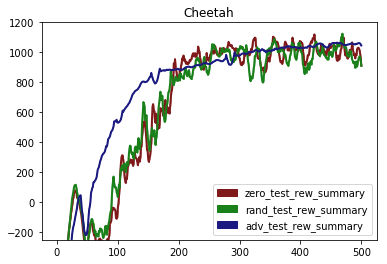

In [14]:
plot_tests = [const_test_rew_summary, rand_test_rew_summary, adv_test_rew_summary]
plot_names = ['zero_test_rew_summary', 'rand_test_rew_summary', 'adv_test_rew_summary']
plot_colors = [(0.5,0.1,0.1), (0.1,0.5,0.1), (0.1,0.1,0.5)]
all_patches = []
for i in range(len(plot_tests)):
    con_rew = np.array(plot_tests[i])
    mean_con = con_rew.mean(0)
    std_con = con_rew.std(0)
    if if_filtering==True:
        mean_window_size = 15
        mean_order = 3
        std_window_size = 45
        std_order = 2
        mean_con = scipy.signal.savgol_filter(mean_con, mean_window_size, mean_order)
        std_con = scipy.signal.savgol_filter(std_con, std_window_size, std_order)
    x = [i for i in range(len(mean_con))]
    plt.plot(x,mean_con,color=plot_colors[i], linewidth=2.0)
    plt.fill_between(x, mean_con-std_con, mean_con+std_con,color=plot_colors[i], alpha=0.5)
    all_patches.append(mpatches.Patch(color=plot_colors[i], label=plot_names[i]))

plt.legend(handles=all_patches)
axes = plt.gca()
axes.set_ylim([-250,1200])
plt.title("Cheetah")
plt.show()